#  CM50265 Machine Learning 2

## Coursework 2: Deep learning
### Youssef Alami Mejjati, Jordan Taylor, Jake Deane and Mohammad Golbabaee


This coursework is worth 75 points from the overall mark of 100 for this unit. Marks are given beside each task. The report will be your main method of assessment. __Students should form groups of 3 individuals and submit one report per group.__ For this coursework students can choose their partners until __20th February__.  Each group will receive a total mark for this course work and individuals in that group will share this mark (with weights) according to their contributions.  

- The __submission deadline__ for your report is
__17th May 2020, 12:00: online Moodle submission of your final report__

The main part of your report should not exceed __3000 word limit__. After the main part please attach a Table of individuals’ contributions and appendices including ONLY the codes (these are excluded from the word limit). The report should be submitted in PDF format. __Table of contributions__ should include both students’ names/university IDs, the list of contributions of each student, and finally the contribution percentage for each student. This percentage should be agreed between both individuals and it will be used to weigh their marks. We highly encourage individuals to evenly share the workload. Further, you should __include all codes__ relevant to your implementations as an appendix or appendices with a clear referencing to the main body of your report. Codes must be well commented (indicating major steps).

First and foremost your report should demonstrate and evaluate your results. It must include figures and screenshots with appropriate resolutions. Evaluation can be qualitative (how it looks) and, wherever possible, quantitative (tested numerically). Second you should provide evidence that you understood the mathematics behind the assignment in each task/question. You should concisely explain your approach to solve each task/question, and the choices you make (e.g. hyper-parameters etc) for each part.

Usual university rules apply, please check your MSc program handbook, particularly regarding plagiarism and delayed deliveries. 

__Note:__ All tasks should be implemented in TensorFlow. Guidelines below (tasks 3-5, 7) should work for a TensorFlow version 1. If you use TF v2 please note that some syntaxes have changed during the recent update, but you can still use version compatiblity to resolve the issue. The list includes but might not be limited to:

tf.layers.conv2d -> tf.nn.conv2d

tf.layers.dense -> tf.nn.dense

tf.layers.flatten -> tf.compat.v1.layers.flatten

tf.variable_scope -> tf.compat.v1.variable_scope

tf.get_collection -> tf.compat.v1.get_collection

similarly for tf.compat.v1.InteractiveSession, tf.compat.v1.train.AdamOptimizer, tf.compat.v1.placeholder, tf.compat.v1.global_variables_initializer, tf.compat.v1.local_variables_initializer, tf.compat.v1.train.Saver, tf.compat.v1.summary.FileWriter, tf.compat.v1.trainable_variables

See TF web documentation in case you encounter version incompatibility. 

Guides on tasks 6 and 8 should be already compatible with TF2. 


## The coursework 


In [141]:
import warnings
warnings.filterwarnings('ignore')

try:
    import tensorflow.compat.v1 as tf
    tf.disable_eager_execution()
except:
    import tensorflow as tf
    
# import tensorflow as tf # This may laod Tensorflow 2.0.0 if that is the verison of the package on your distribution
#use import tensorflow.compat.v1 as tf for tensorflow 1
# tf.disable_v2_behaviour() # Only needed if using tensorflow 1 with tensorflow 2 being the package avlaiable  
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
%matplotlib inline



In [142]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

We scale the data to be in $[-1,1]$.

In [143]:
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1

The size of each data points is $28 \times 28$. While this format will be useful when using CNNs, we will vectorize the datapoints for visualization and preliminary questions.

In [138]:
nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

### 1. Data visualisation (5 points)
Project the training data points in a 2D space using PCA. Use the obtained 2D embedding and plot the training data-points with different markers or colors for each class (you are allowed to use PCA from scikit learn). 
- Why PCA is a good option to visualize data? 
- Add this plot in your report and discuss your observations. 
- Which classes can be linearly separated?


Variation per Principal Component: [0.09704664 0.07095924]


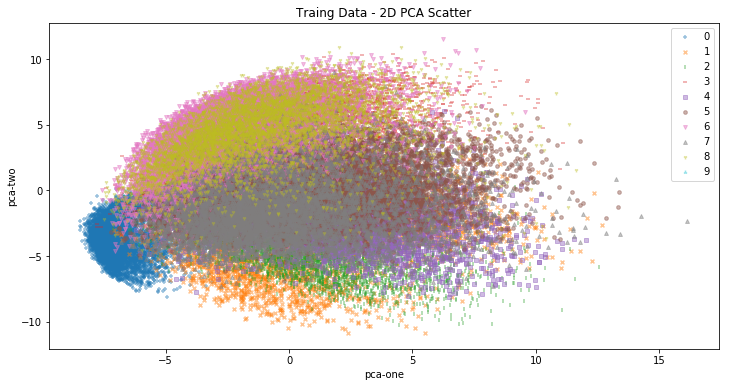

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)

plt.figure(figsize=(12,6))
marker= ['+', 'x','|','_','s','8','v','^','1','2']

print('Variation per Principal Component: {}'.format(pca.explained_variance_ratio_))

for i in range (10):
    plt.scatter(x_train_pca[y_train == i+1,0],
                x_train_pca[y_train == i+1,1],
                alpha = 0.45, s = 15,
                marker=marker[i],
                label = i)

plt.title('Traing Data - 2D PCA Scatter')
plt.xlabel('pca-one')
plt.ylabel('pca-two')
plt.legend()
plt.show()

### 2. Perceptrons: (10 points)
Single Layer Perceptron is one of the most basic binary classifiers one can use. In this part of the CW you should implement an iterative algorithm for training the Single Layer Perceptron.

As we are dealing with a binary classification problem, we will pick data points corresponding to classes 0 and 1 (handwritten digits). In addition we choose our binary labels to be -1 and 1, respectively.

In [116]:
#defining the train
cond = (y_train == 0) + (y_train == 1)
binary_x_train = x_train[cond,:]
binary_y_train = y_train[cond]*1.
binary_y_train[binary_y_train == 0] = -1
binary_y_train[binary_y_train == 1] = 1

#defining the test
cond = (y_test == 0) + (y_test == 1)
binary_x_test = x_test[cond,:]
binary_y_test = y_test[cond]*1.
binary_y_test[binary_y_test == 0] = -1
binary_y_test[binary_y_test == 1] = 1

#### Task 2.1
Complete the function 'predict' below.
#### inputs:

+ $x\in\mathbb{R^{n*m}}$, with $n$ being the number of datapoints and $m$ being the feature dimensionality. 
+ $w \in\mathbb{R^m}$ is the parameter vector we wish to learn. 
+ $b \in\mathbb{R}$ is the corresponding bias.

#### outputs: 
+ 'prediction'$\in\mathbb{R^n}$, a vector containing prediction values associated with $x$. 

In [117]:
def predict(x, w, b):
    ######### Complete the function- x point ######### 
    linear_comb = np.dot(x, w) + b
    if linear_comb > 0:
        return 1
    else:
        return -1

#### Task 2.2
+ Use the funtion 'predict' above to implement the Single Layer Perceptron algorithm by completing the function 'optimize' defined below.
    #### inputs:

    + $x\in\mathbb{R^{n*m}}$, with $n$ being the number of datapoints and $m$ being the feature dimensionality. 
    + $w \in\mathbb{R^m}$ is the initial parameter vector.
    + $b \in\mathbb{R}$ is the initial bias value.
    + $y\in\mathbb{R^n}$ is the training labels associated with x.
    #### outputs:
    + $w$ is the optimized parameter vector.
    + $b$ the corresponding learned bias.
    + $\text{error}$ is the classification error obtained.  
    
    
 
    
Use the learned parameters $w$, $b$ (obtained via function 'optimize') and the function 'predict' to return the classification accuracy on the test set using x_train and y_train as training data. 

- Demonstrate that your algorithm converges to a good local minima. Plot the training error curve vs. number of iterations. 
- Show what feature $w$ has learned and discuss why? (demonstrate $w$ as an image with the same size as inputs).

- Repeat this training/testing procedure to classify different pairs. Report the accuracies of 5 pairs in a Table and dicuss why some are easier to classify than others.


In [118]:
def predict_many(x, w, b):
    pred = np.empty(len(x))
    for i in range(len(x)):
        pred[i] = predict(x[i], w, b)
    return pred

In [119]:
def loss(pred, y):
    loss = 0
    for pred_i, y_i in zip(pred, y):
        if pred_i != y_i:
            loss += 1
    return loss/len(pred)

In [120]:
def optimize(x, y, lr=0.003):
    iter = 0
    error=np.inf
    n, m = x.shape
    w = np.random.rand(m) # Initialize the w vector
    b = np.random.rand()  # Initialize the b vector
    hist = []
    while (iter <= 1000) & (error > 1e-3):
        idx = np.random.randint(n) # Get random index to update
        prediction = predict(x[idx], w, b) # Predict one to update the bias
        if prediction == y[idx]:
            continue
        err = y[idx] - prediction
        w = w + lr * y[idx] * x[idx] # Update weights
        b += lr * err # Update bias
        if iter % 1 == 0: # Change when the loss is recorded and calculated
            pred = predict_many(x, w, b)
            error = loss(pred, y) # Update error
            hist.append(error)
        iter += 1
    return w, b, error, hist

Classification Accuracy = 99.95%



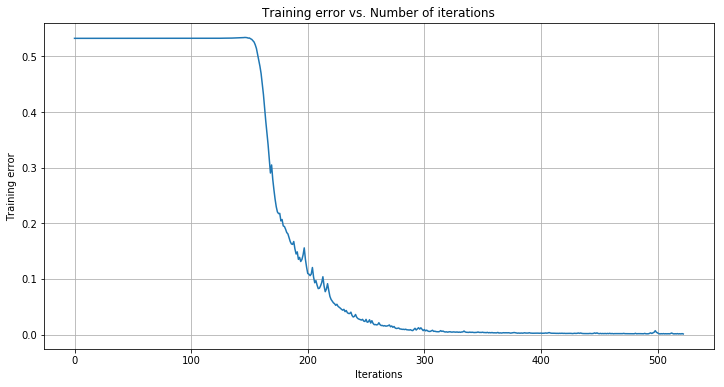

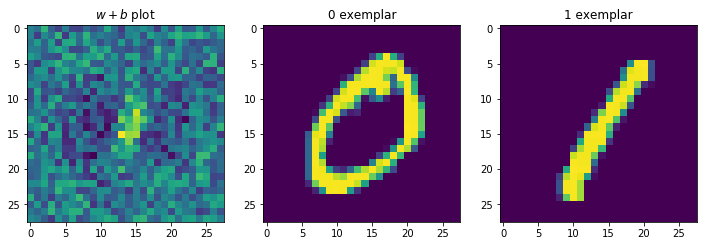

In [121]:
# optimising/training the single layer perceptron
the_w, the_b, training_error, hist = optimize(binary_x_train, binary_y_train)

# Use the learned parameters 𝑤, 𝑏 to predict and eturn the classification accuracy on the test set using x_train and y_train as training data.
binary_x_pred = predict_many(binary_x_test, the_w, the_b)
binary_xy = binary_x_pred  == binary_y_test
accuracy = sum(binary_xy)/len(binary_xy)
print(f"Classification Accuracy = {accuracy*100:.2f}%".format(5))
print('')

# plotting training error curve vs. number of iterations
plt.figure(figsize=(12,6))
plt.plot(hist)
plt.grid()
plt.title("Training error vs. Number of iterations")
plt.xlabel("Iterations")
plt.ylabel("Training error")

# demonstrate 𝑤 as an image with the same size as inputs
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,6))
ax1.imshow((the_w + the_b).reshape(28, 28))
ax2.imshow(binary_x_train[binary_y_train == -1][0].reshape(28, 28))
ax3.imshow(binary_x_train[binary_y_train == 1][0].reshape(28, 28))
ax1.title.set_text('$w+b$ plot')
ax2.title.set_text('0 exemplar')
ax3.title.set_text('1 exemplar')
plt.show()

In [122]:
def classify_pair(x1,x2):
    cond = (y_train == x1) + (y_train == x2)
    binary_x_train = x_train[cond,:]
    binary_y_train = y_train[cond]*1.
    binary_y_train[binary_y_train == x1] = -1
    binary_y_train[binary_y_train == x2] = 1
    
    cond = (y_test == x1) + (y_test == x2)
    binary_x_test = x_test[cond,:]
    binary_y_test = y_test[cond]*1.
    binary_y_test[binary_y_test == x1] = -1
    binary_y_test[binary_y_test == x2] = 1
    
    the_w, the_b, training_error, hist = optimize(binary_x_train, binary_y_train, lr=0.003)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,6))
    ax1.imshow((the_w + the_b).reshape(28, 28))
    
    ax2.imshow(binary_x_train[binary_y_train == -1][0].reshape(28, 28))
    ax3.imshow(binary_x_train[binary_y_train == 1][0].reshape(28, 28))
    ax1.title.set_text('$w+b$ plot')
    ax2.title.set_text(str(x1)+' exemplar')
    ax3.title.set_text(str(x2)+' exemplar')
    plt.show()
    
    binary_x_pred = predict_many(binary_x_test, the_w, the_b)
    binary_xy = binary_x_pred  == binary_y_test
    accuracy = sum(binary_xy)/len(binary_xy)
    return accuracy

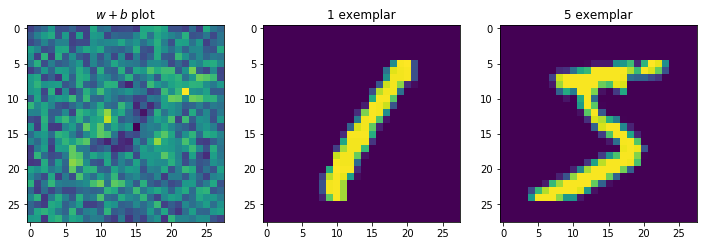

Classification Accuracy = 99.36%


In [123]:
acc1 = classify_pair(1,5)
print(f"Classification Accuracy = {acc1*100:.2f}%".format(5))

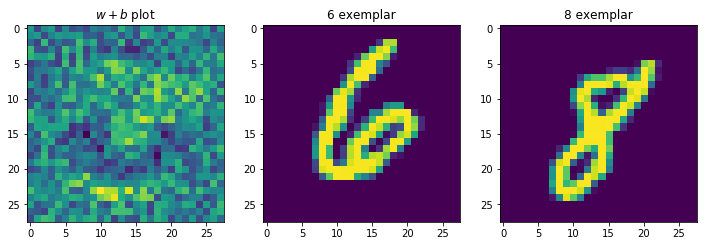

Classification Accuracy = 98.34%


In [14]:
acc2 = classify_pair(6,8)
print(f"Classification Accuracy = {acc2*100:.2f}%".format(5))

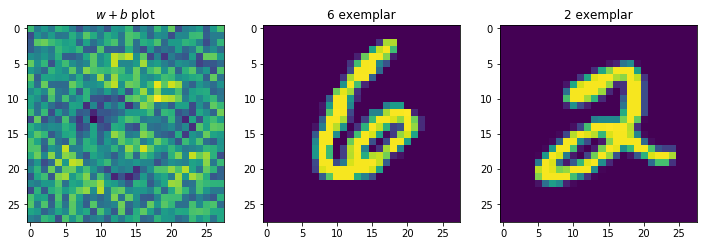

Classification Accuracy = 97.54%


In [15]:
acc3 = classify_pair(6,2)
print(f"Classification Accuracy = {acc3*100:.2f}%".format(5))

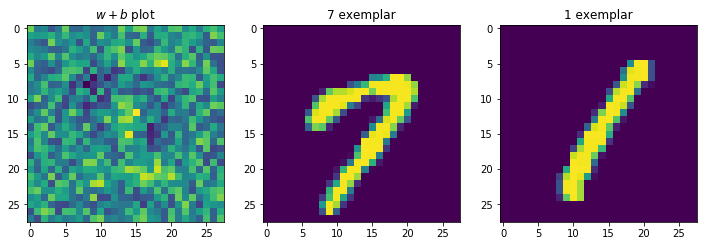

Classification Accuracy = 99.54%


In [16]:
acc4 = classify_pair(7,1)
print(f"Classification Accuracy = {acc4*100:.2f}%".format(5))

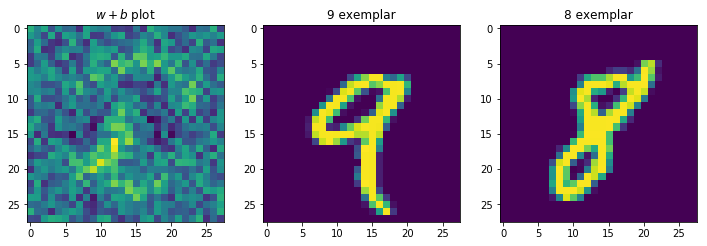

Classification Accuracy = 96.42%


In [17]:
acc5 = classify_pair(9,8)
print(f"Classification Accuracy = {acc5*100:.2f}%".format(5))

### 3: Multi Layer Perceptron (10 points)

Multi Layer Perceptron (MLP) is a fully connected deep (more than one hidden layer) network. In this part of the coursework we will implement a 2 hidden layers MLP with Recified Linear Unit (ReLU) activations. We will train the model via ADAM optimizer over a cross-entropy loss function.

First of all, we will convert our label vectors to matrices via one-hot encoding (e.g. $y=2$ would become $[0,0,1,0,0,0,0,0,0,0]$). This can be simply done using commands below:

In [124]:
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

Below, we define a class MLP. It is initialized via:  

+ x_train: The training matrix.
+ y_train: One hot encoding of the corresponding labels.
+ lr: Learning rate used for ADAM optimizer
+ nb_epochs: Number of epochs to use
+ batch_size: The number of data point in each mini-batch
+ output_dir: The directory where model parameters and tensorboard event files will be stored.

We also define the methods: 
* 'create_model' which will desribe a neural network architecture of the form $[784, 1000, 1000, 10]$, each integer representing the number of neurons in a given layer while the length of the vector defines the number of layers accordingly. 
* 'compute_loss' which given the output of 'create_model' will calculate the cross-entropy loss of the mini-batches.
* 'train' where we initiate a tensorflow session and perform the training iterations. 
* 'test' where we load our trained model and perform inference on the test set.

##### Task 3.1
- Complete the method 'create_model' in order to implement a network of the shape $[784, 1000, 1000, 10]$, use ReLU as the non linear activation for hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output __<font color='red'>without activation of the MLP.</font>__
   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 

Hints: 
- You may use tf.layers.dense to implement a fully connected layer. 
- To obtain the probabilities you must normalize your outputs in a way that their sum is equal to one using a softmax function.

In [40]:
class MLP_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 1000, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 1000, activation=tf.nn.relu)
            output = tf.layers.dense(hidden2, 10)
            
            self.logits = output # This is used in order to calculate the loss function
            self.preds = tf.nn.softmax(output) # This allows the model to be run and generate predictions
        #########################################
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

Now that we defined our model, our loss and its optimizer. we can instantate the MLP class, initiate our variables, and start the tensorflow session:

In [41]:
tf.reset_default_graph()

model = MLP_2(x_train, y_train, './MLP_logdir/', 0.001, 5, 100)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



We can now start training. We loop over the training data points and we feed them to the session in mini-batches form. we repeat this process several times (for several epochs). 

In [42]:
import time

t0 = time.time()
mlp_2_train_loss = []
mlp_2_train_acc = []
mlp_2_test_loss = []
mlp_2_test_acc = []

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})

        mlp_2_train_loss.append(loss)
        if i % 10 == 0:
            test_loss, test_preds = sess.run([model.loss, model.preds] , feed_dict={model.im: x_test, model.labels: y_test})
            test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1)) * 1)
            mlp_2_test_loss.append(test_loss)
            mlp_2_test_acc.append(test_acc)
            
        
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        
        mlp_2_train_acc.append(acc_train) # Appends batch accuracy
        
        if np.mod(i, model.nb_iterations//3) == 0:
            print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
    print('')
# sess.close()
MLP_2_1_time = time.time() - t0

Epoch 0, Iteration 0, loss 2.336, batch accuracy 0.180
Epoch 0, Iteration 200, loss 0.181, batch accuracy 0.950
Epoch 0, Iteration 400, loss 0.365, batch accuracy 0.870

Epoch 1, Iteration 0, loss 0.050, batch accuracy 0.980
Epoch 1, Iteration 200, loss 0.169, batch accuracy 0.960
Epoch 1, Iteration 400, loss 0.130, batch accuracy 0.930

Epoch 2, Iteration 0, loss 0.038, batch accuracy 0.990
Epoch 2, Iteration 200, loss 0.031, batch accuracy 0.990
Epoch 2, Iteration 400, loss 0.068, batch accuracy 0.980

Epoch 3, Iteration 0, loss 0.123, batch accuracy 0.950
Epoch 3, Iteration 200, loss 0.193, batch accuracy 0.940
Epoch 3, Iteration 400, loss 0.149, batch accuracy 0.940

Epoch 4, Iteration 0, loss 0.046, batch accuracy 0.970
Epoch 4, Iteration 200, loss 0.088, batch accuracy 0.960
Epoch 4, Iteration 400, loss 0.032, batch accuracy 0.980



Text(0, 0.5, 'Accuracy')

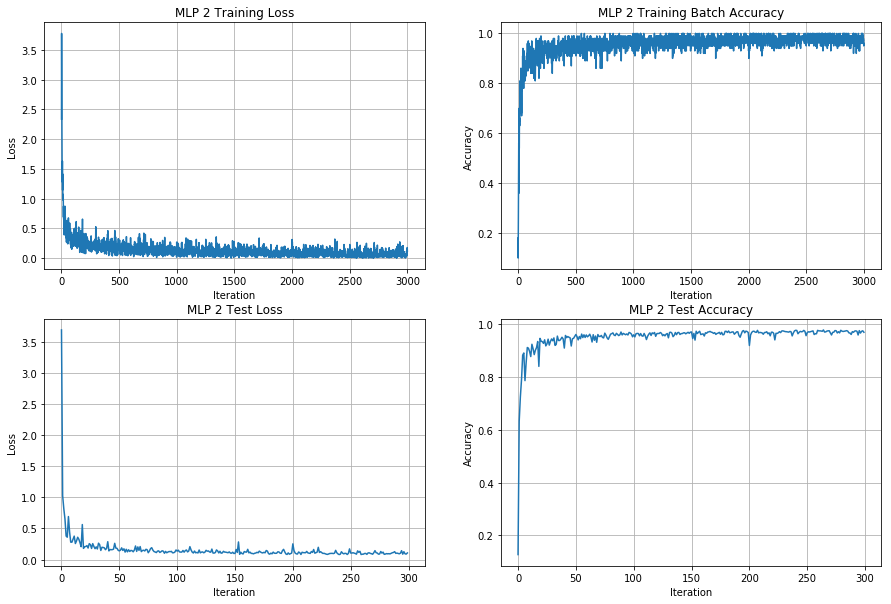

In [43]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))


ax1.plot(mlp_2_train_loss)
ax1.grid()
ax1.title.set_text("MLP 2 Training Loss")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")

ax2.plot(mlp_2_train_acc)
ax2.grid()
ax2.title.set_text("MLP 2 Training Batch Accuracy")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")

ax3.plot(mlp_2_test_loss)
ax3.grid()
ax3.title.set_text("MLP 2 Test Loss")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4.plot(mlp_2_test_acc)
ax4.grid()
ax4.title.set_text("MLP 2 Test Accuracy")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Accuracy")



During and after training visualize the training and the created graph via tensorboard. Tensorboard is accessible via the command "tensorboard --logdir=#yourlogdir#". Check out https://www.tensorflow.org/guide/summaries_and_tensorboard for more details.

Similarly we loop over the test dataset and get the test accuracy via:

In [44]:
batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
MLP_2_1_acc = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %MLP_2_1_acc)

Test accuracy achieved: 0.972



- Include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report.


We now close the tensorflow session:

In [45]:
sess.close()

##### Task 3.2
Using a similar format as before, discuss how the number of layers affects the classification accuracy. 
- Train four different networks with more hidden layers for example 3,4,5 and 7 hidden layers (choice is yours here to make a good conclusion). Choose an appropriate width i.e. number of neurons per layer so to achieve good accuracy and feasible training time. How many paramters (weights/biases) do these models have? How do they compare to the former MLP you implemented? 
- Compare the classification accuracies of these networks with the previous MLP.


- Plot a graph showing the accuracy vs. depth v.s. complexity (number of paramters) of the all five MLPs with different depths/widths. Additionally report the results in a Table. Discuss the results and provide conclusion. 


In [56]:
mlp_1 = [784, 1000, 1000, 10]
mlp_2 = [784, 650, 650, 650, 650, 10]
mlp_3 = [784, 1000, 1000, 1000, 1000, 10]
mlp_4 = [784, 400, 400, 400, 400, 400, 400, 10]
mlp_5 = [784, 525, 525, 525, 525, 525, 525, 10]
mlp_6 = [784, 350, 350, 350, 350, 350, 350, 350, 10]
mlp_7 = [784, 700, 600, 500, 400, 300, 200, 100, 10]

def MLP_complexity(mlp_shape):
    num_param = 0
 
    for i in range(1,len(mlp_shape)):
        num_param += mlp_shape[i]*mlp_shape[i-1]
        num_param += mlp_shape[i]

    return num_param

print('mlp_1 has %.f hidden layers and %.f paramters' %(len(mlp_1)-2, MLP_complexity(mlp_1)))
print('mlp_2 has %.f hidden layers and %.f paramters' %(len(mlp_2)-2, MLP_complexity(mlp_2)))
print('mlp_3 has %.f hidden layers and %.f paramters' %(len(mlp_3)-2, MLP_complexity(mlp_3)))
print('mlp_4 has %.f hidden layers and %.f paramters' %(len(mlp_4)-2, MLP_complexity(mlp_4)))
print('mlp_5 has %.f hidden layers and %.f paramters' %(len(mlp_5)-2, MLP_complexity(mlp_5)))
print('mlp_6 has %.f hidden layers and %.f paramters' %(len(mlp_6)-2, MLP_complexity(mlp_6)))
print('mlp_7 has %.f hidden layers and %.f paramters' %(len(mlp_7)-2, MLP_complexity(mlp_7)))


mlp_1 has 2 hidden layers and 1796010 paramters
mlp_2 has 4 hidden layers and 1786210 paramters
mlp_3 has 4 hidden layers and 3798010 paramters
mlp_4 has 6 hidden layers and 1120010 paramters
mlp_5 has 6 hidden layers and 1798135 paramters
mlp_6 has 7 hidden layers and 1015360 paramters
mlp_7 has 7 hidden layers and 1672610 paramters


In [66]:
def mlp_train_test(mlp_model,i, title):    
    t0 = time.time()

    tf.reset_default_graph()
    model = mlp_model(x_train, y_train, './MLP_'+str(i)+'_logdir/', 0.001, 5, 100)
    model.create_model()
    model.compute_loss()
    model.optimizer()
    init = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

    saver = tf.train.Saver()
    summary =tf.Summary()
    sess = tf.InteractiveSession()
    sess.run(init)
    writer = tf.summary.FileWriter(model.output_dir)
    writer.add_graph(sess.graph)
    if not os.path.exists(model.output_dir):
        os.makedirs(model.output_dir)
    mlp_2_train_loss = []
    mlp_2_train_acc = []
    mlp_2_test_loss = []
    mlp_2_test_acc = []
        
    for epoch in range(model.nb_epochs):
        randomize = np.arange(x_train.shape[0])
        np.random.shuffle(randomize)
        x_in = model.x_train[randomize,:]
        y_in = model.y_train[randomize,:]
        for i in range(model.nb_iterations):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train, 
                                                model.labels: input_y_train})
            
            mlp_2_train_loss.append(loss)
            if i % 10 == 0:
                test_loss, test_preds = sess.run([model.loss, model.preds] , feed_dict={model.im: x_test, model.labels: y_test})
                test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1)) * 1)
                mlp_2_test_loss.append(test_loss)
                mlp_2_test_acc.append(test_acc)
                                
            y_preds = np.argmax(preds, axis=1)
            y_real = np.argmax(input_y_train, axis=1)
            acc_train = np.mean((y_preds==y_real)*1)
            mlp_2_train_acc.append(acc_train) # Appends batch accuracy
            writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        saver.save(sess, model.output_dir, global_step=epoch)  

    batch_size_test = 20
    nb_test_points = x_test.shape[0] 
    nb_iterations = nb_test_points//batch_size_test
    preds = []
    for i in range(nb_iterations):
        input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
        preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds_test, axis=1))
        if np.mod(nb_test_points, batch_size_test) !=0:
            input_x_test = x_test[i*batch_size_test: -1]
            preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
            preds.append(np.argmax(preds, axis=1))
    all_preds = np.concatenate(preds, axis =0)
    y_real = np.argmax(y_test, axis=1)
    acc_test = np.mean((all_preds==y_real)*1)
    sess.close()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))


    ax1.plot(mlp_2_train_loss)
    ax1.grid()
    ax1.title.set_text("MLP 2 Training Loss " + title)
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")

    ax2.plot(mlp_2_train_acc)
    ax2.grid()
    ax2.title.set_text("MLP 2 Training Batch Accuracy " + title)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Accuracy")

    ax3.plot(mlp_2_test_loss)
    ax3.grid()
    ax3.title.set_text("MLP 2 Test Loss " + title)
    ax3.set_xlabel("Iteration")
    ax3.set_ylabel("Loss")

    ax4.plot(mlp_2_test_acc)
    ax4.grid()
    ax4.title.set_text("MLP 2 Test Accuracy " + title)
    ax4.set_xlabel("Iteration")
    ax4.set_ylabel("Accuracy")
    
    plt.show()
    
    return acc_test, time.time() - t0


In [58]:
class MLP_4_1: 
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 650, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 650, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 650, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 650, activation=tf.nn.relu)
            output = tf.layers.dense(hidden4, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [59]:
class MLP_4_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 1000, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 1000, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 1000, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 1000, activation=tf.nn.relu)
            output = tf.layers.dense(hidden4, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [60]:
class MLP_6_1:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 400, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 400, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 400, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 400, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 400, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden4, 400, activation=tf.nn.relu)
            output = tf.layers.dense(hidden5, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [61]:
class MLP_6_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 525, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 525, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 525, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 525, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 525, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden5, 525, activation=tf.nn.relu)
            output = tf.layers.dense(hidden6, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [62]:
class MLP_7_1:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 350, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 350, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 350, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 350, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 350, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden5, 350, activation=tf.nn.relu)
            hidden7 = tf.layers.dense(hidden6, 350, activation=tf.nn.relu)
            output = tf.layers.dense(hidden7, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [63]:
class MLP_7_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 480, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 480, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 480, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 480, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 480, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden5, 480, activation=tf.nn.relu)
            hidden7 = tf.layers.dense(hidden6, 480, activation=tf.nn.relu)
            output = tf.layers.dense(hidden7, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

depth = 2, paramters = 1796010, accuracy = 0.9710, time = 21.30


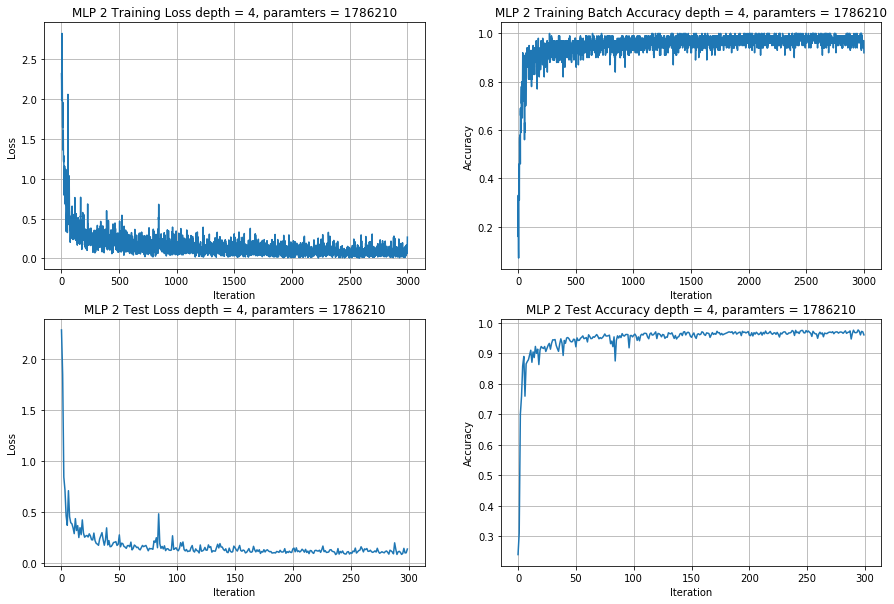

depth = 4, paramters = 1786210, accuracy = 0.9517, time = 23.92


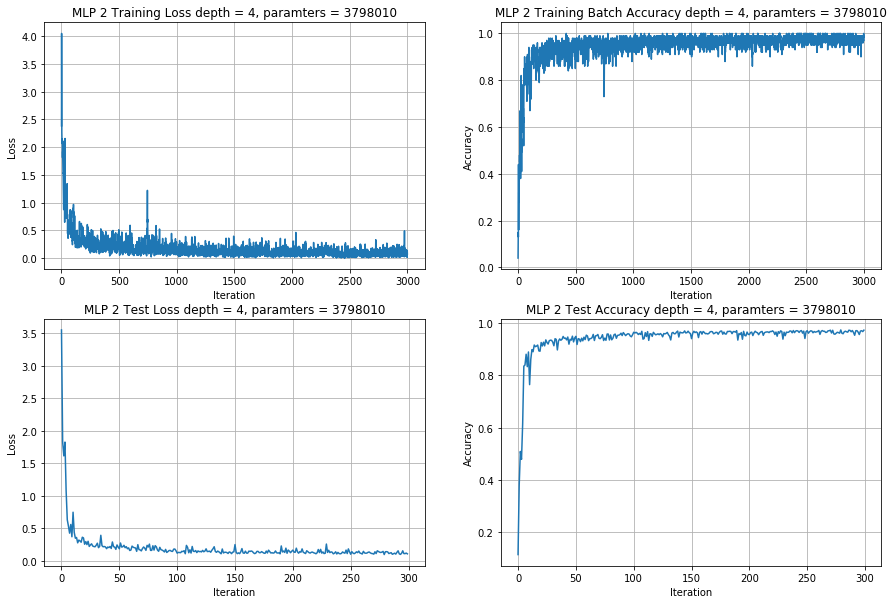

depth = 4, paramters = 3798010, accuracy = 0.9588, time = 29.52


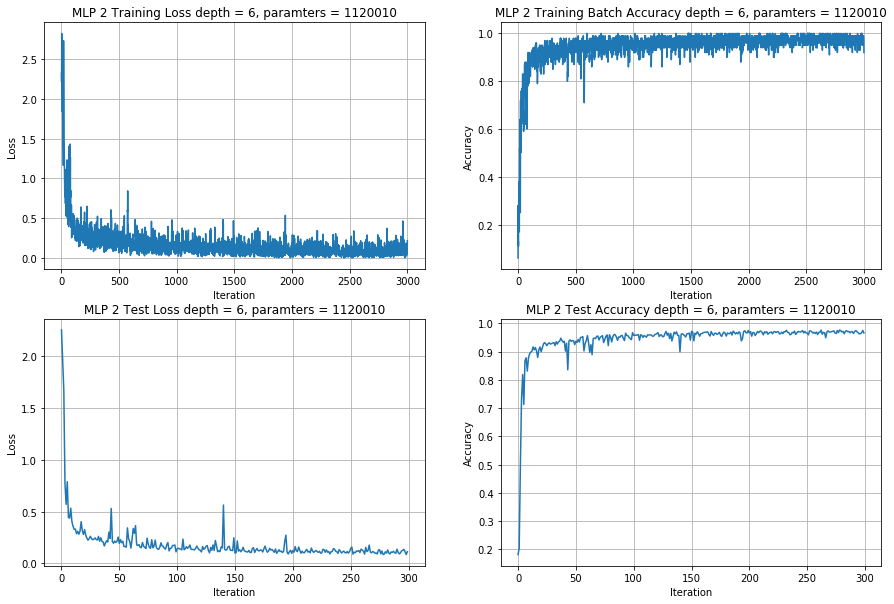

depth = 6, paramters = 1120010, accuracy = 0.9637, time = 19.75


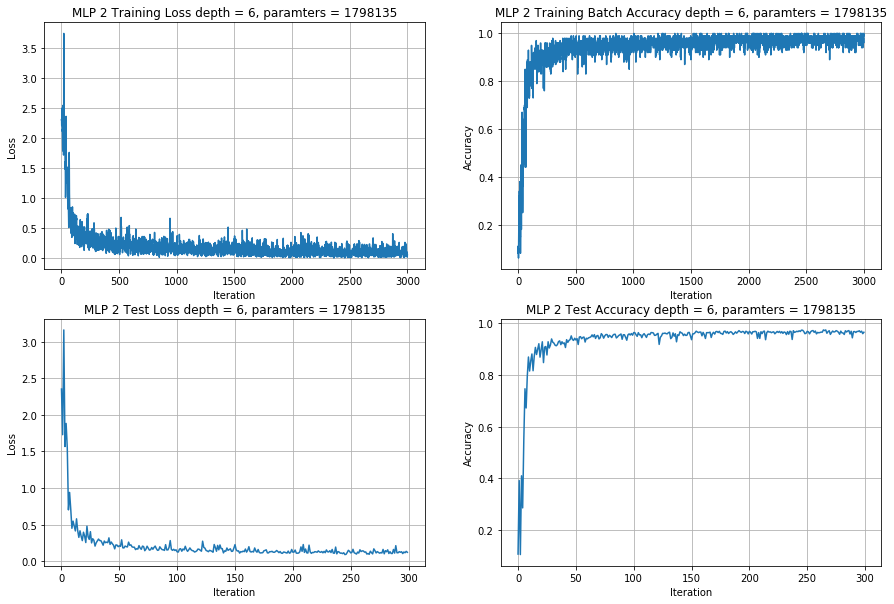

depth = 6, paramters = 1798135, accuracy = 0.9727, time = 23.66


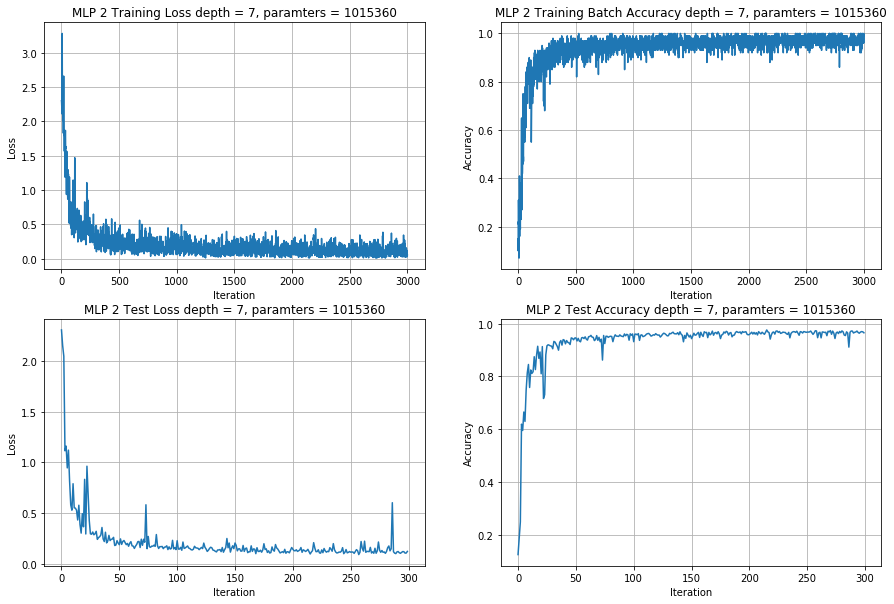

depth = 7, paramters = 1015360, accuracy = 0.9686, time = 19.94


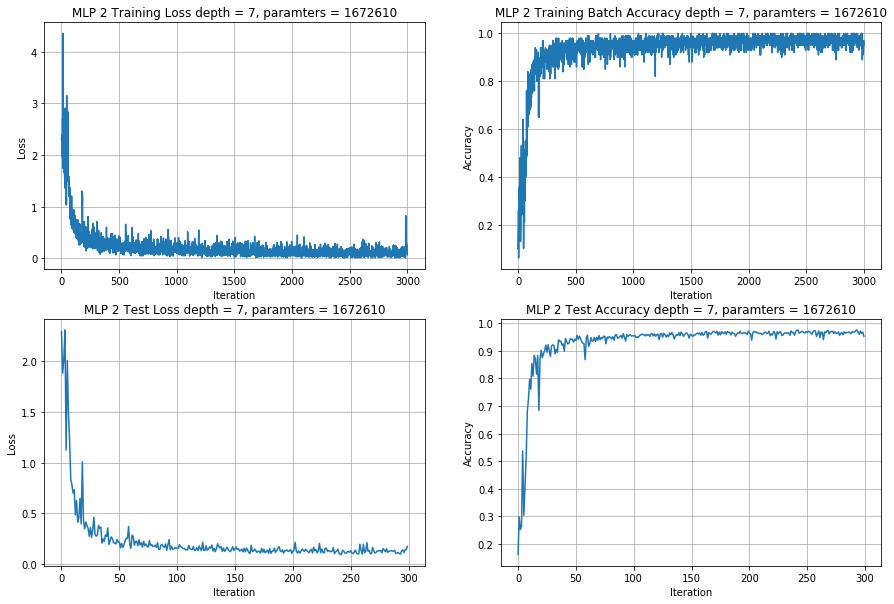

depth = 7, paramters = 1672610, accuracy = 0.9638, time = 23.79


In [67]:
print('depth = 2, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_1), MLP_2_1_acc, MLP_2_1_time))

MLP_4_1_acc, MLP_4_1_time = mlp_train_test(MLP_4_1,1, 'depth = 4, paramters = %.f'%(MLP_complexity(mlp_2)))
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_2), MLP_4_1_acc, MLP_4_1_time))
MLP_4_2_acc, MLP_4_2_time = mlp_train_test(MLP_4_2,2, 'depth = 4, paramters = %.f'%(MLP_complexity(mlp_3)))
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_3), MLP_4_2_acc, MLP_4_2_time))

MLP_6_1_acc, MLP_6_1_time = mlp_train_test(MLP_6_1,3, 'depth = 6, paramters = %.f'%(MLP_complexity(mlp_4)))
print('depth = 6, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_4), MLP_6_1_acc, MLP_6_1_time))
MLP_6_2_acc, MLP_6_2_time = mlp_train_test(MLP_6_2,4, 'depth = 6, paramters = %.f'%(MLP_complexity(mlp_5)))
print('depth = 6, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_5), MLP_6_2_acc, MLP_6_2_time))

MLP_7_1_acc, MLP_7_1_time = mlp_train_test(MLP_7_1,5, 'depth = 7, paramters = %.f'%(MLP_complexity(mlp_6)))
print('depth = 7, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_6), MLP_7_1_acc, MLP_7_1_time))
MLP_7_2_acc, MLP_7_2_time = mlp_train_test(MLP_7_2,6, 'depth = 7, paramters = %.f'%(MLP_complexity(mlp_7)))
print('depth = 7, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_7), MLP_7_2_acc, MLP_7_2_time))

### 4. Convolutional Neural Network (10 points)
Now that we are more familiar with the MLP algorithm, it is time to see how it compares with a Convolutional Neural Network (CNN). CNNs leverage dependencies between neighbouring pixels, making them more efficient and light weight compared to their fully connected counter part. In this section we will implement a Class CNN similar to the one we defined before for MLP.

##### Task 4.1
Complete the function 'create_model' of the class CNN above. Implement a CNN of the shape [32, 64, 128]; where 32, 64, 128 represent the number of convolutional filters for each hidden layer. We will use a kernel size of size $4\times4$. 

Use a stride of 1 in the first convolutional layer, followed by a stride of 2 for the following layers (a stride of two help downsampling without requiring the use of pooling layers). Vectorize the obtained output using tf.layer.flatten, and end the model with a fully connected layer of 10 neurons. Use ReLU as the non linear activation for the hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output without activation of the last __<font color='red'>fully connected layer</font>.__ 

   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 

Hints: 
+ You may use tf.layers.conv2d to implement a convolutional layer. 
+ To obtain the probabilities you must normalize your outputs in a way that their sum is equal to one using a softmax function.

In [68]:
class CNN_1:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            ######### Complete the function ######### 
            # We save the hidden layers inside as attributes from the object so 
            # they can be called layer for visualization
            self.hidden1 = tf.layers.conv2d(self.im, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3') 
            # After 3 convolutional filters we flatten the array
            flattened = tf.layers.flatten(self.hidden3)
            # We feed it to a dense network to adquire the logits
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output) # This allows the model to be run and generate predictions
            #########################################
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

CNNs leverage dependencies between neighbouring pixels, however this information is partially lost when we vectorized our data. For training CNNs we will need to recover our initial shape of $N \times 28 \times 28$.

In [69]:
edge = int(np.sqrt(nb_features))
x_train.resize([n_train, edge, edge])
x_test.resize([n_test, edge, edge])

We instantiate our CNN class, start the corresponging tensorflow session and initiate the trainable variables. 

In [72]:
tf.reset_default_graph()

model = CNN_1(x_train, y_train, './CNN_1_logdir/', 0.001, 5, 100)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

We start training:

In [75]:
t0 = time.time()
cnn_train_loss = []
cnn_train_acc = []
cnn_test_loss = []
cnn_test_acc = []
input_x_test_0 = x_test[:, :, :,np.newaxis]
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        cnn_train_loss.append(loss)
        if i % 10 == 0:
            test_loss, test_preds = sess.run([model.loss, model.preds] , feed_dict={model.im: input_x_test_0, model.labels: y_test})
            test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1)) * 1)
            cnn_test_loss.append(test_loss)
            cnn_test_acc.append(test_acc)
        
        
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        
        cnn_train_acc.append(acc_train) # Appends batch accuracy

        if np.mod(i, model.nb_iterations//3) == 0:
            print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
    print('')
# sess.close()
CNN_1_time = time.time() - t0

Epoch 0, Iteration 0, loss 2.224, batch accuracy 0.280
Epoch 0, Iteration 200, loss 0.053, batch accuracy 0.990
Epoch 0, Iteration 400, loss 0.164, batch accuracy 0.930

Epoch 1, Iteration 0, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 200, loss 0.025, batch accuracy 0.990
Epoch 1, Iteration 400, loss 0.012, batch accuracy 0.990

Epoch 2, Iteration 0, loss 0.128, batch accuracy 0.970
Epoch 2, Iteration 200, loss 0.041, batch accuracy 0.980
Epoch 2, Iteration 400, loss 0.139, batch accuracy 0.960

Epoch 3, Iteration 0, loss 0.056, batch accuracy 0.980
Epoch 3, Iteration 200, loss 0.028, batch accuracy 0.980
Epoch 3, Iteration 400, loss 0.035, batch accuracy 0.990

Epoch 4, Iteration 0, loss 0.018, batch accuracy 1.000
Epoch 4, Iteration 200, loss 0.006, batch accuracy 1.000
Epoch 4, Iteration 400, loss 0.001, batch accuracy 1.000



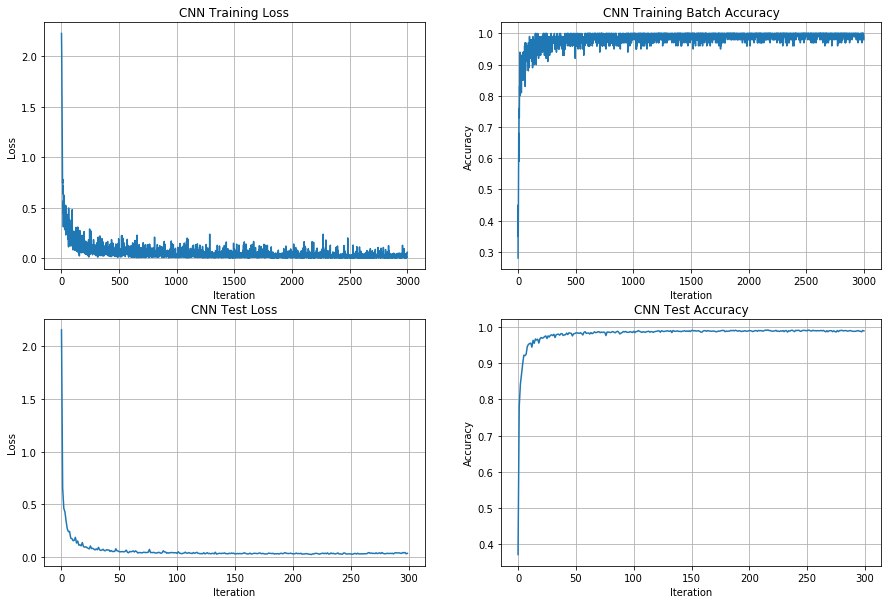

In [78]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))


ax1.plot(cnn_train_loss)
ax1.grid()
ax1.title.set_text("CNN Training Loss")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")

ax2.plot(cnn_train_acc)
ax2.grid()
ax2.title.set_text("CNN Training Batch Accuracy")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")

ax3.plot(cnn_test_loss)
ax3.grid()
ax3.title.set_text("CNN Test Loss")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4.plot(cnn_test_acc)
ax4.grid()
ax4.title.set_text("CNN Test Accuracy")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Accuracy")

plt.show()


we loop over the test dataset and compute the corresponding classification accuracy. 

- Similar to Task 3.1, include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report. 

In [76]:
batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    input_x_test = input_x_test[:, :, :,np.newaxis]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
CNN_1_acc = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %CNN_1_acc)

Test accuracy achieved: 0.991


In [58]:
sess.close()

##### Task 4.2
Similar to task 3.2, discuss 
- Plot a graph showing complexity (number of paramters) vs. accuracy vs. depth of networks. For this part you need to train four additional CNNs of different depths/widths (again, your choice) and report the results in a Table. Discuss the results and provide conclusion.


- In addition discuss and analyze the differences in term of performance, number of model parameters (i.e. weights/biases) and training/testing times between CNNs and MLPs. Provide a concusion. (For these discussions you should compare your results in Table 4.2 to Table 3.2)

In [ ]:
cnn_1 = [32, 64, 128]
cnn_2 = [16, 32, 64, 128]
cnn_3 = [16, 16, 32, 64, 128]
cnn_4 = [9, 16, 36, 64]
cnn_5 = [64, 128, 256]

def CNN_complexity(cnn_shape):

    num_param = cnn_shape[0] * 4 * 4 + cnn_shape[0] # input has 1 channel with no parameters to learn
 
    for i in range(1,len(cnn_shape)):
        num_param += cnn_shape[i]*cnn_shape[i-1] * 16 #size of kernel is 4*4
        num_param += cnn_shape[i] #adding biases
    num_param += 10 * 28 * 28 *cnn_shape[-1] + 10 #final dense layer into the output for 28x28 images
    return num_param

print('cnn_1 has %.f convolutional layers and %.f paramters' %(len(cnn_1), CNN_complexity(cnn_1)))
print('cnn_2 has %.f convolutional layers and %.f paramters' %(len(cnn_2), CNN_complexity(cnn_2)))
print('cnn_3 has %.f convolutional layers and %.f paramters' %(len(cnn_3), CNN_complexity(cnn_3)))
print('cnn_4 has %.f convolutional layers and %.f paramters' %(len(cnn_4), CNN_complexity(cnn_4)))
print('cnn_5 has %.f convolutional layers and %.f paramters' %(len(cnn_5), CNN_complexity(cnn_5)))


cnn_1 has 3 convolutional layers and 1168106 paramters
cnn_2 has 4 convolutional layers and 1176058 paramters
cnn_3 has 5 convolutional layers and 1180170 paramters
cnn_4 has 4 convolutional layers and 550423 paramters
cnn_5 has 3 convolutional layers and 2663882 paramters


In [93]:
def cnn_train_test(cnn_model, i, title):
    t0 = time.time()
    tf.reset_default_graph()
    model = cnn_model(x_train, y_train, './CNN_'+str(i)+'_logdir/', 0.001, 5, 100)
    model.create_model()
    model.compute_loss()
    model.optimizer()
    init = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

    saver = tf.train.Saver()
    summary =tf.Summary()
    sess = tf.InteractiveSession()
    sess.run(init)
    writer = tf.summary.FileWriter(model.output_dir)
    writer.add_graph(sess.graph)
    if not os.path.exists(model.output_dir):
        os.makedirs(model.output_dir)
    cnn_train_loss = []
    cnn_train_acc = []
    cnn_test_loss = []
    cnn_test_acc = []
    
    for epoch in range(model.nb_epochs):
        randomize = np.arange(x_train.shape[0])
        np.random.shuffle(randomize)
        x_in = model.x_train[randomize,:]
        y_in = model.y_train[randomize,:]
        for i in range(model.nb_iterations):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train, 
                                                model.labels: input_y_train})
            cnn_train_loss.append(loss)
            if i % 10 == 0:
                test_loss, test_preds = sess.run([model.loss, model.preds] , feed_dict={model.im: input_x_test_0[:1000], model.labels: y_test[:1000]})
                test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test[:1000], axis=1)) * 1)
                cnn_test_loss.append(test_loss)
                cnn_test_acc.append(test_acc)
                
            y_preds = np.argmax(preds, axis=1)
            y_real = np.argmax(input_y_train, axis=1)
            acc_train = np.mean((y_preds==y_real)*1)
            cnn_train_acc.append(acc_train) # Appends batch accuracy
            writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        saver.save(sess, model.output_dir, global_step=epoch)  

    batch_size_test = 20
    nb_test_points = x_test.shape[0] 
    nb_iterations = nb_test_points//batch_size_test
    preds = []
    for i in range(nb_iterations):
        input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
        input_x_test = input_x_test[:, :, :,np.newaxis]
        preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds_test, axis=1))
        if np.mod(nb_test_points, batch_size_test) !=0:
            input_x_test = x_test[i*batch_size_test: -1]
            preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
            preds.append(np.argmax(preds, axis=1))
    all_preds = np.concatenate(preds, axis =0)
    y_real = np.argmax(y_test, axis=1)
    acc_test = np.mean((all_preds==y_real)*1)
    
    sess.close()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

    ax1.plot(cnn_train_loss)
    ax1.grid()
    ax1.title.set_text(title + " Training Loss")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")

    ax2.plot(cnn_train_acc)
    ax2.grid()
    ax2.title.set_text(title + " Training Batch Accuracy")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Accuracy")

    ax3.plot(cnn_test_loss)
    ax3.grid()
    ax3.title.set_text(title + " Test Loss")
    ax3.set_xlabel("Iteration")
    ax3.set_ylabel("Loss")

    ax4.plot(cnn_test_acc)
    ax4.grid()
    ax4.title.set_text(title + " Test Accuracy")
    ax4.set_xlabel("Iteration")
    ax4.set_ylabel("Accuracy")

    plt.show()
    
    return acc_test, time.time() - t0

In [80]:
class CNN_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3')
            self.hidden4 = tf.layers.conv2d(self.hidden3, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d4')
            flattened = tf.layers.flatten(self.hidden4)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [81]:
class CNN_3:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3')
            self.hidden4 = tf.layers.conv2d(self.hidden3, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d4')
            self.hidden5 = tf.layers.conv2d(self.hidden4, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d5')
            flattened = tf.layers.flatten(self.hidden5)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [82]:
class CNN_4:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 9, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 36, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3')
            self.hidden4 = tf.layers.conv2d(self.hidden3, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d4')
            flattened = tf.layers.flatten(self.hidden4)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [83]:
class CNN_5:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 256, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3') 
            flattened = tf.layers.flatten(self.hidden3)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

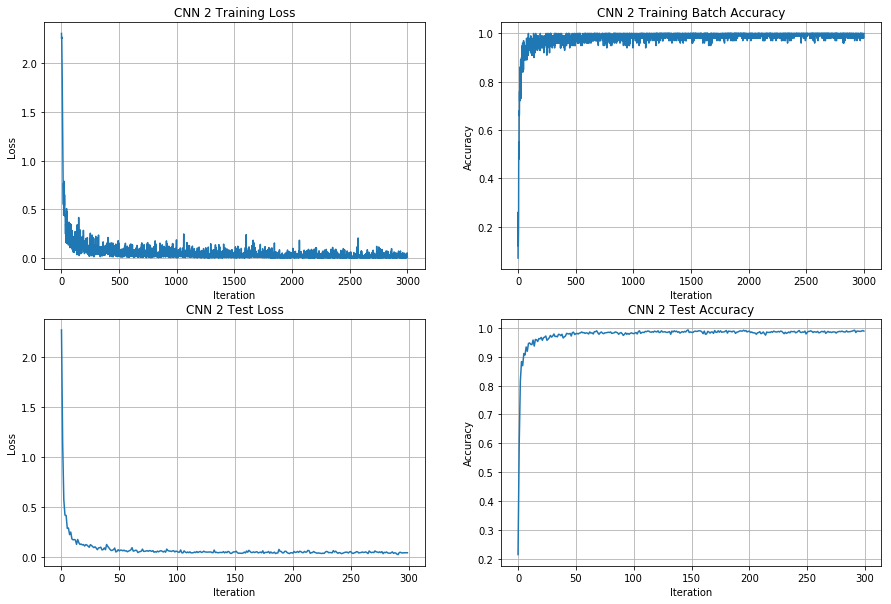

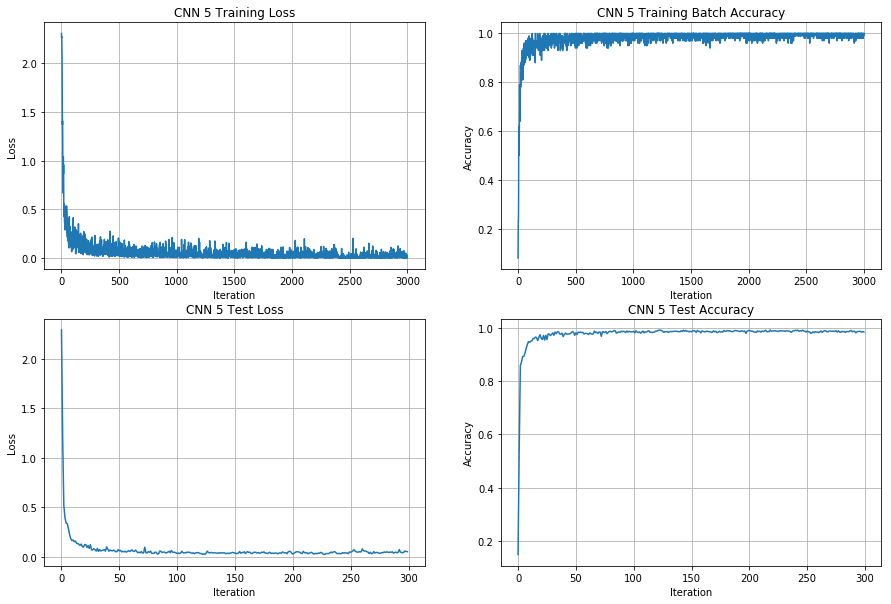

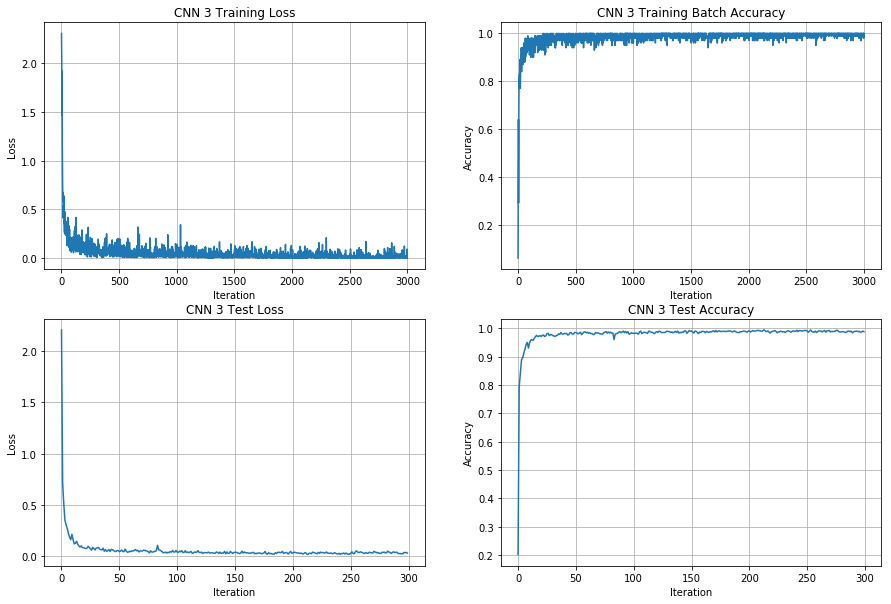

In [94]:
CNN_2_acc, CNN_2_time = cnn_train_test(CNN_2,2, 'CNN 2')
CNN_3_acc, CNN_3_time = cnn_train_test(CNN_3,3, 'CNN 5')
CNN_5_acc, CNN_5_time = cnn_train_test(CNN_5,5, 'CNN 3')

In [ ]:
tf.reset_default_graph()

model = CNN_4(x_train, y_train, './CNN_4_logdir/', 0.001, 5, 100)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)
    
t0 = time.time()
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  

CNN_4_time = time.time() - t0

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    input_x_test = input_x_test[:, :, :,np.newaxis]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
CNN_4_acc = np.mean((all_preds==y_real)*1)

In [ ]:
print('depth = 3, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_1), CNN_1_acc, CNN_1_time))
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_2), CNN_2_acc, CNN_2_time))
print('depth = 5, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_3), CNN_3_acc, CNN_3_time))
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_4), CNN_4_acc, CNN_4_time))
print('depth = 3, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_5), CNN_5_acc, CNN_5_time))

### 5. Visualizing learned filters and activations (6 points)
It is sometimes useful to visualize what kind of filters a CNN have learned. One way to do so is to plot each filter of size [kernel_size $\times$ kerne_size]. 

- Once your CNN (in Question 6) is trained, access its filters via 'tf.get_collection' and plot them on a grid for each layer. What patterns do you observe, why?
- In addition, plot the activations of each layer for two images chosen from digit-classes '2' and '9'. Discuss your observations

Hint: 
+ Activations are for example the outputs of tf.layers.conv2D.
+ Use tf.get_collection to access the learned filters of each layers. For this, you need to know how they are named (which can be accessed by tf.trainable_variables among other means of doing so).

The plotted feature maps and learned filters should be plotted in the same way as in the images bellow. (left: Feature Maps, right: learned Filters)

![Examples of activation maps (left), and learned features (right))](im.png)

In [ ]:
tf.trainable_variables()

In [ ]:
import math
import matplotlib.gridspec as gridspec

def getActivations(model, image, layer):
    units = sess.run(layer, feed_dict={model.im: image})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    n_columns = int(round(np.sqrt(filters)+0.4,0))
    n_rows = math.ceil(filters / n_columns) + 1
    plt.figure(1, figsize=(4.5,6))
    gs = gridspec.GridSpec(n_rows, n_columns,wspace=0.025, hspace=0.025)
    
    for i in range(filters):
        ax1 = plt.subplot(gs[i])
        ax1.imshow(units[0,:,:,i], cmap="gray")
        ax1.axis('off')
    plt.show()

In [ ]:
print("INPUT EXEMPLAR")
plt.figure(1, figsize=(1.5,1.5))
plt.imshow(x_test[20], cmap="gray")
plt.axis('off')
plt.show()
print("FIRST HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden1)
print("SECOND HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden2)
print("THIRD HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden3)
print("FOURTH HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden4)

In [ ]:
print("INPUT EXEMPLAR")
plt.figure(1, figsize=(1.5,1.5))
plt.imshow(x_test[22], cmap="gray")
plt.axis('off')
plt.show()
print("FIRST HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden1)
print("SECOND HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden2)
print("THIRD HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden3)
print("FOURTH HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden4)

In [ ]:
def plot_filters(filters):
    num_filters = filters.shape[3]
    n_columns = int(round(np.sqrt(num_filters)+0.4,0))
    n_rows = math.ceil(num_filters/n_columns) + 1
    fig = plt.figure(1, figsize=(4.5, 6))
    gs = gridspec.GridSpec(n_rows, n_columns,wspace=0.025, hspace = 0.025)

    for i in range(num_filters):
        ax1 = plt.subplot(gs[i])
        ax1.imshow(filters[:, :, 0, i], cmap="gray", aspect='equal')
        ax1.axis('off')
    plt.show()

for i in range(1, 5):
    print("FILTERS OF LAYER {}".format(i))
    layer = tf.get_collection(tf.GraphKeys.VARIABLES, 'CNN/conv2d{}/kernel:0'.format(i))[0]
    w1 = sess.run(layer)
    plot_filters(w1)


In [125]:
sess.close()

### 6. Multi Task Learning (12 points)

This question concerns the practice of multi-task learning (MTL). 
The aim of multi task learning is to leverage two (or more) related tasks in the learning process with the hope that leanring one task aids perfromance in learning the other task(s) and thus improves predicitve power for at least one (ideally all) of the tasks. 

There are two distinct flavours of MTL: Hard parameter  sharing and soft parameter sharing. We will be focusing on the former in this question.
Hard paramter sharing occurs when two tasks share a common network which then splits into task specific paths (e.g. a series of convolutional layers with two paths of dense layers for two seperate tasks). 

In this question, you will explore the FASHION MNIST dataset and be coding up your own MTL model and considering the pros and cons of MTL compared to single task learning. 

We have written the code to pre-load this dataset and split it into two related tasks for you:

- Task 1 - Clothing item 10 class classification (e.g. shoes, t-shirts etc) across 10 goups - $ y \in \mathbb{R^{10}} $
- Task 2 - Clothing group three class classification - predicitng whether a viewed clothing image belongs to one of three groups - $ y \in \mathbb{R^{3}} $
    - These groups are shoes (Sandal, Sneaker and Ankle Boot),  Gendered (Dress, Shirt and Bag) and Uni-Sex (T-shirt, Trouser, Pullover and Coat). 


#### Note : Alternativley use the tf.nn module. 

#### Note  : We advise the use of only a single epoch for this question for the sake of computation time.  However, if you want to utilise additional epochs feel free to do so just be aware of the longer training time and be consistent over all networks. 

In [156]:
"""
Code for loading the dataset
"""
import keras.datasets.fashion_mnist as fashion_mnist
from keras.utils import to_categorical

def load_data(): 
    # train_X: (60000, 28, 28)
    # train_y: (60000,)
    # test_X: (10000, 28, 28)
    # test_y: (10000,)
    (train_X, train_y_1), (test_X, test_y_1) = fashion_mnist.load_data()
    n_class_1 = 10
    # map to new label
    train_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in train_y_1)  
    test_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in test_y_1)
    n_class_2 = 3
    # train_X: (60000, 28, 28, 1)
    # test_X: (10000, 28, 28, 1)
    # train_y: (60000, n_class = 10)
    # test_y: (10000, n_class = 3)
    train_X = np.expand_dims(train_X, axis=3)
    test_X = np.expand_dims(test_X, axis=3)
    train_y_1 = to_categorical(train_y_1, n_class_1)
    test_y_1 = to_categorical(test_y_1, n_class_1)
    train_y_2 = to_categorical(train_y_2, n_class_2)
    test_y_2 = to_categorical(test_y_2, n_class_2)
    return train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2


x_train_fashion, y_train_1, y_train_2, x_test_fashion, y_test_1, y_test_2 = load_data()

#### Task 6.1

In this question you will construct two seperate networks of identical structure (excpet the logits and pred layers) one for each of the two tasks.

In other words, create a network for item classification and a network for item group classification. 


Complete the Task_1_NN and Task_2_NN below. These single task networks will form the basis of your work in this question. 

For the sake of convieience, we will use the same CNN filters as Question 4 - $[32, 64, 128]$. However our kernel size will be 3 $\times$ 3 and a stride of 1 for all convolutional layers. Maxpooling layers will also need to be implemented after the first and second convolutional layers. These maxpooling layers have a kernel size of two and a stride of 2. 

After the final convolution, flatten the outputs and pass them to dense layers $[3136, 1024, 100 , N]$ where $N$ is the number of outputs required (10 or 3). 

As with Question 4, the function 'create_model' to be cpomplemted defines the class variables:
 - Task 1
     - self.logits $\in \mathbb{R^{10}}$ containing the output without activation of the last __<font color='red'>fully connected (i.e. dense) layer</font>.__ 
     - self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.
 - Task 2
      - self.logits $\in \mathbb{R^{3}}$ containing the output without activation of the last __<font color='red'>fully connected layer</font>.__ 
      - self.preds $\in \mathbb{R^{3}}$ containing posterior probabilities.
      
The method definitons remain the same  as in previous questions. 
      
      
#### Note: We advise you save the number of parameters and accuracy of the models in order to save time later. 

In [157]:
class Task_1_NN():
    def __init__(self, x_train, y_train_1,  output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_1 = y_train_1
        self.m = x_train.shape[0]
        self.n_output_1 = y_train_1.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_1 = tf.placeholder(tf.float32, (None, self.n_output_1), "y_1")
    
    def create_model(self):            
        with tf.variable_scope("Task_1", reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.X, filters= 32, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.pool1 = tf.layers.max_pooling2d(self.hidden1, pool_size=2, strides=2)

            self.hidden2 = tf.layers.conv2d(self.pool1, filters= 64, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.pool2 = tf.layers.max_pooling2d(self.hidden2, pool_size=2, strides=2)

            self.hidden3 = tf.layers.conv2d(self.pool2, filters= 128, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d3') 
            self.pool3 = tf.layers.max_pooling2d(self.hidden3, pool_size=2, strides=2)
            
            flattened = tf.layers.flatten(self.pool3)
            # We feed it to a dense network to adquire the logits
            self.dense1 = tf.layers.dense(flattened, 3136)
            self.dense2 = tf.layers.dense(self.dense1, 1024)
            self.dense3 = tf.layers.dense(self.dense2, 100)
            self.output = tf.layers.dense(self.dense3, 10)

            
            ######### Complete the function ######### 
            self.logits = self.output
            self.pred_1 = tf.nn.softmax(self.logits) # This allows the model to be run and generate predictions
            #########################################
                
                
                
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_1, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss_task_1) 
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_task_1, var_list=self.model_vars)
            


In [128]:
class Task_2_NN():
    def __init__(self, x_train, y_train_2,  output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_2 = y_train_2
        self.m = x_train.shape[0]
        self.n_output_2 = y_train_2.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_2 = tf.placeholder(tf.float32, (None, self.n_output_2), "y_2")
    
    def create_model(self):            
        with tf.variable_scope("Task_2", reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.X, filters= 32, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.pool1 = tf.layers.max_pooling2d(self.hidden1, pool_size=2, strides=2)

            self.hidden2 = tf.layers.conv2d(self.pool1, filters= 64, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.pool2 = tf.layers.max_pooling2d(self.hidden2, pool_size=2, strides=2)

            self.hidden3 = tf.layers.conv2d(self.pool2, filters= 128, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d3') 
            self.pool3 = tf.layers.max_pooling2d(self.hidden3, pool_size=2, strides=2)
            
            flattened = tf.layers.flatten(self.pool3)
            # We feed it to a dense network to adquire the logits
            self.dense1 = tf.layers.dense(flattened, 3136)
            self.dense2 = tf.layers.dense(self.dense1, 1024)
            self.dense3 = tf.layers.dense(self.dense2, 100)
            self.output = tf.layers.dense(self.dense3, 3)

            
            ######### Complete the function ######### 
            self.logits = self.output
            self.pred_2 = tf.nn.softmax(self.logits) # This allows the model to be run and generate predictions
            #########################################
                
                
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_2, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss_task_2) 
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_task_2, var_list=self.model_vars)

#### Now train and test Task 1:

In [158]:
import time
tf.reset_default_graph()


model_1 = Task_1_NN(x_train_fashion, y_train_1, './Task1_logdir/', 0.001, 2, 10)            
model_1.create_model()     

model_1.compute_loss()
model_1.optimizer()   

model_1.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model_1.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model_1.output_dir):
    os.makedirs(model_1.output_dir)  

"""
Train
"""

task1_train_loss = []
task1_train_acc = []
task1_test_loss = []
task1_test_acc = []

for epoch in range(model_1.nb_epochs):
    randomize = np.arange(x_train_fashion.shape[0])
    np.random.shuffle(randomize)
    x_in = model_1.x_train[randomize,:]
    y_in_1 = model_1.y_train_1[randomize,:]
    for i in range(model_1.nb_iterations):
        input_x_train = x_in[i*model_1.batch_size: (i+1)*model_1.batch_size]
        input_y_train_1 = y_in_1[i*model_1.batch_size: (i+1)*model_1.batch_size]
        _ , preds_1, loss_1, loss_summ = sess.run([model_1.trainer, model_1.pred_1,  model_1.loss_task_1, model_1.loss_summ], 
                                 feed_dict={model_1.X: input_x_train, 
                                            model_1.y_1: input_y_train_1})
        
        task1_train_loss.append(loss_1)
        if i % 10 == 0:
            test_loss, test_preds = sess.run([model_1.loss_task_1, model_1.pred_1] , feed_dict={model_1.X: x_test_fashion, model_1.y_1: y_test_1})
            test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test_1, axis=1)) * 1)
            task1_test_loss.append(test_loss)
            task1_test_acc.append(test_acc)

        y_preds_1 = np.argmax(preds_1, axis=1)
        y_real_1 = np.argmax(input_y_train_1, axis=1)
        acc_train_1 = np.mean((y_preds_1==y_real_1)*1)
        task1_train_acc.append(acc_train_1)
        print('Epoch %d, Iteration %d, loss_1 %.3f,  batch accuracy_1 %.3f' %(epoch, i, loss_1,acc_train_1))
        writer.add_summary(loss_summ, epoch * model_1.nb_iterations + i)
    saver.save(sess, model_1.output_dir, global_step=epoch) 
end = time.time()

ResourceExhaustedError: OOM when allocating tensor with shape[10000,32,26,26] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Task_1/conv2d1/Conv2D (defined at <ipython-input-157-73b693bb30b1>:20)  = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_X_0_0/_19, Task_1/conv2d1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/Mean/_25}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_136_loss/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Task_1/conv2d1/Conv2D', defined at:
  File "c:\users\alton\appdata\local\programs\python\python36\Lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\alton\appdata\local\programs\python\python36\Lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 456, in _handle_events
    self._handle_recv()
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 486, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-158-38907058761d>", line 6, in <module>
    model_1.create_model()
  File "<ipython-input-157-73b693bb30b1>", line 20, in create_model
    self.hidden1 = tf.layers.conv2d(self.X, filters= 32, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d1')
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\layers\convolutional.py", line 417, in conv2d
    return layer.apply(inputs)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 817, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\layers\base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 757, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 194, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 204, in __call__
    name=self.name)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1044, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "c:\users\alton\environments\tensorflowgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,32,26,26] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Task_1/conv2d1/Conv2D (defined at <ipython-input-157-73b693bb30b1>:20)  = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_X_0_0/_19, Task_1/conv2d1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/Mean/_25}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_136_loss/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [109]:
"""
Test
"""


batch_size_test = 20
nb_test_points = x_test_fashion.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds_1 = []
for i in range(nb_iterations):
    input_x_test = x_test_fashion[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_1 = sess.run(model_1.pred_1, 
                             feed_dict={model_1.X: input_x_test})
    preds_1.append(np.argmax(preds_test_1, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test_fashion[i*batch_size_test: -1]
        preds_test_1= sess.run(model_1.pred_1, 
                             feed_dict={model_1.X: input_x_test})
        preds_1.append(np.argmax(preds_test_1, axis=1))
all_preds_1 = np.concatenate(preds_1, axis =0)
y_real_1 = np.argmax(y_test_1, axis=1)
print(all_preds_1)
print(y_real_1)
acc_test_1 = np.mean((all_preds_1==y_real_1)*1)
print('Test accuracy - task 1 achieved: %.3f' %acc_test_1)

[9 2 1 ... 8 1 7]
[9 2 1 ... 8 1 5]
Test accuracy - task 1 achieved: 0.748


In [ ]:
sess.close()

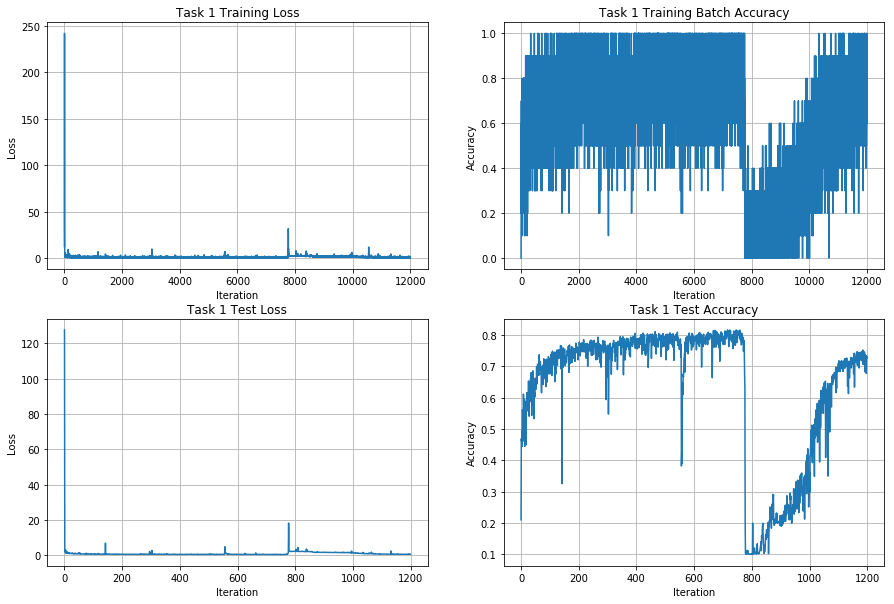

In [110]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.plot(task1_train_loss)
ax1.grid()
ax1.title.set_text("Task 1 Training Loss")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")

ax2.plot(task1_train_acc)
ax2.grid()
ax2.title.set_text("Task 1 Training Batch Accuracy")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")

ax3.plot(task1_test_loss)
ax3.grid()
ax3.title.set_text("Task 1 Test Loss")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4.plot(task1_test_acc)
ax4.grid()
ax4.title.set_text("Task 1 Test Accuracy")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Accuracy")

plt.show()

#### Now train and test Task 2

In [111]:
tf.reset_default_graph()

model_2 = Task_2_NN(x_train_fashion, y_train_2, './Task2_logdir/', 0.001, 2, 10)            
model_2.create_model()     

model_2.compute_loss()
model_2.optimizer()   

model_2.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model_2.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model_2.output_dir):
    os.makedirs(model_2.output_dir)

"""
Train
"""

task2_train_loss = []
task2_train_acc = []
task2_test_loss = []
task2_test_acc = []
for epoch in range(model_2.nb_epochs):
    randomize = np.arange(x_train_fashion.shape[0])
    np.random.shuffle(randomize)
    x_in = model_2.x_train[randomize,:]
    y_in_2 = model_2.y_train_2[randomize,:]
    for i in range(model_2.nb_iterations):
        input_x_train = x_in[i*model_2.batch_size: (i+1)*model_2.batch_size]
        input_y_train_2 = y_in_2[i*model_2.batch_size: (i+1)*model_2.batch_size]
        _ , preds_2, loss_2, loss_sum = sess.run([model_2.trainer, model_2.pred_2,  model_2.loss_task_2, model_2.loss_summ], 
                                 feed_dict={model_2.X: input_x_train, 
                                            model_2.y_2: input_y_train_2})
        
        task2_train_loss.append(loss_2)
        if i % 10 == 0:
            test_loss, test_preds = sess.run([model_2.loss_task_2, model_2.pred_2] , feed_dict={model_2.X: x_test_fashion, model_2.y_2: y_test_2})
            test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test_2, axis=1)) * 1)
            task2_test_loss.append(test_loss)
            task2_test_acc.append(test_acc)

       
        y_preds_2 = np.argmax(preds_2, axis=1)
        y_real_2 = np.argmax(input_y_train_2, axis=1)
        acc_train_2 = np.mean((y_preds_2==y_real_2)*1)
        task2_train_acc.append(acc_train_2)

        print('Epoch %d, Iteration %d, loss_2 %.3f, batch accuracy_2 %.3f' %(epoch, i, loss_2,acc_train_2))
        writer.add_summary(loss_sum, epoch * model_2.nb_iterations + i)
    saver.save(sess, model_2.output_dir, global_step=epoch) 

Epoch 0, Iteration 0, loss_2 2.051, batch accuracy_2 0.300
Epoch 0, Iteration 1, loss_2 342.951, batch accuracy_2 0.200
Epoch 0, Iteration 2, loss_2 69.272, batch accuracy_2 0.600
Epoch 0, Iteration 3, loss_2 55.661, batch accuracy_2 0.300
Epoch 0, Iteration 4, loss_2 25.096, batch accuracy_2 0.800
Epoch 0, Iteration 5, loss_2 22.705, batch accuracy_2 0.800
Epoch 0, Iteration 6, loss_2 17.406, batch accuracy_2 0.600
Epoch 0, Iteration 7, loss_2 2.743, batch accuracy_2 0.800
Epoch 0, Iteration 8, loss_2 2.160, batch accuracy_2 0.800
Epoch 0, Iteration 9, loss_2 11.755, batch accuracy_2 0.500
Epoch 0, Iteration 10, loss_2 7.452, batch accuracy_2 0.500
Epoch 0, Iteration 11, loss_2 2.988, batch accuracy_2 0.700
Epoch 0, Iteration 12, loss_2 2.539, batch accuracy_2 0.500
Epoch 0, Iteration 13, loss_2 1.399, batch accuracy_2 0.700
Epoch 0, Iteration 14, loss_2 0.322, batch accuracy_2 0.900
Epoch 0, Iteration 15, loss_2 0.867, batch accuracy_2 0.600
Epoch 0, Iteration 16, loss_2 2.252, batch

Epoch 0, Iteration 140, loss_2 0.636, batch accuracy_2 0.600
Epoch 0, Iteration 141, loss_2 0.327, batch accuracy_2 0.800
Epoch 0, Iteration 142, loss_2 0.186, batch accuracy_2 1.000
Epoch 0, Iteration 143, loss_2 0.345, batch accuracy_2 0.800
Epoch 0, Iteration 144, loss_2 0.426, batch accuracy_2 0.800
Epoch 0, Iteration 145, loss_2 0.468, batch accuracy_2 0.800
Epoch 0, Iteration 146, loss_2 0.621, batch accuracy_2 0.500
Epoch 0, Iteration 147, loss_2 0.345, batch accuracy_2 0.900
Epoch 0, Iteration 148, loss_2 0.268, batch accuracy_2 0.700
Epoch 0, Iteration 149, loss_2 0.616, batch accuracy_2 0.900
Epoch 0, Iteration 150, loss_2 0.781, batch accuracy_2 0.600
Epoch 0, Iteration 151, loss_2 0.358, batch accuracy_2 0.900
Epoch 0, Iteration 152, loss_2 0.264, batch accuracy_2 1.000
Epoch 0, Iteration 153, loss_2 0.669, batch accuracy_2 0.800
Epoch 0, Iteration 154, loss_2 0.727, batch accuracy_2 0.500
Epoch 0, Iteration 155, loss_2 0.316, batch accuracy_2 0.800
Epoch 0, Iteration 156, 

Epoch 0, Iteration 276, loss_2 0.273, batch accuracy_2 0.700
Epoch 0, Iteration 277, loss_2 0.356, batch accuracy_2 0.900
Epoch 0, Iteration 278, loss_2 0.526, batch accuracy_2 0.700
Epoch 0, Iteration 279, loss_2 0.510, batch accuracy_2 0.600
Epoch 0, Iteration 280, loss_2 0.396, batch accuracy_2 0.900
Epoch 0, Iteration 281, loss_2 0.445, batch accuracy_2 0.800
Epoch 0, Iteration 282, loss_2 0.454, batch accuracy_2 0.800
Epoch 0, Iteration 283, loss_2 0.286, batch accuracy_2 1.000
Epoch 0, Iteration 284, loss_2 0.354, batch accuracy_2 0.800
Epoch 0, Iteration 285, loss_2 0.346, batch accuracy_2 0.800
Epoch 0, Iteration 286, loss_2 0.883, batch accuracy_2 0.600
Epoch 0, Iteration 287, loss_2 0.363, batch accuracy_2 0.800
Epoch 0, Iteration 288, loss_2 0.653, batch accuracy_2 0.700
Epoch 0, Iteration 289, loss_2 0.204, batch accuracy_2 0.900
Epoch 0, Iteration 290, loss_2 0.553, batch accuracy_2 0.600
Epoch 0, Iteration 291, loss_2 0.325, batch accuracy_2 0.800
Epoch 0, Iteration 292, 

Epoch 0, Iteration 416, loss_2 0.461, batch accuracy_2 0.800
Epoch 0, Iteration 417, loss_2 0.255, batch accuracy_2 0.900
Epoch 0, Iteration 418, loss_2 0.478, batch accuracy_2 0.900
Epoch 0, Iteration 419, loss_2 0.178, batch accuracy_2 1.000
Epoch 0, Iteration 420, loss_2 0.798, batch accuracy_2 0.500
Epoch 0, Iteration 421, loss_2 0.617, batch accuracy_2 0.900
Epoch 0, Iteration 422, loss_2 0.497, batch accuracy_2 0.700
Epoch 0, Iteration 423, loss_2 0.319, batch accuracy_2 0.800
Epoch 0, Iteration 424, loss_2 0.674, batch accuracy_2 0.600
Epoch 0, Iteration 425, loss_2 0.102, batch accuracy_2 1.000
Epoch 0, Iteration 426, loss_2 0.304, batch accuracy_2 0.900
Epoch 0, Iteration 427, loss_2 0.201, batch accuracy_2 0.900
Epoch 0, Iteration 428, loss_2 0.464, batch accuracy_2 0.700
Epoch 0, Iteration 429, loss_2 0.403, batch accuracy_2 0.800
Epoch 0, Iteration 430, loss_2 0.523, batch accuracy_2 0.800
Epoch 0, Iteration 431, loss_2 0.322, batch accuracy_2 0.800
Epoch 0, Iteration 432, 

Epoch 0, Iteration 556, loss_2 0.082, batch accuracy_2 1.000
Epoch 0, Iteration 557, loss_2 0.410, batch accuracy_2 0.800
Epoch 0, Iteration 558, loss_2 0.496, batch accuracy_2 0.600
Epoch 0, Iteration 559, loss_2 0.480, batch accuracy_2 0.700
Epoch 0, Iteration 560, loss_2 2.515, batch accuracy_2 0.500
Epoch 0, Iteration 561, loss_2 1.549, batch accuracy_2 0.300
Epoch 0, Iteration 562, loss_2 0.181, batch accuracy_2 1.000
Epoch 0, Iteration 563, loss_2 0.236, batch accuracy_2 0.800
Epoch 0, Iteration 564, loss_2 0.282, batch accuracy_2 0.800
Epoch 0, Iteration 565, loss_2 0.589, batch accuracy_2 0.800
Epoch 0, Iteration 566, loss_2 0.497, batch accuracy_2 0.700
Epoch 0, Iteration 567, loss_2 0.391, batch accuracy_2 0.800
Epoch 0, Iteration 568, loss_2 0.193, batch accuracy_2 1.000
Epoch 0, Iteration 569, loss_2 1.178, batch accuracy_2 0.600
Epoch 0, Iteration 570, loss_2 1.399, batch accuracy_2 0.500
Epoch 0, Iteration 571, loss_2 3.546, batch accuracy_2 0.400
Epoch 0, Iteration 572, 

Epoch 0, Iteration 700, loss_2 0.266, batch accuracy_2 1.000
Epoch 0, Iteration 701, loss_2 0.369, batch accuracy_2 0.800
Epoch 0, Iteration 702, loss_2 0.353, batch accuracy_2 0.800
Epoch 0, Iteration 703, loss_2 0.287, batch accuracy_2 0.900
Epoch 0, Iteration 704, loss_2 0.464, batch accuracy_2 0.800
Epoch 0, Iteration 705, loss_2 0.290, batch accuracy_2 0.800
Epoch 0, Iteration 706, loss_2 0.584, batch accuracy_2 0.600
Epoch 0, Iteration 707, loss_2 0.597, batch accuracy_2 0.500
Epoch 0, Iteration 708, loss_2 0.503, batch accuracy_2 0.700
Epoch 0, Iteration 709, loss_2 0.320, batch accuracy_2 0.800
Epoch 0, Iteration 710, loss_2 0.261, batch accuracy_2 0.900
Epoch 0, Iteration 711, loss_2 0.125, batch accuracy_2 1.000
Epoch 0, Iteration 712, loss_2 0.240, batch accuracy_2 0.900
Epoch 0, Iteration 713, loss_2 0.289, batch accuracy_2 0.900
Epoch 0, Iteration 714, loss_2 0.120, batch accuracy_2 1.000
Epoch 0, Iteration 715, loss_2 0.535, batch accuracy_2 0.600
Epoch 0, Iteration 716, 

Epoch 0, Iteration 847, loss_2 0.753, batch accuracy_2 0.800
Epoch 0, Iteration 848, loss_2 0.336, batch accuracy_2 0.900
Epoch 0, Iteration 849, loss_2 13.244, batch accuracy_2 0.400
Epoch 0, Iteration 850, loss_2 2.452, batch accuracy_2 0.600
Epoch 0, Iteration 851, loss_2 9.104, batch accuracy_2 0.300
Epoch 0, Iteration 852, loss_2 17.395, batch accuracy_2 0.300
Epoch 0, Iteration 853, loss_2 3.940, batch accuracy_2 0.800
Epoch 0, Iteration 854, loss_2 17.039, batch accuracy_2 0.000
Epoch 0, Iteration 855, loss_2 0.083, batch accuracy_2 0.900
Epoch 0, Iteration 856, loss_2 1.518, batch accuracy_2 0.700
Epoch 0, Iteration 857, loss_2 50.033, batch accuracy_2 0.300
Epoch 0, Iteration 858, loss_2 14.969, batch accuracy_2 0.600
Epoch 0, Iteration 859, loss_2 2.076, batch accuracy_2 0.700
Epoch 0, Iteration 860, loss_2 1.032, batch accuracy_2 0.700
Epoch 0, Iteration 861, loss_2 1.773, batch accuracy_2 0.600
Epoch 0, Iteration 862, loss_2 0.577, batch accuracy_2 0.500
Epoch 0, Iteration 

Epoch 0, Iteration 990, loss_2 0.363, batch accuracy_2 0.800
Epoch 0, Iteration 991, loss_2 0.519, batch accuracy_2 0.700
Epoch 0, Iteration 992, loss_2 0.970, batch accuracy_2 0.500
Epoch 0, Iteration 993, loss_2 0.690, batch accuracy_2 0.800
Epoch 0, Iteration 994, loss_2 0.681, batch accuracy_2 0.700
Epoch 0, Iteration 995, loss_2 0.507, batch accuracy_2 0.800
Epoch 0, Iteration 996, loss_2 0.399, batch accuracy_2 0.800
Epoch 0, Iteration 997, loss_2 0.689, batch accuracy_2 0.500
Epoch 0, Iteration 998, loss_2 0.383, batch accuracy_2 0.900
Epoch 0, Iteration 999, loss_2 1.550, batch accuracy_2 0.400
Epoch 0, Iteration 1000, loss_2 0.379, batch accuracy_2 1.000
Epoch 0, Iteration 1001, loss_2 0.614, batch accuracy_2 0.500
Epoch 0, Iteration 1002, loss_2 0.514, batch accuracy_2 0.800
Epoch 0, Iteration 1003, loss_2 0.431, batch accuracy_2 0.800
Epoch 0, Iteration 1004, loss_2 0.378, batch accuracy_2 1.000
Epoch 0, Iteration 1005, loss_2 0.724, batch accuracy_2 0.500
Epoch 0, Iteration

Epoch 0, Iteration 1126, loss_2 0.463, batch accuracy_2 0.800
Epoch 0, Iteration 1127, loss_2 0.542, batch accuracy_2 0.800
Epoch 0, Iteration 1128, loss_2 0.570, batch accuracy_2 0.600
Epoch 0, Iteration 1129, loss_2 0.411, batch accuracy_2 0.700
Epoch 0, Iteration 1130, loss_2 0.634, batch accuracy_2 0.600
Epoch 0, Iteration 1131, loss_2 0.514, batch accuracy_2 0.600
Epoch 0, Iteration 1132, loss_2 0.289, batch accuracy_2 0.800
Epoch 0, Iteration 1133, loss_2 0.698, batch accuracy_2 0.600
Epoch 0, Iteration 1134, loss_2 0.357, batch accuracy_2 0.800
Epoch 0, Iteration 1135, loss_2 0.345, batch accuracy_2 0.800
Epoch 0, Iteration 1136, loss_2 0.474, batch accuracy_2 0.400
Epoch 0, Iteration 1137, loss_2 0.879, batch accuracy_2 0.600
Epoch 0, Iteration 1138, loss_2 0.415, batch accuracy_2 0.800
Epoch 0, Iteration 1139, loss_2 0.199, batch accuracy_2 0.900
Epoch 0, Iteration 1140, loss_2 0.736, batch accuracy_2 0.500
Epoch 0, Iteration 1141, loss_2 0.574, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 1265, loss_2 1.092, batch accuracy_2 0.500
Epoch 0, Iteration 1266, loss_2 0.304, batch accuracy_2 0.900
Epoch 0, Iteration 1267, loss_2 1.076, batch accuracy_2 0.500
Epoch 0, Iteration 1268, loss_2 0.561, batch accuracy_2 0.600
Epoch 0, Iteration 1269, loss_2 1.053, batch accuracy_2 0.600
Epoch 0, Iteration 1270, loss_2 0.423, batch accuracy_2 0.600
Epoch 0, Iteration 1271, loss_2 0.557, batch accuracy_2 0.700
Epoch 0, Iteration 1272, loss_2 0.484, batch accuracy_2 0.400
Epoch 0, Iteration 1273, loss_2 0.498, batch accuracy_2 0.500
Epoch 0, Iteration 1274, loss_2 0.491, batch accuracy_2 0.800
Epoch 0, Iteration 1275, loss_2 0.528, batch accuracy_2 0.400
Epoch 0, Iteration 1276, loss_2 0.346, batch accuracy_2 1.000
Epoch 0, Iteration 1277, loss_2 0.518, batch accuracy_2 0.600
Epoch 0, Iteration 1278, loss_2 0.868, batch accuracy_2 0.600
Epoch 0, Iteration 1279, loss_2 0.568, batch accuracy_2 0.500
Epoch 0, Iteration 1280, loss_2 0.550, batch accuracy_2 0.400
Epoch 0,

Epoch 0, Iteration 1407, loss_2 0.619, batch accuracy_2 0.600
Epoch 0, Iteration 1408, loss_2 0.891, batch accuracy_2 0.300
Epoch 0, Iteration 1409, loss_2 0.348, batch accuracy_2 0.800
Epoch 0, Iteration 1410, loss_2 0.318, batch accuracy_2 1.000
Epoch 0, Iteration 1411, loss_2 0.519, batch accuracy_2 0.600
Epoch 0, Iteration 1412, loss_2 0.635, batch accuracy_2 0.600
Epoch 0, Iteration 1413, loss_2 0.289, batch accuracy_2 1.000
Epoch 0, Iteration 1414, loss_2 0.832, batch accuracy_2 0.200
Epoch 0, Iteration 1415, loss_2 0.549, batch accuracy_2 0.600
Epoch 0, Iteration 1416, loss_2 0.562, batch accuracy_2 0.800
Epoch 0, Iteration 1417, loss_2 0.446, batch accuracy_2 0.500
Epoch 0, Iteration 1418, loss_2 0.426, batch accuracy_2 0.700
Epoch 0, Iteration 1419, loss_2 0.649, batch accuracy_2 0.400
Epoch 0, Iteration 1420, loss_2 0.538, batch accuracy_2 0.600
Epoch 0, Iteration 1421, loss_2 0.519, batch accuracy_2 0.700
Epoch 0, Iteration 1422, loss_2 0.470, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 1540, loss_2 0.529, batch accuracy_2 0.700
Epoch 0, Iteration 1541, loss_2 0.364, batch accuracy_2 0.800
Epoch 0, Iteration 1542, loss_2 0.268, batch accuracy_2 0.900
Epoch 0, Iteration 1543, loss_2 0.353, batch accuracy_2 0.800
Epoch 0, Iteration 1544, loss_2 0.275, batch accuracy_2 0.800
Epoch 0, Iteration 1545, loss_2 0.142, batch accuracy_2 1.000
Epoch 0, Iteration 1546, loss_2 0.926, batch accuracy_2 0.600
Epoch 0, Iteration 1547, loss_2 0.302, batch accuracy_2 0.800
Epoch 0, Iteration 1548, loss_2 0.781, batch accuracy_2 0.600
Epoch 0, Iteration 1549, loss_2 0.658, batch accuracy_2 0.700
Epoch 0, Iteration 1550, loss_2 0.571, batch accuracy_2 0.800
Epoch 0, Iteration 1551, loss_2 0.432, batch accuracy_2 0.800
Epoch 0, Iteration 1552, loss_2 0.344, batch accuracy_2 0.900
Epoch 0, Iteration 1553, loss_2 1.372, batch accuracy_2 0.500
Epoch 0, Iteration 1554, loss_2 0.832, batch accuracy_2 0.600
Epoch 0, Iteration 1555, loss_2 0.660, batch accuracy_2 0.700
Epoch 0,

Epoch 0, Iteration 1674, loss_2 0.633, batch accuracy_2 0.800
Epoch 0, Iteration 1675, loss_2 0.550, batch accuracy_2 0.800
Epoch 0, Iteration 1676, loss_2 1.036, batch accuracy_2 0.400
Epoch 0, Iteration 1677, loss_2 0.333, batch accuracy_2 0.900
Epoch 0, Iteration 1678, loss_2 0.370, batch accuracy_2 0.700
Epoch 0, Iteration 1679, loss_2 0.399, batch accuracy_2 0.700
Epoch 0, Iteration 1680, loss_2 0.234, batch accuracy_2 0.900
Epoch 0, Iteration 1681, loss_2 0.420, batch accuracy_2 0.900
Epoch 0, Iteration 1682, loss_2 0.470, batch accuracy_2 0.800
Epoch 0, Iteration 1683, loss_2 0.378, batch accuracy_2 0.800
Epoch 0, Iteration 1684, loss_2 0.201, batch accuracy_2 0.900
Epoch 0, Iteration 1685, loss_2 0.608, batch accuracy_2 0.700
Epoch 0, Iteration 1686, loss_2 0.442, batch accuracy_2 0.700
Epoch 0, Iteration 1687, loss_2 0.495, batch accuracy_2 0.700
Epoch 0, Iteration 1688, loss_2 0.524, batch accuracy_2 0.600
Epoch 0, Iteration 1689, loss_2 0.440, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 1817, loss_2 0.322, batch accuracy_2 1.000
Epoch 0, Iteration 1818, loss_2 0.710, batch accuracy_2 0.600
Epoch 0, Iteration 1819, loss_2 0.212, batch accuracy_2 1.000
Epoch 0, Iteration 1820, loss_2 0.617, batch accuracy_2 0.600
Epoch 0, Iteration 1821, loss_2 0.427, batch accuracy_2 0.800
Epoch 0, Iteration 1822, loss_2 0.393, batch accuracy_2 0.800
Epoch 0, Iteration 1823, loss_2 0.470, batch accuracy_2 0.900
Epoch 0, Iteration 1824, loss_2 0.336, batch accuracy_2 0.800
Epoch 0, Iteration 1825, loss_2 0.563, batch accuracy_2 0.700
Epoch 0, Iteration 1826, loss_2 0.483, batch accuracy_2 0.700
Epoch 0, Iteration 1827, loss_2 0.332, batch accuracy_2 0.800
Epoch 0, Iteration 1828, loss_2 0.513, batch accuracy_2 0.500
Epoch 0, Iteration 1829, loss_2 0.363, batch accuracy_2 0.700
Epoch 0, Iteration 1830, loss_2 0.363, batch accuracy_2 0.800
Epoch 0, Iteration 1831, loss_2 1.573, batch accuracy_2 0.800
Epoch 0, Iteration 1832, loss_2 0.373, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 1960, loss_2 0.533, batch accuracy_2 0.800
Epoch 0, Iteration 1961, loss_2 0.557, batch accuracy_2 0.700
Epoch 0, Iteration 1962, loss_2 0.451, batch accuracy_2 0.800
Epoch 0, Iteration 1963, loss_2 0.448, batch accuracy_2 0.700
Epoch 0, Iteration 1964, loss_2 0.403, batch accuracy_2 0.700
Epoch 0, Iteration 1965, loss_2 0.484, batch accuracy_2 0.800
Epoch 0, Iteration 1966, loss_2 0.108, batch accuracy_2 1.000
Epoch 0, Iteration 1967, loss_2 0.369, batch accuracy_2 0.900
Epoch 0, Iteration 1968, loss_2 0.534, batch accuracy_2 0.700
Epoch 0, Iteration 1969, loss_2 0.188, batch accuracy_2 0.900
Epoch 0, Iteration 1970, loss_2 0.325, batch accuracy_2 1.000
Epoch 0, Iteration 1971, loss_2 0.282, batch accuracy_2 1.000
Epoch 0, Iteration 1972, loss_2 0.960, batch accuracy_2 0.800
Epoch 0, Iteration 1973, loss_2 0.473, batch accuracy_2 0.800
Epoch 0, Iteration 1974, loss_2 0.716, batch accuracy_2 0.600
Epoch 0, Iteration 1975, loss_2 0.664, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 2096, loss_2 0.282, batch accuracy_2 0.900
Epoch 0, Iteration 2097, loss_2 0.224, batch accuracy_2 0.900
Epoch 0, Iteration 2098, loss_2 0.341, batch accuracy_2 0.900
Epoch 0, Iteration 2099, loss_2 0.097, batch accuracy_2 1.000
Epoch 0, Iteration 2100, loss_2 0.407, batch accuracy_2 0.800
Epoch 0, Iteration 2101, loss_2 0.230, batch accuracy_2 0.900
Epoch 0, Iteration 2102, loss_2 0.464, batch accuracy_2 0.800
Epoch 0, Iteration 2103, loss_2 0.344, batch accuracy_2 0.900
Epoch 0, Iteration 2104, loss_2 0.257, batch accuracy_2 0.900
Epoch 0, Iteration 2105, loss_2 0.322, batch accuracy_2 0.800
Epoch 0, Iteration 2106, loss_2 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 2107, loss_2 0.410, batch accuracy_2 0.600
Epoch 0, Iteration 2108, loss_2 0.405, batch accuracy_2 0.800
Epoch 0, Iteration 2109, loss_2 0.518, batch accuracy_2 0.800
Epoch 0, Iteration 2110, loss_2 0.547, batch accuracy_2 0.700
Epoch 0, Iteration 2111, loss_2 0.513, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 2230, loss_2 0.434, batch accuracy_2 0.800
Epoch 0, Iteration 2231, loss_2 0.888, batch accuracy_2 0.900
Epoch 0, Iteration 2232, loss_2 0.239, batch accuracy_2 0.900
Epoch 0, Iteration 2233, loss_2 0.799, batch accuracy_2 0.700
Epoch 0, Iteration 2234, loss_2 0.919, batch accuracy_2 0.800
Epoch 0, Iteration 2235, loss_2 0.337, batch accuracy_2 0.800
Epoch 0, Iteration 2236, loss_2 0.224, batch accuracy_2 0.900
Epoch 0, Iteration 2237, loss_2 0.117, batch accuracy_2 1.000
Epoch 0, Iteration 2238, loss_2 0.642, batch accuracy_2 0.500
Epoch 0, Iteration 2239, loss_2 0.449, batch accuracy_2 0.800
Epoch 0, Iteration 2240, loss_2 0.248, batch accuracy_2 0.800
Epoch 0, Iteration 2241, loss_2 0.314, batch accuracy_2 0.700
Epoch 0, Iteration 2242, loss_2 0.285, batch accuracy_2 0.900
Epoch 0, Iteration 2243, loss_2 0.373, batch accuracy_2 0.800
Epoch 0, Iteration 2244, loss_2 0.374, batch accuracy_2 0.700
Epoch 0, Iteration 2245, loss_2 0.393, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 2376, loss_2 0.172, batch accuracy_2 1.000
Epoch 0, Iteration 2377, loss_2 0.738, batch accuracy_2 0.700
Epoch 0, Iteration 2378, loss_2 1.267, batch accuracy_2 0.600
Epoch 0, Iteration 2379, loss_2 0.674, batch accuracy_2 0.600
Epoch 0, Iteration 2380, loss_2 0.378, batch accuracy_2 0.800
Epoch 0, Iteration 2381, loss_2 0.387, batch accuracy_2 0.800
Epoch 0, Iteration 2382, loss_2 0.728, batch accuracy_2 0.500
Epoch 0, Iteration 2383, loss_2 0.399, batch accuracy_2 0.800
Epoch 0, Iteration 2384, loss_2 0.403, batch accuracy_2 0.800
Epoch 0, Iteration 2385, loss_2 0.405, batch accuracy_2 0.800
Epoch 0, Iteration 2386, loss_2 0.257, batch accuracy_2 1.000
Epoch 0, Iteration 2387, loss_2 0.311, batch accuracy_2 0.800
Epoch 0, Iteration 2388, loss_2 0.418, batch accuracy_2 0.800
Epoch 0, Iteration 2389, loss_2 0.181, batch accuracy_2 0.900
Epoch 0, Iteration 2390, loss_2 0.347, batch accuracy_2 0.900
Epoch 0, Iteration 2391, loss_2 0.546, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 2510, loss_2 0.312, batch accuracy_2 0.800
Epoch 0, Iteration 2511, loss_2 0.402, batch accuracy_2 0.900
Epoch 0, Iteration 2512, loss_2 0.321, batch accuracy_2 0.800
Epoch 0, Iteration 2513, loss_2 0.204, batch accuracy_2 0.900
Epoch 0, Iteration 2514, loss_2 0.380, batch accuracy_2 0.800
Epoch 0, Iteration 2515, loss_2 0.113, batch accuracy_2 1.000
Epoch 0, Iteration 2516, loss_2 0.274, batch accuracy_2 0.900
Epoch 0, Iteration 2517, loss_2 0.458, batch accuracy_2 0.700
Epoch 0, Iteration 2518, loss_2 0.361, batch accuracy_2 0.800
Epoch 0, Iteration 2519, loss_2 0.623, batch accuracy_2 0.900
Epoch 0, Iteration 2520, loss_2 0.407, batch accuracy_2 0.700
Epoch 0, Iteration 2521, loss_2 0.449, batch accuracy_2 0.700
Epoch 0, Iteration 2522, loss_2 0.541, batch accuracy_2 0.600
Epoch 0, Iteration 2523, loss_2 0.346, batch accuracy_2 0.800
Epoch 0, Iteration 2524, loss_2 0.403, batch accuracy_2 0.900
Epoch 0, Iteration 2525, loss_2 0.660, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 2655, loss_2 0.442, batch accuracy_2 0.900
Epoch 0, Iteration 2656, loss_2 0.258, batch accuracy_2 0.800
Epoch 0, Iteration 2657, loss_2 0.338, batch accuracy_2 1.000
Epoch 0, Iteration 2658, loss_2 0.271, batch accuracy_2 0.900
Epoch 0, Iteration 2659, loss_2 0.437, batch accuracy_2 0.800
Epoch 0, Iteration 2660, loss_2 0.430, batch accuracy_2 0.700
Epoch 0, Iteration 2661, loss_2 0.258, batch accuracy_2 0.900
Epoch 0, Iteration 2662, loss_2 0.445, batch accuracy_2 0.700
Epoch 0, Iteration 2663, loss_2 0.256, batch accuracy_2 0.900
Epoch 0, Iteration 2664, loss_2 0.252, batch accuracy_2 0.900
Epoch 0, Iteration 2665, loss_2 0.279, batch accuracy_2 0.900
Epoch 0, Iteration 2666, loss_2 0.248, batch accuracy_2 0.900
Epoch 0, Iteration 2667, loss_2 0.353, batch accuracy_2 0.800
Epoch 0, Iteration 2668, loss_2 0.274, batch accuracy_2 0.900
Epoch 0, Iteration 2669, loss_2 0.193, batch accuracy_2 0.900
Epoch 0, Iteration 2670, loss_2 0.414, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 2788, loss_2 0.303, batch accuracy_2 0.800
Epoch 0, Iteration 2789, loss_2 0.180, batch accuracy_2 1.000
Epoch 0, Iteration 2790, loss_2 0.442, batch accuracy_2 0.800
Epoch 0, Iteration 2791, loss_2 0.127, batch accuracy_2 1.000
Epoch 0, Iteration 2792, loss_2 0.270, batch accuracy_2 0.900
Epoch 0, Iteration 2793, loss_2 0.157, batch accuracy_2 1.000
Epoch 0, Iteration 2794, loss_2 0.648, batch accuracy_2 0.800
Epoch 0, Iteration 2795, loss_2 0.581, batch accuracy_2 0.800
Epoch 0, Iteration 2796, loss_2 0.397, batch accuracy_2 0.800
Epoch 0, Iteration 2797, loss_2 0.572, batch accuracy_2 0.500
Epoch 0, Iteration 2798, loss_2 0.405, batch accuracy_2 0.900
Epoch 0, Iteration 2799, loss_2 0.199, batch accuracy_2 1.000
Epoch 0, Iteration 2800, loss_2 0.343, batch accuracy_2 0.800
Epoch 0, Iteration 2801, loss_2 0.422, batch accuracy_2 0.900
Epoch 0, Iteration 2802, loss_2 0.295, batch accuracy_2 0.900
Epoch 0, Iteration 2803, loss_2 0.270, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 2933, loss_2 0.328, batch accuracy_2 0.800
Epoch 0, Iteration 2934, loss_2 0.098, batch accuracy_2 1.000
Epoch 0, Iteration 2935, loss_2 0.126, batch accuracy_2 0.900
Epoch 0, Iteration 2936, loss_2 0.385, batch accuracy_2 0.700
Epoch 0, Iteration 2937, loss_2 0.475, batch accuracy_2 0.700
Epoch 0, Iteration 2938, loss_2 0.358, batch accuracy_2 0.800
Epoch 0, Iteration 2939, loss_2 0.345, batch accuracy_2 0.700
Epoch 0, Iteration 2940, loss_2 0.335, batch accuracy_2 0.900
Epoch 0, Iteration 2941, loss_2 0.298, batch accuracy_2 0.900
Epoch 0, Iteration 2942, loss_2 0.200, batch accuracy_2 0.900
Epoch 0, Iteration 2943, loss_2 0.167, batch accuracy_2 0.900
Epoch 0, Iteration 2944, loss_2 0.133, batch accuracy_2 1.000
Epoch 0, Iteration 2945, loss_2 0.402, batch accuracy_2 0.700
Epoch 0, Iteration 2946, loss_2 0.532, batch accuracy_2 0.700
Epoch 0, Iteration 2947, loss_2 0.192, batch accuracy_2 0.900
Epoch 0, Iteration 2948, loss_2 0.180, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 3067, loss_2 0.893, batch accuracy_2 0.700
Epoch 0, Iteration 3068, loss_2 0.141, batch accuracy_2 1.000
Epoch 0, Iteration 3069, loss_2 4.341, batch accuracy_2 0.600
Epoch 0, Iteration 3070, loss_2 0.287, batch accuracy_2 0.900
Epoch 0, Iteration 3071, loss_2 1.141, batch accuracy_2 0.500
Epoch 0, Iteration 3072, loss_2 1.172, batch accuracy_2 0.700
Epoch 0, Iteration 3073, loss_2 1.009, batch accuracy_2 0.700
Epoch 0, Iteration 3074, loss_2 0.372, batch accuracy_2 0.900
Epoch 0, Iteration 3075, loss_2 0.223, batch accuracy_2 0.800
Epoch 0, Iteration 3076, loss_2 0.391, batch accuracy_2 0.800
Epoch 0, Iteration 3077, loss_2 0.432, batch accuracy_2 0.800
Epoch 0, Iteration 3078, loss_2 2.712, batch accuracy_2 0.300
Epoch 0, Iteration 3079, loss_2 0.485, batch accuracy_2 0.800
Epoch 0, Iteration 3080, loss_2 0.561, batch accuracy_2 0.800
Epoch 0, Iteration 3081, loss_2 0.660, batch accuracy_2 0.700
Epoch 0, Iteration 3082, loss_2 0.396, batch accuracy_2 0.700
Epoch 0,

Epoch 0, Iteration 3200, loss_2 0.253, batch accuracy_2 0.900
Epoch 0, Iteration 3201, loss_2 0.318, batch accuracy_2 0.800
Epoch 0, Iteration 3202, loss_2 0.537, batch accuracy_2 0.800
Epoch 0, Iteration 3203, loss_2 0.636, batch accuracy_2 0.700
Epoch 0, Iteration 3204, loss_2 0.263, batch accuracy_2 0.800
Epoch 0, Iteration 3205, loss_2 0.732, batch accuracy_2 0.700
Epoch 0, Iteration 3206, loss_2 0.328, batch accuracy_2 0.900
Epoch 0, Iteration 3207, loss_2 0.423, batch accuracy_2 1.000
Epoch 0, Iteration 3208, loss_2 1.057, batch accuracy_2 0.600
Epoch 0, Iteration 3209, loss_2 0.467, batch accuracy_2 0.700
Epoch 0, Iteration 3210, loss_2 0.497, batch accuracy_2 0.700
Epoch 0, Iteration 3211, loss_2 0.496, batch accuracy_2 0.500
Epoch 0, Iteration 3212, loss_2 0.157, batch accuracy_2 1.000
Epoch 0, Iteration 3213, loss_2 0.504, batch accuracy_2 0.700
Epoch 0, Iteration 3214, loss_2 0.357, batch accuracy_2 0.800
Epoch 0, Iteration 3215, loss_2 0.111, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 3337, loss_2 0.287, batch accuracy_2 0.900
Epoch 0, Iteration 3338, loss_2 1.256, batch accuracy_2 0.800
Epoch 0, Iteration 3339, loss_2 0.252, batch accuracy_2 0.900
Epoch 0, Iteration 3340, loss_2 0.510, batch accuracy_2 0.700
Epoch 0, Iteration 3341, loss_2 0.292, batch accuracy_2 0.900
Epoch 0, Iteration 3342, loss_2 0.318, batch accuracy_2 0.900
Epoch 0, Iteration 3343, loss_2 0.505, batch accuracy_2 0.700
Epoch 0, Iteration 3344, loss_2 0.359, batch accuracy_2 0.800
Epoch 0, Iteration 3345, loss_2 0.203, batch accuracy_2 0.900
Epoch 0, Iteration 3346, loss_2 0.370, batch accuracy_2 0.900
Epoch 0, Iteration 3347, loss_2 0.450, batch accuracy_2 0.800
Epoch 0, Iteration 3348, loss_2 0.368, batch accuracy_2 0.800
Epoch 0, Iteration 3349, loss_2 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 3350, loss_2 0.455, batch accuracy_2 0.900
Epoch 0, Iteration 3351, loss_2 0.451, batch accuracy_2 0.600
Epoch 0, Iteration 3352, loss_2 0.326, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 3480, loss_2 0.447, batch accuracy_2 0.700
Epoch 0, Iteration 3481, loss_2 0.173, batch accuracy_2 1.000
Epoch 0, Iteration 3482, loss_2 0.396, batch accuracy_2 0.700
Epoch 0, Iteration 3483, loss_2 0.088, batch accuracy_2 1.000
Epoch 0, Iteration 3484, loss_2 0.238, batch accuracy_2 0.900
Epoch 0, Iteration 3485, loss_2 0.151, batch accuracy_2 0.900
Epoch 0, Iteration 3486, loss_2 0.297, batch accuracy_2 0.900
Epoch 0, Iteration 3487, loss_2 0.340, batch accuracy_2 0.800
Epoch 0, Iteration 3488, loss_2 0.578, batch accuracy_2 0.700
Epoch 0, Iteration 3489, loss_2 0.290, batch accuracy_2 0.700
Epoch 0, Iteration 3490, loss_2 0.207, batch accuracy_2 0.900
Epoch 0, Iteration 3491, loss_2 1.706, batch accuracy_2 0.600
Epoch 0, Iteration 3492, loss_2 0.310, batch accuracy_2 0.700
Epoch 0, Iteration 3493, loss_2 0.504, batch accuracy_2 0.600
Epoch 0, Iteration 3494, loss_2 0.380, batch accuracy_2 0.800
Epoch 0, Iteration 3495, loss_2 0.342, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 3626, loss_2 0.260, batch accuracy_2 0.900
Epoch 0, Iteration 3627, loss_2 0.190, batch accuracy_2 1.000
Epoch 0, Iteration 3628, loss_2 0.096, batch accuracy_2 1.000
Epoch 0, Iteration 3629, loss_2 0.114, batch accuracy_2 1.000
Epoch 0, Iteration 3630, loss_2 0.491, batch accuracy_2 0.800
Epoch 0, Iteration 3631, loss_2 0.337, batch accuracy_2 0.900
Epoch 0, Iteration 3632, loss_2 0.200, batch accuracy_2 1.000
Epoch 0, Iteration 3633, loss_2 1.013, batch accuracy_2 0.800
Epoch 0, Iteration 3634, loss_2 0.621, batch accuracy_2 0.800
Epoch 0, Iteration 3635, loss_2 0.525, batch accuracy_2 0.900
Epoch 0, Iteration 3636, loss_2 0.254, batch accuracy_2 0.900
Epoch 0, Iteration 3637, loss_2 0.309, batch accuracy_2 0.900
Epoch 0, Iteration 3638, loss_2 0.284, batch accuracy_2 0.900
Epoch 0, Iteration 3639, loss_2 0.402, batch accuracy_2 0.700
Epoch 0, Iteration 3640, loss_2 0.166, batch accuracy_2 0.900
Epoch 0, Iteration 3641, loss_2 0.222, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 3760, loss_2 0.137, batch accuracy_2 1.000
Epoch 0, Iteration 3761, loss_2 0.473, batch accuracy_2 0.800
Epoch 0, Iteration 3762, loss_2 0.231, batch accuracy_2 0.800
Epoch 0, Iteration 3763, loss_2 0.247, batch accuracy_2 0.900
Epoch 0, Iteration 3764, loss_2 0.415, batch accuracy_2 0.700
Epoch 0, Iteration 3765, loss_2 0.271, batch accuracy_2 0.800
Epoch 0, Iteration 3766, loss_2 0.131, batch accuracy_2 1.000
Epoch 0, Iteration 3767, loss_2 0.221, batch accuracy_2 0.900
Epoch 0, Iteration 3768, loss_2 0.259, batch accuracy_2 0.900
Epoch 0, Iteration 3769, loss_2 0.094, batch accuracy_2 1.000
Epoch 0, Iteration 3770, loss_2 0.715, batch accuracy_2 0.600
Epoch 0, Iteration 3771, loss_2 0.147, batch accuracy_2 0.900
Epoch 0, Iteration 3772, loss_2 0.406, batch accuracy_2 0.900
Epoch 0, Iteration 3773, loss_2 0.385, batch accuracy_2 0.700
Epoch 0, Iteration 3774, loss_2 0.191, batch accuracy_2 1.000
Epoch 0, Iteration 3775, loss_2 0.437, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 3907, loss_2 0.438, batch accuracy_2 0.800
Epoch 0, Iteration 3908, loss_2 0.488, batch accuracy_2 0.800
Epoch 0, Iteration 3909, loss_2 0.133, batch accuracy_2 1.000
Epoch 0, Iteration 3910, loss_2 0.426, batch accuracy_2 0.800
Epoch 0, Iteration 3911, loss_2 0.303, batch accuracy_2 0.900
Epoch 0, Iteration 3912, loss_2 0.240, batch accuracy_2 0.900
Epoch 0, Iteration 3913, loss_2 1.108, batch accuracy_2 0.600
Epoch 0, Iteration 3914, loss_2 0.130, batch accuracy_2 0.900
Epoch 0, Iteration 3915, loss_2 0.379, batch accuracy_2 0.800
Epoch 0, Iteration 3916, loss_2 0.404, batch accuracy_2 0.600
Epoch 0, Iteration 3917, loss_2 0.450, batch accuracy_2 0.700
Epoch 0, Iteration 3918, loss_2 0.306, batch accuracy_2 0.900
Epoch 0, Iteration 3919, loss_2 0.374, batch accuracy_2 0.700
Epoch 0, Iteration 3920, loss_2 0.254, batch accuracy_2 0.900
Epoch 0, Iteration 3921, loss_2 0.268, batch accuracy_2 0.900
Epoch 0, Iteration 3922, loss_2 0.096, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 4049, loss_2 0.267, batch accuracy_2 0.800
Epoch 0, Iteration 4050, loss_2 0.145, batch accuracy_2 1.000
Epoch 0, Iteration 4051, loss_2 0.317, batch accuracy_2 0.800
Epoch 0, Iteration 4052, loss_2 0.238, batch accuracy_2 0.900
Epoch 0, Iteration 4053, loss_2 0.262, batch accuracy_2 0.800
Epoch 0, Iteration 4054, loss_2 0.282, batch accuracy_2 0.900
Epoch 0, Iteration 4055, loss_2 0.228, batch accuracy_2 0.900
Epoch 0, Iteration 4056, loss_2 0.264, batch accuracy_2 0.900
Epoch 0, Iteration 4057, loss_2 0.602, batch accuracy_2 0.800
Epoch 0, Iteration 4058, loss_2 0.378, batch accuracy_2 0.700
Epoch 0, Iteration 4059, loss_2 0.784, batch accuracy_2 0.800
Epoch 0, Iteration 4060, loss_2 0.362, batch accuracy_2 0.900
Epoch 0, Iteration 4061, loss_2 0.358, batch accuracy_2 0.800
Epoch 0, Iteration 4062, loss_2 0.294, batch accuracy_2 0.900
Epoch 0, Iteration 4063, loss_2 0.359, batch accuracy_2 0.800
Epoch 0, Iteration 4064, loss_2 0.220, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 4187, loss_2 0.227, batch accuracy_2 0.900
Epoch 0, Iteration 4188, loss_2 0.166, batch accuracy_2 1.000
Epoch 0, Iteration 4189, loss_2 1.073, batch accuracy_2 0.900
Epoch 0, Iteration 4190, loss_2 0.476, batch accuracy_2 0.800
Epoch 0, Iteration 4191, loss_2 0.324, batch accuracy_2 0.800
Epoch 0, Iteration 4192, loss_2 0.318, batch accuracy_2 0.900
Epoch 0, Iteration 4193, loss_2 0.102, batch accuracy_2 0.900
Epoch 0, Iteration 4194, loss_2 0.180, batch accuracy_2 0.900
Epoch 0, Iteration 4195, loss_2 0.223, batch accuracy_2 0.900
Epoch 0, Iteration 4196, loss_2 0.144, batch accuracy_2 1.000
Epoch 0, Iteration 4197, loss_2 0.239, batch accuracy_2 0.900
Epoch 0, Iteration 4198, loss_2 0.218, batch accuracy_2 0.900
Epoch 0, Iteration 4199, loss_2 0.295, batch accuracy_2 0.800
Epoch 0, Iteration 4200, loss_2 0.278, batch accuracy_2 0.800
Epoch 0, Iteration 4201, loss_2 0.120, batch accuracy_2 0.900
Epoch 0, Iteration 4202, loss_2 0.218, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 4330, loss_2 0.185, batch accuracy_2 0.900
Epoch 0, Iteration 4331, loss_2 0.144, batch accuracy_2 1.000
Epoch 0, Iteration 4332, loss_2 0.260, batch accuracy_2 0.800
Epoch 0, Iteration 4333, loss_2 0.210, batch accuracy_2 0.900
Epoch 0, Iteration 4334, loss_2 0.163, batch accuracy_2 0.900
Epoch 0, Iteration 4335, loss_2 0.235, batch accuracy_2 0.800
Epoch 0, Iteration 4336, loss_2 0.616, batch accuracy_2 0.700
Epoch 0, Iteration 4337, loss_2 0.243, batch accuracy_2 1.000
Epoch 0, Iteration 4338, loss_2 0.154, batch accuracy_2 1.000
Epoch 0, Iteration 4339, loss_2 0.434, batch accuracy_2 0.800
Epoch 0, Iteration 4340, loss_2 0.269, batch accuracy_2 0.900
Epoch 0, Iteration 4341, loss_2 0.711, batch accuracy_2 0.600
Epoch 0, Iteration 4342, loss_2 0.308, batch accuracy_2 0.900
Epoch 0, Iteration 4343, loss_2 0.290, batch accuracy_2 1.000
Epoch 0, Iteration 4344, loss_2 0.396, batch accuracy_2 0.700
Epoch 0, Iteration 4345, loss_2 0.233, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 4464, loss_2 0.372, batch accuracy_2 0.900
Epoch 0, Iteration 4465, loss_2 0.526, batch accuracy_2 0.700
Epoch 0, Iteration 4466, loss_2 0.567, batch accuracy_2 0.700
Epoch 0, Iteration 4467, loss_2 0.182, batch accuracy_2 0.900
Epoch 0, Iteration 4468, loss_2 0.368, batch accuracy_2 0.800
Epoch 0, Iteration 4469, loss_2 0.206, batch accuracy_2 0.800
Epoch 0, Iteration 4470, loss_2 0.481, batch accuracy_2 0.700
Epoch 0, Iteration 4471, loss_2 0.238, batch accuracy_2 0.900
Epoch 0, Iteration 4472, loss_2 0.446, batch accuracy_2 0.700
Epoch 0, Iteration 4473, loss_2 0.043, batch accuracy_2 1.000
Epoch 0, Iteration 4474, loss_2 0.596, batch accuracy_2 0.700
Epoch 0, Iteration 4475, loss_2 0.642, batch accuracy_2 0.700
Epoch 0, Iteration 4476, loss_2 0.161, batch accuracy_2 0.900
Epoch 0, Iteration 4477, loss_2 0.198, batch accuracy_2 0.900
Epoch 0, Iteration 4478, loss_2 0.342, batch accuracy_2 0.800
Epoch 0, Iteration 4479, loss_2 0.121, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 4600, loss_2 0.233, batch accuracy_2 0.900
Epoch 0, Iteration 4601, loss_2 0.248, batch accuracy_2 0.900
Epoch 0, Iteration 4602, loss_2 0.679, batch accuracy_2 0.700
Epoch 0, Iteration 4603, loss_2 0.258, batch accuracy_2 0.900
Epoch 0, Iteration 4604, loss_2 0.135, batch accuracy_2 1.000
Epoch 0, Iteration 4605, loss_2 0.190, batch accuracy_2 1.000
Epoch 0, Iteration 4606, loss_2 0.395, batch accuracy_2 0.800
Epoch 0, Iteration 4607, loss_2 0.273, batch accuracy_2 0.800
Epoch 0, Iteration 4608, loss_2 0.122, batch accuracy_2 1.000
Epoch 0, Iteration 4609, loss_2 0.396, batch accuracy_2 0.800
Epoch 0, Iteration 4610, loss_2 0.166, batch accuracy_2 1.000
Epoch 0, Iteration 4611, loss_2 0.118, batch accuracy_2 0.900
Epoch 0, Iteration 4612, loss_2 0.208, batch accuracy_2 1.000
Epoch 0, Iteration 4613, loss_2 0.078, batch accuracy_2 0.900
Epoch 0, Iteration 4614, loss_2 0.193, batch accuracy_2 0.900
Epoch 0, Iteration 4615, loss_2 0.081, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 4745, loss_2 0.194, batch accuracy_2 0.900
Epoch 0, Iteration 4746, loss_2 0.289, batch accuracy_2 0.800
Epoch 0, Iteration 4747, loss_2 0.277, batch accuracy_2 0.900
Epoch 0, Iteration 4748, loss_2 0.592, batch accuracy_2 0.900
Epoch 0, Iteration 4749, loss_2 0.264, batch accuracy_2 0.800
Epoch 0, Iteration 4750, loss_2 0.357, batch accuracy_2 0.700
Epoch 0, Iteration 4751, loss_2 0.913, batch accuracy_2 0.600
Epoch 0, Iteration 4752, loss_2 0.267, batch accuracy_2 0.900
Epoch 0, Iteration 4753, loss_2 0.533, batch accuracy_2 0.600
Epoch 0, Iteration 4754, loss_2 0.857, batch accuracy_2 0.600
Epoch 0, Iteration 4755, loss_2 0.126, batch accuracy_2 0.900
Epoch 0, Iteration 4756, loss_2 0.203, batch accuracy_2 1.000
Epoch 0, Iteration 4757, loss_2 0.160, batch accuracy_2 1.000
Epoch 0, Iteration 4758, loss_2 0.795, batch accuracy_2 0.700
Epoch 0, Iteration 4759, loss_2 0.219, batch accuracy_2 0.900
Epoch 0, Iteration 4760, loss_2 0.224, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 4890, loss_2 0.234, batch accuracy_2 0.900
Epoch 0, Iteration 4891, loss_2 0.042, batch accuracy_2 1.000
Epoch 0, Iteration 4892, loss_2 0.256, batch accuracy_2 0.800
Epoch 0, Iteration 4893, loss_2 0.085, batch accuracy_2 0.900
Epoch 0, Iteration 4894, loss_2 0.471, batch accuracy_2 0.800
Epoch 0, Iteration 4895, loss_2 0.269, batch accuracy_2 0.900
Epoch 0, Iteration 4896, loss_2 0.107, batch accuracy_2 0.900
Epoch 0, Iteration 4897, loss_2 0.372, batch accuracy_2 0.700
Epoch 0, Iteration 4898, loss_2 0.278, batch accuracy_2 0.900
Epoch 0, Iteration 4899, loss_2 0.721, batch accuracy_2 0.700
Epoch 0, Iteration 4900, loss_2 0.228, batch accuracy_2 0.800
Epoch 0, Iteration 4901, loss_2 0.091, batch accuracy_2 1.000
Epoch 0, Iteration 4902, loss_2 0.270, batch accuracy_2 0.900
Epoch 0, Iteration 4903, loss_2 0.373, batch accuracy_2 0.700
Epoch 0, Iteration 4904, loss_2 0.803, batch accuracy_2 0.900
Epoch 0, Iteration 4905, loss_2 0.270, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 5024, loss_2 0.106, batch accuracy_2 1.000
Epoch 0, Iteration 5025, loss_2 0.276, batch accuracy_2 0.900
Epoch 0, Iteration 5026, loss_2 0.291, batch accuracy_2 0.900
Epoch 0, Iteration 5027, loss_2 0.091, batch accuracy_2 1.000
Epoch 0, Iteration 5028, loss_2 0.139, batch accuracy_2 0.900
Epoch 0, Iteration 5029, loss_2 0.155, batch accuracy_2 1.000
Epoch 0, Iteration 5030, loss_2 0.082, batch accuracy_2 1.000
Epoch 0, Iteration 5031, loss_2 0.365, batch accuracy_2 0.800
Epoch 0, Iteration 5032, loss_2 0.098, batch accuracy_2 1.000
Epoch 0, Iteration 5033, loss_2 0.435, batch accuracy_2 0.800
Epoch 0, Iteration 5034, loss_2 0.234, batch accuracy_2 0.800
Epoch 0, Iteration 5035, loss_2 0.151, batch accuracy_2 0.900
Epoch 0, Iteration 5036, loss_2 0.327, batch accuracy_2 0.800
Epoch 0, Iteration 5037, loss_2 0.220, batch accuracy_2 0.900
Epoch 0, Iteration 5038, loss_2 0.367, batch accuracy_2 0.800
Epoch 0, Iteration 5039, loss_2 0.689, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 5165, loss_2 0.203, batch accuracy_2 1.000
Epoch 0, Iteration 5166, loss_2 0.215, batch accuracy_2 0.900
Epoch 0, Iteration 5167, loss_2 0.244, batch accuracy_2 0.900
Epoch 0, Iteration 5168, loss_2 0.047, batch accuracy_2 1.000
Epoch 0, Iteration 5169, loss_2 0.135, batch accuracy_2 0.900
Epoch 0, Iteration 5170, loss_2 0.187, batch accuracy_2 0.900
Epoch 0, Iteration 5171, loss_2 0.272, batch accuracy_2 0.800
Epoch 0, Iteration 5172, loss_2 0.109, batch accuracy_2 1.000
Epoch 0, Iteration 5173, loss_2 0.058, batch accuracy_2 1.000
Epoch 0, Iteration 5174, loss_2 0.067, batch accuracy_2 1.000
Epoch 0, Iteration 5175, loss_2 0.270, batch accuracy_2 0.900
Epoch 0, Iteration 5176, loss_2 0.813, batch accuracy_2 0.700
Epoch 0, Iteration 5177, loss_2 0.108, batch accuracy_2 1.000
Epoch 0, Iteration 5178, loss_2 0.111, batch accuracy_2 1.000
Epoch 0, Iteration 5179, loss_2 0.146, batch accuracy_2 1.000
Epoch 0, Iteration 5180, loss_2 0.042, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 5307, loss_2 0.203, batch accuracy_2 1.000
Epoch 0, Iteration 5308, loss_2 0.294, batch accuracy_2 0.800
Epoch 0, Iteration 5309, loss_2 0.275, batch accuracy_2 0.700
Epoch 0, Iteration 5310, loss_2 0.424, batch accuracy_2 0.700
Epoch 0, Iteration 5311, loss_2 0.268, batch accuracy_2 0.900
Epoch 0, Iteration 5312, loss_2 0.317, batch accuracy_2 0.900
Epoch 0, Iteration 5313, loss_2 0.243, batch accuracy_2 0.900
Epoch 0, Iteration 5314, loss_2 0.198, batch accuracy_2 0.900
Epoch 0, Iteration 5315, loss_2 0.152, batch accuracy_2 0.900
Epoch 0, Iteration 5316, loss_2 0.227, batch accuracy_2 0.900
Epoch 0, Iteration 5317, loss_2 0.614, batch accuracy_2 0.600
Epoch 0, Iteration 5318, loss_2 0.458, batch accuracy_2 0.900
Epoch 0, Iteration 5319, loss_2 0.275, batch accuracy_2 0.800
Epoch 0, Iteration 5320, loss_2 0.259, batch accuracy_2 0.800
Epoch 0, Iteration 5321, loss_2 0.406, batch accuracy_2 0.800
Epoch 0, Iteration 5322, loss_2 0.276, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 5445, loss_2 0.602, batch accuracy_2 0.800
Epoch 0, Iteration 5446, loss_2 0.065, batch accuracy_2 1.000
Epoch 0, Iteration 5447, loss_2 0.166, batch accuracy_2 0.900
Epoch 0, Iteration 5448, loss_2 0.044, batch accuracy_2 1.000
Epoch 0, Iteration 5449, loss_2 0.416, batch accuracy_2 0.700
Epoch 0, Iteration 5450, loss_2 0.452, batch accuracy_2 0.700
Epoch 0, Iteration 5451, loss_2 0.014, batch accuracy_2 1.000
Epoch 0, Iteration 5452, loss_2 0.204, batch accuracy_2 0.900
Epoch 0, Iteration 5453, loss_2 0.098, batch accuracy_2 1.000
Epoch 0, Iteration 5454, loss_2 0.766, batch accuracy_2 0.800
Epoch 0, Iteration 5455, loss_2 0.610, batch accuracy_2 0.900
Epoch 0, Iteration 5456, loss_2 0.206, batch accuracy_2 0.800
Epoch 0, Iteration 5457, loss_2 0.320, batch accuracy_2 0.900
Epoch 0, Iteration 5458, loss_2 0.446, batch accuracy_2 0.800
Epoch 0, Iteration 5459, loss_2 0.105, batch accuracy_2 1.000
Epoch 0, Iteration 5460, loss_2 0.199, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 5590, loss_2 0.160, batch accuracy_2 1.000
Epoch 0, Iteration 5591, loss_2 0.494, batch accuracy_2 0.800
Epoch 0, Iteration 5592, loss_2 0.349, batch accuracy_2 0.700
Epoch 0, Iteration 5593, loss_2 0.249, batch accuracy_2 0.800
Epoch 0, Iteration 5594, loss_2 0.293, batch accuracy_2 0.800
Epoch 0, Iteration 5595, loss_2 0.248, batch accuracy_2 0.900
Epoch 0, Iteration 5596, loss_2 0.386, batch accuracy_2 0.800
Epoch 0, Iteration 5597, loss_2 0.377, batch accuracy_2 0.800
Epoch 0, Iteration 5598, loss_2 0.422, batch accuracy_2 0.800
Epoch 0, Iteration 5599, loss_2 0.169, batch accuracy_2 0.900
Epoch 0, Iteration 5600, loss_2 0.184, batch accuracy_2 0.900
Epoch 0, Iteration 5601, loss_2 0.170, batch accuracy_2 1.000
Epoch 0, Iteration 5602, loss_2 0.263, batch accuracy_2 0.800
Epoch 0, Iteration 5603, loss_2 0.291, batch accuracy_2 0.800
Epoch 0, Iteration 5604, loss_2 0.202, batch accuracy_2 0.800
Epoch 0, Iteration 5605, loss_2 0.209, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 5734, loss_2 0.116, batch accuracy_2 1.000
Epoch 0, Iteration 5735, loss_2 0.378, batch accuracy_2 0.900
Epoch 0, Iteration 5736, loss_2 0.287, batch accuracy_2 1.000
Epoch 0, Iteration 5737, loss_2 0.260, batch accuracy_2 0.900
Epoch 0, Iteration 5738, loss_2 0.392, batch accuracy_2 0.900
Epoch 0, Iteration 5739, loss_2 0.532, batch accuracy_2 0.900
Epoch 0, Iteration 5740, loss_2 0.229, batch accuracy_2 0.900
Epoch 0, Iteration 5741, loss_2 0.311, batch accuracy_2 0.900
Epoch 0, Iteration 5742, loss_2 0.224, batch accuracy_2 0.900
Epoch 0, Iteration 5743, loss_2 0.102, batch accuracy_2 1.000
Epoch 0, Iteration 5744, loss_2 0.135, batch accuracy_2 0.900
Epoch 0, Iteration 5745, loss_2 0.240, batch accuracy_2 0.900
Epoch 0, Iteration 5746, loss_2 0.276, batch accuracy_2 0.800
Epoch 0, Iteration 5747, loss_2 0.238, batch accuracy_2 0.900
Epoch 0, Iteration 5748, loss_2 0.286, batch accuracy_2 1.000
Epoch 0, Iteration 5749, loss_2 0.059, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 5880, loss_2 0.140, batch accuracy_2 0.900
Epoch 0, Iteration 5881, loss_2 0.556, batch accuracy_2 0.700
Epoch 0, Iteration 5882, loss_2 0.140, batch accuracy_2 1.000
Epoch 0, Iteration 5883, loss_2 0.148, batch accuracy_2 1.000
Epoch 0, Iteration 5884, loss_2 0.324, batch accuracy_2 0.900
Epoch 0, Iteration 5885, loss_2 0.229, batch accuracy_2 0.900
Epoch 0, Iteration 5886, loss_2 0.104, batch accuracy_2 0.900
Epoch 0, Iteration 5887, loss_2 0.503, batch accuracy_2 0.700
Epoch 0, Iteration 5888, loss_2 0.007, batch accuracy_2 1.000
Epoch 0, Iteration 5889, loss_2 0.296, batch accuracy_2 0.800
Epoch 0, Iteration 5890, loss_2 0.486, batch accuracy_2 0.800
Epoch 0, Iteration 5891, loss_2 0.043, batch accuracy_2 1.000
Epoch 0, Iteration 5892, loss_2 0.073, batch accuracy_2 1.000
Epoch 0, Iteration 5893, loss_2 0.111, batch accuracy_2 0.900
Epoch 0, Iteration 5894, loss_2 0.112, batch accuracy_2 0.900
Epoch 0, Iteration 5895, loss_2 0.101, batch accuracy_2 1.000
Epoch 0,

Epoch 1, Iteration 16, loss_2 0.345, batch accuracy_2 0.800
Epoch 1, Iteration 17, loss_2 0.078, batch accuracy_2 1.000
Epoch 1, Iteration 18, loss_2 0.388, batch accuracy_2 0.900
Epoch 1, Iteration 19, loss_2 0.119, batch accuracy_2 0.900
Epoch 1, Iteration 20, loss_2 0.163, batch accuracy_2 0.900
Epoch 1, Iteration 21, loss_2 0.053, batch accuracy_2 1.000
Epoch 1, Iteration 22, loss_2 0.128, batch accuracy_2 0.900
Epoch 1, Iteration 23, loss_2 0.106, batch accuracy_2 1.000
Epoch 1, Iteration 24, loss_2 0.405, batch accuracy_2 0.800
Epoch 1, Iteration 25, loss_2 0.165, batch accuracy_2 0.900
Epoch 1, Iteration 26, loss_2 0.093, batch accuracy_2 1.000
Epoch 1, Iteration 27, loss_2 0.539, batch accuracy_2 0.800
Epoch 1, Iteration 28, loss_2 0.160, batch accuracy_2 1.000
Epoch 1, Iteration 29, loss_2 0.159, batch accuracy_2 0.900
Epoch 1, Iteration 30, loss_2 0.588, batch accuracy_2 0.600
Epoch 1, Iteration 31, loss_2 0.210, batch accuracy_2 0.900
Epoch 1, Iteration 32, loss_2 0.893, bat

Epoch 1, Iteration 157, loss_2 0.443, batch accuracy_2 0.700
Epoch 1, Iteration 158, loss_2 0.601, batch accuracy_2 0.500
Epoch 1, Iteration 159, loss_2 0.586, batch accuracy_2 0.400
Epoch 1, Iteration 160, loss_2 0.583, batch accuracy_2 0.600
Epoch 1, Iteration 161, loss_2 0.505, batch accuracy_2 0.700
Epoch 1, Iteration 162, loss_2 1.199, batch accuracy_2 0.600
Epoch 1, Iteration 163, loss_2 0.544, batch accuracy_2 0.600
Epoch 1, Iteration 164, loss_2 0.483, batch accuracy_2 0.800
Epoch 1, Iteration 165, loss_2 0.364, batch accuracy_2 0.800
Epoch 1, Iteration 166, loss_2 0.911, batch accuracy_2 0.500
Epoch 1, Iteration 167, loss_2 0.521, batch accuracy_2 1.000
Epoch 1, Iteration 168, loss_2 1.085, batch accuracy_2 0.700
Epoch 1, Iteration 169, loss_2 1.002, batch accuracy_2 0.400
Epoch 1, Iteration 170, loss_2 0.549, batch accuracy_2 0.800
Epoch 1, Iteration 171, loss_2 0.627, batch accuracy_2 0.600
Epoch 1, Iteration 172, loss_2 0.732, batch accuracy_2 0.500
Epoch 1, Iteration 173, 

Epoch 1, Iteration 300, loss_2 0.493, batch accuracy_2 0.700
Epoch 1, Iteration 301, loss_2 0.492, batch accuracy_2 0.700
Epoch 1, Iteration 302, loss_2 0.541, batch accuracy_2 0.500
Epoch 1, Iteration 303, loss_2 0.648, batch accuracy_2 0.500
Epoch 1, Iteration 304, loss_2 0.427, batch accuracy_2 0.600
Epoch 1, Iteration 305, loss_2 0.359, batch accuracy_2 0.700
Epoch 1, Iteration 306, loss_2 0.360, batch accuracy_2 0.700
Epoch 1, Iteration 307, loss_2 0.511, batch accuracy_2 0.500
Epoch 1, Iteration 308, loss_2 0.424, batch accuracy_2 0.700
Epoch 1, Iteration 309, loss_2 0.283, batch accuracy_2 0.800
Epoch 1, Iteration 310, loss_2 0.633, batch accuracy_2 0.600
Epoch 1, Iteration 311, loss_2 0.349, batch accuracy_2 0.800
Epoch 1, Iteration 312, loss_2 0.580, batch accuracy_2 0.500
Epoch 1, Iteration 313, loss_2 0.692, batch accuracy_2 0.700
Epoch 1, Iteration 314, loss_2 0.537, batch accuracy_2 0.800
Epoch 1, Iteration 315, loss_2 0.284, batch accuracy_2 1.000
Epoch 1, Iteration 316, 

Epoch 1, Iteration 446, loss_2 1.000, batch accuracy_2 0.500
Epoch 1, Iteration 447, loss_2 1.249, batch accuracy_2 0.200
Epoch 1, Iteration 448, loss_2 1.254, batch accuracy_2 0.300
Epoch 1, Iteration 449, loss_2 1.056, batch accuracy_2 0.500
Epoch 1, Iteration 450, loss_2 1.195, batch accuracy_2 0.200
Epoch 1, Iteration 451, loss_2 1.115, batch accuracy_2 0.300
Epoch 1, Iteration 452, loss_2 1.019, batch accuracy_2 0.600
Epoch 1, Iteration 453, loss_2 1.124, batch accuracy_2 0.300
Epoch 1, Iteration 454, loss_2 0.980, batch accuracy_2 0.600
Epoch 1, Iteration 455, loss_2 1.220, batch accuracy_2 0.300
Epoch 1, Iteration 456, loss_2 1.121, batch accuracy_2 0.400
Epoch 1, Iteration 457, loss_2 1.007, batch accuracy_2 0.600
Epoch 1, Iteration 458, loss_2 1.125, batch accuracy_2 0.400
Epoch 1, Iteration 459, loss_2 1.143, batch accuracy_2 0.300
Epoch 1, Iteration 460, loss_2 1.043, batch accuracy_2 0.500
Epoch 1, Iteration 461, loss_2 1.115, batch accuracy_2 0.500
Epoch 1, Iteration 462, 

Epoch 1, Iteration 588, loss_2 1.072, batch accuracy_2 0.600
Epoch 1, Iteration 589, loss_2 1.073, batch accuracy_2 0.500
Epoch 1, Iteration 590, loss_2 1.145, batch accuracy_2 0.200
Epoch 1, Iteration 591, loss_2 1.090, batch accuracy_2 0.400
Epoch 1, Iteration 592, loss_2 1.058, batch accuracy_2 0.500
Epoch 1, Iteration 593, loss_2 1.056, batch accuracy_2 0.500
Epoch 1, Iteration 594, loss_2 1.093, batch accuracy_2 0.400
Epoch 1, Iteration 595, loss_2 1.035, batch accuracy_2 0.600
Epoch 1, Iteration 596, loss_2 1.091, batch accuracy_2 0.300
Epoch 1, Iteration 597, loss_2 1.069, batch accuracy_2 0.200
Epoch 1, Iteration 598, loss_2 1.167, batch accuracy_2 0.300
Epoch 1, Iteration 599, loss_2 1.114, batch accuracy_2 0.200
Epoch 1, Iteration 600, loss_2 1.054, batch accuracy_2 0.500
Epoch 1, Iteration 601, loss_2 1.052, batch accuracy_2 0.500
Epoch 1, Iteration 602, loss_2 1.112, batch accuracy_2 0.300
Epoch 1, Iteration 603, loss_2 0.941, batch accuracy_2 0.800
Epoch 1, Iteration 604, 

Epoch 1, Iteration 737, loss_2 1.111, batch accuracy_2 0.100
Epoch 1, Iteration 738, loss_2 1.072, batch accuracy_2 0.400
Epoch 1, Iteration 739, loss_2 1.107, batch accuracy_2 0.300
Epoch 1, Iteration 740, loss_2 1.107, batch accuracy_2 0.300
Epoch 1, Iteration 741, loss_2 1.085, batch accuracy_2 0.500
Epoch 1, Iteration 742, loss_2 1.118, batch accuracy_2 0.200
Epoch 1, Iteration 743, loss_2 1.113, batch accuracy_2 0.100
Epoch 1, Iteration 744, loss_2 1.115, batch accuracy_2 0.300
Epoch 1, Iteration 745, loss_2 1.096, batch accuracy_2 0.400
Epoch 1, Iteration 746, loss_2 1.105, batch accuracy_2 0.300
Epoch 1, Iteration 747, loss_2 1.076, batch accuracy_2 0.300
Epoch 1, Iteration 748, loss_2 1.093, batch accuracy_2 0.500
Epoch 1, Iteration 749, loss_2 1.067, batch accuracy_2 0.400
Epoch 1, Iteration 750, loss_2 1.137, batch accuracy_2 0.200
Epoch 1, Iteration 751, loss_2 1.031, batch accuracy_2 0.400
Epoch 1, Iteration 752, loss_2 1.110, batch accuracy_2 0.000
Epoch 1, Iteration 753, 

KeyboardInterrupt: 

In [ ]:
"""
Test
"""
batch_size_test = 20
nb_test_points = x_test_fashion.shape[0]
nb_iterations = nb_test_points//batch_size_test
preds_2 = []
for i in range(nb_iterations):
    input_x_test = x_test_fashion[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_2 = sess.run(model_2.pred_2, 
                             feed_dict={model_2.X: input_x_test})
    preds_2.append(np.argmax(preds_test_2, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test_fashion[i*batch_size_test: -1]
        preds_test_2= sess.run([model_2.pred_2], 
                             feed_dict={model_2.X: input_x_test})
        preds_2.append(np.argmax(preds_test_2, axis=1))
all_preds_2 = np.concatenate(preds_2, axis =0)
y_real_2 = np.argmax(y_test_2, axis=1)
acc_test_2 = np.mean((all_preds_2==y_real_2)*1)

print('Test accuracy - task 2 achieved: %.3f' %acc_test_2) 


In [ ]:
sess.close()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.plot(task2_train_loss)
ax1.grid()
ax1.title.set_text("Task 2 Training Loss")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")

ax2.plot(task2_train_acc)
ax2.grid()
ax2.title.set_text("Task 2 Training Batch Accuracy")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")

ax3.plot(task2_test_loss)
ax3.grid()
ax3.title.set_text("Task 2 Test Loss")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4.plot(task2_test_acc)
ax4.grid()
ax4.title.set_text("Task 2 Test Accuracy")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Accuracy")

plt.show()

#### Task 6.2 - Building a MTL Network

In this question, we wish for you to complete the MTL class below and use it to train and test a MTL model on the two MNIST fashion tasks. 

Similar to Questions 3 and 4, our MTL class is initiliased via
 - x_train, the training matrix
 - y_train_1, the fashion labels for task 1 (Fashion Item  classification)
 - y_train_2, the labels for task 2 (Fashion Group classification)
 - $\lambda \in [0,1]$ , lambda_, the loss weight for task 1 (1- $\lambda$) is the loss weight for task 2
 - output_dir, the directory where model parameters and tensorbaord event files will be stored. 
 - lr, the learning rate of the ADAM optimiser 
 - nb_epochs, the number of epochs to use
 - batch_size, the number of data points in each mini-batch

Our MTL architecture will be comprised of a shared CNN backbone of three convolutional layers and a single shared dense layer with pooling between the first two pairs of convolutions.  The output of the shared dense layer is passed to two series of task specific dense layers, one for each of the two tasks. 

The architecture is as follows:
 - Shared Convolutional layers $[32, 64, 128]$ with max pooling after the first and second conv layers
     - kernel size ($ 3 \times 3$) for conv and ($2 \times 2$) for max pool
     - stride 1 for conv and 2 for max pooling
 - Flatten 
 - Shared Dense Layer $[3136]$ - the outputs of which are passed to the two task dense layers
 - Task 1 Dense Layers $[1024, 100, 10]$ - 10 is the dimenson of the logits/preds
 - Task 2 Dense Layers $[1024, 100, 3]$ - 3 is the dimenson of the logits/preds 
 - Task 1 Activation Layer - as earlier we use softmax
 - Task 2 Activation Layer  - as earlier we use softmax

This architecture is illustrated in the figure below minus the flattening layer.


<img src="mtl_2.jpg" alt="The MTL network" title="MTL Architecture" />

 
 The function 'create_model' defines the class variables:
  - self.logits_1 $\in \mathbb{R^{10}}$ containing the output without activation of the last <font color='red'>fully connected layer</font> of the Task 1 task layers. 
  - self.logits_2 $\in \mathbb{R^{3}}$ containing the output without activation of the last <font color='red'>fully connected layer</font> of the Task 2 task layers
  - self.preds_1 $\in \mathbb{R^{10}}$ containing posterior probabilities for the first task.
  - self.preds_2 $\in \mathbb{R^{3}}$ containing posterior probabilities for the second task.
  
As above, use self.logits to complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss albeit for each task. 

The total loss which is a sum of the weighted losses from tasks 1 and 2 ($\lambda * L_1 + (1-\lambda) * L_2$) is passed to the optimiser. 

#### For this question set $\lambda$ to be 0.5 for equal weighting. 

 #### Note: Do not worry about the optimiser - we still only need one optimiser for joint training of the MTL network 
      - The tasks can be trained alternately but this has its drawbacks

In [131]:
class MTL:
    def __init__(self, x_train, y_train_1, y_train_2, lambda_, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_1 = y_train_1
        self.y_train_2 = y_train_2
        self.lambda_ = lambda_
        
        self.m = x_train.shape[0]
        self.n_output_1 = y_train_1.shape[1]
        self.n_output_2 = y_train_2.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_1 = tf.placeholder(tf.float32, (None, self.n_output_1), "y_1")
        self.y_2 = tf.placeholder(tf.float32, (None, self.n_output_2), "y_2")

    
    def create_model(self):            
        with tf.variable_scope("MTL", reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.X, filters= 32, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.pool1 = tf.layers.max_pooling2d(self.hidden1, pool_size=2, strides=2)

            self.hidden2 = tf.layers.conv2d(self.pool1, filters= 64, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.pool2 = tf.layers.max_pooling2d(self.hidden2, pool_size=2, strides=2)

            self.hidden3 = tf.layers.conv2d(self.pool2, filters= 128, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d3') 
            
            flattened = tf.layers.flatten(self.hidden3)
            # We feed it to a dense network to adquire the logits
            self.shared_dense = tf.layers.dense(flattened, 3136)
                
            # Task 1 dense layers
            self.task1dense1 = tf.layers.dense(self.shared_dense, 1024)
            self.task1dense2 = tf.layers.dense(self.task1dense1, 100)
            self.task1output = tf.layers.dense(self.task1dense2, 10)
            
            # Task 2 dense layers
            self.task2dense1 = tf.layers.dense(self.shared_dense, 1024)
            self.task2dense2 = tf.layers.dense(self.task2dense1, 100)
            self.task2output = tf.layers.dense(self.task2dense2, 3)
            
            ### Complete the function #####
            
            self.logits_1 = self.task1output
            self.pred_1 = tf.nn.softmax(self.logits_1)
            
            self.logits_2 = self.task2output
            self.pred_2 = tf.nn.softmax(self.logits_2)
        
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_1, logits=self.logits_1))

            self.loss_task_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_2, logits=self.logits_2))

            self.loss_total = self.lambda_*self.loss_task_1 + (1-self.lambda_)*self.loss_task_2 
            #########################################
            self.loss_task_1_graph = tf.summary.scalar("softmax_loss_task_1", self.loss_task_1) 
            self.loss_task_2_graph = tf.summary.scalar("softmax_loss_task_2", self.loss_task_2)             
            self.loss_sum = tf.summary.scalar("softmax_loss", self.loss_total) 
            
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_total, var_list=self.model_vars)
            
    def getComplexity(self):
        total_parameters = 0
        for variable in tf.trainable_variables():
            # shape is an array of tf.Dimension
            shape = variable.get_shape()
            variable_parameters = 1
            for dim in shape:
                variable_parameters *= dim
            total_parameters += variable_parameters
        self.compx = tf.constant(total_parameters)

In [87]:
"""
Create model and initialise it and tensorflow session
"""

tf.reset_default_graph()



model = MTL(x_train_fashion, y_train_1, y_train_2, 0.5, './MTL_logdir/', 0.001, 2, 10)             #       
model.create_model()     

model.compute_loss()
model.optimizer()   
#model.getComplexity()

model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir) 


##### Now train and test your MTL model

In [97]:
"""
Train
"""

#train_acc_1_A = []
#train_acc_1_B = []

starttime = time.time()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in_1 = model.y_train_1[randomize,:]
    y_in_2 = model.y_train_2[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train_1 = y_in_1[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train_2 = y_in_2[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds_1, preds_2, loss_1, loss_2, loss_summ= sess.run([model.trainer, model.pred_1, model.pred_2, model.loss_task_1, model.loss_task_2, model.loss_sum], 
                                 feed_dict={model.X: input_x_train, 
                                            model.y_1: input_y_train_1,
                                            model.y_2: input_y_train_2})
        
        y_preds_1 = np.argmax(preds_1, axis=1)
        y_preds_2 = np.argmax(preds_2, axis=1)
        y_real_1 = np.argmax(input_y_train_1, axis=1)
        y_real_2 = np.argmax(input_y_train_2, axis=1)
        acc_train_1 = np.mean((y_preds_1==y_real_1)*1)
        acc_train_2 = np.mean((y_preds_2==y_real_2)*1)
        
        #train_acc_1_A.append(acc_train_1)
        #train_acc_1_B .append(acc_train_2)
        
        print('Epoch %d, Iteration %d, loss_1 %.3f, loss_2 %.3f, batch accuracy_1 %.3f, batch accuracy_2 %.3f' %(epoch, i, loss_1, loss_2, acc_train_1, acc_train_2))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch) 
end = time.time()
runtime = int(end - starttime)
print(runtime, 'seconds taken')



Epoch 0, Iteration 0, loss_1 0.548, loss_2 0.251, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 1, loss_1 0.510, loss_2 0.251, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2, loss_1 0.842, loss_2 0.480, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3, loss_1 0.488, loss_2 0.111, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4, loss_1 0.354, loss_2 0.158, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5, loss_1 0.465, loss_2 0.295, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 6, loss_1 0.386, loss_2 0.289, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 7, loss_1 0.302, loss_2 0.251, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 8, loss_1 0.304, loss_2 0.237, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 9, loss_1 0.257, loss_2 0.180, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 10, loss_1 

Epoch 0, Iteration 98, loss_1 0.236, loss_2 0.142, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 99, loss_1 0.512, loss_2 0.187, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 100, loss_1 0.840, loss_2 0.208, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 101, loss_1 0.838, loss_2 0.118, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 102, loss_1 0.229, loss_2 0.096, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 103, loss_1 0.304, loss_2 0.070, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 104, loss_1 0.439, loss_2 0.178, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 105, loss_1 0.328, loss_2 0.141, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 106, loss_1 0.243, loss_2 0.114, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 107, loss_1 0.486, loss_2 0.278, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Ite

Epoch 0, Iteration 194, loss_1 0.822, loss_2 0.191, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 195, loss_1 0.473, loss_2 0.081, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 196, loss_1 0.458, loss_2 0.089, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 197, loss_1 0.268, loss_2 0.206, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 198, loss_1 0.094, loss_2 0.061, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 199, loss_1 0.697, loss_2 0.263, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 200, loss_1 0.730, loss_2 0.494, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 201, loss_1 1.040, loss_2 0.473, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 202, loss_1 0.244, loss_2 0.176, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 203, loss_1 0.353, loss_2 0.265, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 277, loss_1 0.412, loss_2 0.394, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 278, loss_1 0.460, loss_2 0.165, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 279, loss_1 0.292, loss_2 0.013, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 280, loss_1 0.589, loss_2 0.239, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 281, loss_1 0.583, loss_2 0.152, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 282, loss_1 0.341, loss_2 0.278, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 283, loss_1 1.041, loss_2 0.550, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 284, loss_1 0.753, loss_2 0.378, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 285, loss_1 0.233, loss_2 0.137, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 286, loss_1 0.503, loss_2 0.189, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 374, loss_1 0.341, loss_2 0.039, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 375, loss_1 0.661, loss_2 0.560, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 376, loss_1 0.349, loss_2 0.113, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 377, loss_1 0.751, loss_2 0.365, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 378, loss_1 0.903, loss_2 0.178, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 379, loss_1 0.233, loss_2 0.044, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 380, loss_1 0.277, loss_2 0.195, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 381, loss_1 0.094, loss_2 0.142, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 382, loss_1 0.368, loss_2 0.308, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 383, loss_1 0.636, loss_2 0.185, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 472, loss_1 0.915, loss_2 0.199, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 473, loss_1 0.616, loss_2 0.225, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 474, loss_1 0.474, loss_2 0.234, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 475, loss_1 0.908, loss_2 0.185, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 476, loss_1 0.106, loss_2 0.023, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 477, loss_1 0.421, loss_2 0.291, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 478, loss_1 0.517, loss_2 0.155, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 479, loss_1 0.584, loss_2 0.112, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 480, loss_1 0.453, loss_2 0.234, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 481, loss_1 0.702, loss_2 0.159, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 568, loss_1 0.095, loss_2 0.006, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 569, loss_1 0.424, loss_2 0.242, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 570, loss_1 0.616, loss_2 0.103, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 571, loss_1 0.366, loss_2 0.131, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 572, loss_1 0.403, loss_2 0.381, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 573, loss_1 0.222, loss_2 0.078, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 574, loss_1 0.185, loss_2 0.078, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 575, loss_1 0.429, loss_2 0.247, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 576, loss_1 0.206, loss_2 0.118, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 577, loss_1 0.629, loss_2 0.166, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 664, loss_1 0.311, loss_2 0.305, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 665, loss_1 0.266, loss_2 0.188, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 666, loss_1 0.251, loss_2 0.042, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 667, loss_1 0.239, loss_2 0.149, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 668, loss_1 0.573, loss_2 0.385, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 669, loss_1 0.520, loss_2 0.051, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 670, loss_1 0.426, loss_2 0.155, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 671, loss_1 0.633, loss_2 0.156, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 672, loss_1 0.291, loss_2 0.155, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 673, loss_1 1.064, loss_2 0.309, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, I

Epoch 0, Iteration 760, loss_1 0.204, loss_2 0.152, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 761, loss_1 0.701, loss_2 0.860, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 762, loss_1 0.062, loss_2 0.006, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 763, loss_1 0.368, loss_2 0.423, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 764, loss_1 0.366, loss_2 0.099, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 765, loss_1 0.014, loss_2 0.012, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 766, loss_1 0.531, loss_2 0.144, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 767, loss_1 0.698, loss_2 0.235, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 768, loss_1 0.230, loss_2 0.068, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 769, loss_1 0.853, loss_2 0.379, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 858, loss_1 0.668, loss_2 0.110, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 859, loss_1 0.333, loss_2 0.192, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 860, loss_1 0.517, loss_2 0.554, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 861, loss_1 0.576, loss_2 0.208, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 862, loss_1 0.209, loss_2 0.054, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 863, loss_1 0.288, loss_2 0.383, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 864, loss_1 0.817, loss_2 0.356, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 865, loss_1 0.066, loss_2 0.093, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 866, loss_1 0.260, loss_2 0.074, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 867, loss_1 0.295, loss_2 0.231, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 956, loss_1 0.402, loss_2 0.185, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 957, loss_1 0.793, loss_2 0.382, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 958, loss_1 0.260, loss_2 0.135, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 959, loss_1 0.268, loss_2 0.064, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 960, loss_1 0.765, loss_2 0.053, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 961, loss_1 0.534, loss_2 0.217, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 962, loss_1 0.320, loss_2 0.182, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 963, loss_1 0.746, loss_2 0.371, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 964, loss_1 0.632, loss_2 0.141, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 965, loss_1 0.394, loss_2 0.174, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 1041, loss_1 0.306, loss_2 0.163, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1042, loss_1 0.527, loss_2 0.302, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1043, loss_1 0.351, loss_2 0.076, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 1044, loss_1 0.803, loss_2 0.065, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1045, loss_1 0.142, loss_2 0.014, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 1046, loss_1 0.536, loss_2 0.126, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1047, loss_1 0.421, loss_2 0.206, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1048, loss_1 0.659, loss_2 0.529, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1049, loss_1 0.152, loss_2 0.119, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1050, loss_1 0.384, loss_2 0.249, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 0, Iteration 1123, loss_1 0.090, loss_2 0.055, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1124, loss_1 0.235, loss_2 0.141, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1125, loss_1 0.629, loss_2 0.197, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 1126, loss_1 0.144, loss_2 0.070, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1127, loss_1 0.586, loss_2 0.143, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1128, loss_1 0.484, loss_2 0.397, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1129, loss_1 0.288, loss_2 0.340, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1130, loss_1 0.598, loss_2 0.226, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1131, loss_1 0.237, loss_2 0.131, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1132, loss_1 0.098, loss_2 0.031, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 1205, loss_1 0.086, loss_2 0.030, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1206, loss_1 0.360, loss_2 0.255, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1207, loss_1 0.269, loss_2 0.207, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1208, loss_1 0.352, loss_2 0.268, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1209, loss_1 0.835, loss_2 0.692, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 1210, loss_1 0.463, loss_2 0.295, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 1211, loss_1 0.801, loss_2 0.243, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 1212, loss_1 0.099, loss_2 0.039, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1213, loss_1 0.134, loss_2 0.103, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1214, loss_1 0.488, loss_2 0.110, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 1301, loss_1 0.211, loss_2 0.398, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1302, loss_1 0.284, loss_2 0.114, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 1303, loss_1 0.437, loss_2 0.793, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1304, loss_1 0.111, loss_2 0.074, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1305, loss_1 0.706, loss_2 0.233, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1306, loss_1 0.339, loss_2 0.289, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 1307, loss_1 0.478, loss_2 0.240, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1308, loss_1 0.354, loss_2 0.069, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1309, loss_1 0.592, loss_2 0.639, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1310, loss_1 0.843, loss_2 0.177, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 1398, loss_1 0.180, loss_2 0.126, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 1399, loss_1 0.821, loss_2 0.617, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 1400, loss_1 0.368, loss_2 0.146, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 1401, loss_1 0.539, loss_2 0.057, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1402, loss_1 0.325, loss_2 0.293, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1403, loss_1 0.441, loss_2 0.285, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1404, loss_1 0.113, loss_2 0.184, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 1405, loss_1 0.101, loss_2 0.045, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1406, loss_1 0.339, loss_2 0.210, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 1407, loss_1 0.439, loss_2 0.142, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 1483, loss_1 0.211, loss_2 0.145, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1484, loss_1 0.477, loss_2 0.141, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1485, loss_1 0.577, loss_2 0.298, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1486, loss_1 0.148, loss_2 0.066, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 1487, loss_1 0.121, loss_2 0.077, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 1488, loss_1 0.208, loss_2 0.104, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1489, loss_1 0.426, loss_2 0.105, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1490, loss_1 0.456, loss_2 0.040, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 1491, loss_1 0.601, loss_2 0.223, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 1492, loss_1 0.690, loss_2 0.232, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 1566, loss_1 0.014, loss_2 0.031, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1567, loss_1 1.130, loss_2 0.160, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 1568, loss_1 0.594, loss_2 0.541, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 1569, loss_1 0.412, loss_2 0.222, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1570, loss_1 0.938, loss_2 0.708, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 1571, loss_1 0.532, loss_2 0.271, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1572, loss_1 0.207, loss_2 0.222, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1573, loss_1 1.051, loss_2 0.378, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 1574, loss_1 0.693, loss_2 0.263, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 1575, loss_1 0.458, loss_2 0.241, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 1649, loss_1 0.306, loss_2 0.278, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 1650, loss_1 0.712, loss_2 0.245, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 1651, loss_1 0.999, loss_2 0.180, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 1652, loss_1 0.994, loss_2 0.339, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 1653, loss_1 1.396, loss_2 0.592, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1654, loss_1 0.578, loss_2 0.190, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1655, loss_1 0.696, loss_2 0.308, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 1656, loss_1 0.355, loss_2 0.129, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1657, loss_1 0.583, loss_2 0.263, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1658, loss_1 0.692, loss_2 0.241, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 1731, loss_1 1.570, loss_2 0.767, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1732, loss_1 0.207, loss_2 0.120, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 1733, loss_1 0.155, loss_2 0.137, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 1734, loss_1 0.303, loss_2 0.189, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1735, loss_1 1.221, loss_2 0.544, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 1736, loss_1 0.648, loss_2 0.348, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1737, loss_1 0.378, loss_2 0.297, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1738, loss_1 0.402, loss_2 0.266, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 1739, loss_1 0.843, loss_2 0.458, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 1740, loss_1 0.385, loss_2 0.303, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 0, Iteration 1827, loss_1 0.419, loss_2 0.214, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 1828, loss_1 0.264, loss_2 0.045, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 1829, loss_1 0.425, loss_2 0.377, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1830, loss_1 0.597, loss_2 0.289, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1831, loss_1 0.539, loss_2 0.101, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1832, loss_1 0.764, loss_2 0.299, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 1833, loss_1 0.758, loss_2 0.174, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1834, loss_1 0.231, loss_2 0.109, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1835, loss_1 0.331, loss_2 0.030, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 1836, loss_1 0.929, loss_2 0.212, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 1909, loss_1 0.563, loss_2 0.261, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1910, loss_1 0.538, loss_2 0.386, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1911, loss_1 0.209, loss_2 0.130, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1912, loss_1 0.762, loss_2 0.224, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1913, loss_1 0.288, loss_2 0.034, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1914, loss_1 0.114, loss_2 0.092, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1915, loss_1 0.491, loss_2 0.090, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1916, loss_1 0.655, loss_2 0.617, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 1917, loss_1 0.060, loss_2 0.058, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 1918, loss_1 0.341, loss_2 0.043, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 0, Iteration 1992, loss_1 0.278, loss_2 0.147, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1993, loss_1 0.526, loss_2 0.448, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1994, loss_1 0.608, loss_2 0.304, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1995, loss_1 0.330, loss_2 0.077, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1996, loss_1 0.796, loss_2 0.392, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 1997, loss_1 0.410, loss_2 0.260, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1998, loss_1 0.409, loss_2 0.120, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 1999, loss_1 0.631, loss_2 0.420, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2000, loss_1 0.392, loss_2 0.265, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 2001, loss_1 0.342, loss_2 0.054, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 0, Iteration 2075, loss_1 0.208, loss_2 0.104, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2076, loss_1 0.579, loss_2 0.272, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 2077, loss_1 0.439, loss_2 0.093, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 2078, loss_1 0.424, loss_2 0.099, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 2079, loss_1 0.903, loss_2 0.718, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 2080, loss_1 0.513, loss_2 0.394, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 2081, loss_1 0.956, loss_2 0.711, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 2082, loss_1 0.489, loss_2 0.183, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 2083, loss_1 0.201, loss_2 0.091, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2084, loss_1 0.249, loss_2 0.131, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 2157, loss_1 0.135, loss_2 0.079, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2158, loss_1 0.561, loss_2 0.309, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2159, loss_1 0.260, loss_2 0.171, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2160, loss_1 0.291, loss_2 0.159, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2161, loss_1 0.213, loss_2 0.262, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2162, loss_1 0.333, loss_2 0.230, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2163, loss_1 0.650, loss_2 0.536, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 2164, loss_1 0.125, loss_2 0.100, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2165, loss_1 0.483, loss_2 0.414, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 2166, loss_1 0.432, loss_2 0.359, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 0, Iteration 2255, loss_1 0.302, loss_2 0.061, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2256, loss_1 0.270, loss_2 0.202, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2257, loss_1 0.503, loss_2 0.109, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2258, loss_1 0.078, loss_2 0.062, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2259, loss_1 0.084, loss_2 0.039, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2260, loss_1 0.702, loss_2 0.234, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 2261, loss_1 0.212, loss_2 0.170, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2262, loss_1 0.484, loss_2 0.235, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2263, loss_1 0.300, loss_2 0.273, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 0, Iteration 2264, loss_1 0.552, loss_2 0.162, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 2338, loss_1 0.556, loss_2 0.290, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2339, loss_1 0.739, loss_2 0.389, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 2340, loss_1 0.740, loss_2 0.233, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 2341, loss_1 1.102, loss_2 0.318, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 2342, loss_1 0.507, loss_2 0.149, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2343, loss_1 0.438, loss_2 0.392, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 2344, loss_1 0.291, loss_2 0.224, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2345, loss_1 0.304, loss_2 0.143, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2346, loss_1 0.741, loss_2 0.383, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2347, loss_1 0.490, loss_2 0.298, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 2435, loss_1 0.277, loss_2 0.083, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2436, loss_1 0.249, loss_2 0.136, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2437, loss_1 0.104, loss_2 0.059, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2438, loss_1 0.535, loss_2 0.309, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2439, loss_1 0.247, loss_2 0.262, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2440, loss_1 0.056, loss_2 0.039, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2441, loss_1 0.236, loss_2 0.213, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2442, loss_1 0.174, loss_2 0.174, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2443, loss_1 0.412, loss_2 0.226, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 2444, loss_1 0.261, loss_2 0.116, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 2519, loss_1 0.552, loss_2 0.327, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2520, loss_1 0.655, loss_2 0.543, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 0, Iteration 2521, loss_1 0.190, loss_2 0.147, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2522, loss_1 0.145, loss_2 0.113, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2523, loss_1 0.100, loss_2 0.060, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2524, loss_1 0.158, loss_2 0.185, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2525, loss_1 1.214, loss_2 0.188, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 2526, loss_1 0.436, loss_2 0.136, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 2527, loss_1 0.587, loss_2 0.539, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2528, loss_1 0.196, loss_2 0.075, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 0, Iteration 2602, loss_1 0.764, loss_2 0.549, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 2603, loss_1 0.357, loss_2 0.224, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2604, loss_1 0.381, loss_2 0.268, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2605, loss_1 0.433, loss_2 0.067, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2606, loss_1 0.639, loss_2 0.499, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 2607, loss_1 0.532, loss_2 0.264, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2608, loss_1 0.625, loss_2 0.061, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2609, loss_1 0.668, loss_2 0.480, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2610, loss_1 0.609, loss_2 0.110, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2611, loss_1 0.467, loss_2 0.166, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 2686, loss_1 0.496, loss_2 0.128, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2687, loss_1 0.411, loss_2 0.338, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2688, loss_1 0.449, loss_2 0.089, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 2689, loss_1 0.513, loss_2 0.008, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 2690, loss_1 0.398, loss_2 0.159, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2691, loss_1 0.591, loss_2 0.157, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 2692, loss_1 0.421, loss_2 0.546, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 2693, loss_1 0.222, loss_2 0.146, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2694, loss_1 0.811, loss_2 0.716, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 2695, loss_1 0.468, loss_2 0.088, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 2770, loss_1 0.628, loss_2 0.238, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2771, loss_1 0.952, loss_2 0.670, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 2772, loss_1 0.214, loss_2 0.221, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2773, loss_1 0.445, loss_2 0.333, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2774, loss_1 0.554, loss_2 0.125, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 2775, loss_1 0.156, loss_2 0.073, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2776, loss_1 0.442, loss_2 0.367, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 2777, loss_1 0.294, loss_2 0.020, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2778, loss_1 0.274, loss_2 0.087, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2779, loss_1 0.459, loss_2 0.184, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 0, Iteration 2854, loss_1 0.485, loss_2 0.233, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 2855, loss_1 0.518, loss_2 0.226, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2856, loss_1 0.102, loss_2 0.096, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2857, loss_1 0.332, loss_2 0.235, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2858, loss_1 0.727, loss_2 0.388, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 2859, loss_1 0.509, loss_2 0.324, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 2860, loss_1 0.442, loss_2 0.146, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2861, loss_1 1.006, loss_2 0.075, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 2862, loss_1 0.424, loss_2 0.224, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2863, loss_1 0.733, loss_2 0.211, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 2938, loss_1 0.302, loss_2 0.096, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2939, loss_1 0.221, loss_2 0.143, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2940, loss_1 0.262, loss_2 0.155, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2941, loss_1 0.705, loss_2 0.251, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 2942, loss_1 0.560, loss_2 0.489, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 2943, loss_1 0.298, loss_2 0.165, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2944, loss_1 0.445, loss_2 0.341, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 2945, loss_1 0.817, loss_2 0.236, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2946, loss_1 1.097, loss_2 0.594, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 2947, loss_1 0.229, loss_2 0.109, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 3021, loss_1 0.959, loss_2 0.422, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3022, loss_1 0.297, loss_2 0.187, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3023, loss_1 0.683, loss_2 0.488, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 3024, loss_1 0.488, loss_2 0.293, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3025, loss_1 0.506, loss_2 0.184, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3026, loss_1 0.159, loss_2 0.108, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3027, loss_1 0.401, loss_2 0.225, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3028, loss_1 0.345, loss_2 0.293, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3029, loss_1 0.551, loss_2 0.386, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3030, loss_1 0.483, loss_2 0.207, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 3106, loss_1 0.242, loss_2 0.112, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3107, loss_1 0.523, loss_2 0.368, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3108, loss_1 0.115, loss_2 0.030, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3109, loss_1 0.435, loss_2 0.300, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3110, loss_1 0.696, loss_2 0.316, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 3111, loss_1 0.595, loss_2 0.213, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3112, loss_1 0.247, loss_2 0.191, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3113, loss_1 0.449, loss_2 0.247, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3114, loss_1 0.623, loss_2 0.519, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 3115, loss_1 0.345, loss_2 0.234, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 0, Iteration 3188, loss_1 0.715, loss_2 0.168, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3189, loss_1 0.901, loss_2 0.225, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3190, loss_1 0.395, loss_2 0.292, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3191, loss_1 0.308, loss_2 0.234, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3192, loss_1 0.382, loss_2 0.137, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3193, loss_1 0.373, loss_2 0.281, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 3194, loss_1 0.847, loss_2 0.389, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3195, loss_1 0.479, loss_2 0.094, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3196, loss_1 0.294, loss_2 0.260, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3197, loss_1 0.135, loss_2 0.066, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 3272, loss_1 0.351, loss_2 0.122, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3273, loss_1 0.147, loss_2 0.016, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3274, loss_1 0.555, loss_2 0.469, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3275, loss_1 0.177, loss_2 0.134, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 3276, loss_1 1.055, loss_2 0.429, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 3277, loss_1 0.389, loss_2 0.111, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3278, loss_1 0.394, loss_2 0.248, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3279, loss_1 0.250, loss_2 0.242, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 0, Iteration 3280, loss_1 0.570, loss_2 0.414, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3281, loss_1 0.044, loss_2 0.039, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 3354, loss_1 0.546, loss_2 0.129, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3355, loss_1 0.386, loss_2 0.066, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3356, loss_1 0.991, loss_2 0.200, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3357, loss_1 0.343, loss_2 0.160, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3358, loss_1 0.236, loss_2 0.122, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3359, loss_1 0.393, loss_2 0.227, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3360, loss_1 0.461, loss_2 0.096, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3361, loss_1 0.496, loss_2 0.267, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3362, loss_1 0.348, loss_2 0.188, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3363, loss_1 0.611, loss_2 0.176, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 3439, loss_1 0.574, loss_2 0.315, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3440, loss_1 0.203, loss_2 0.015, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3441, loss_1 0.459, loss_2 0.098, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3442, loss_1 0.488, loss_2 0.163, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 3443, loss_1 0.684, loss_2 0.525, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3444, loss_1 0.296, loss_2 0.122, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3445, loss_1 0.288, loss_2 0.176, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3446, loss_1 0.621, loss_2 0.481, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3447, loss_1 0.852, loss_2 0.404, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3448, loss_1 0.157, loss_2 0.117, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 0, Iteration 3523, loss_1 1.476, loss_2 0.156, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 3524, loss_1 1.587, loss_2 0.655, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 3525, loss_1 0.732, loss_2 1.085, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 3526, loss_1 2.668, loss_2 0.335, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 3527, loss_1 1.792, loss_2 0.875, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 3528, loss_1 3.229, loss_2 0.110, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 0, Iteration 3529, loss_1 3.257, loss_2 0.333, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 3530, loss_1 0.296, loss_2 0.089, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3531, loss_1 0.821, loss_2 0.126, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 3532, loss_1 3.573, loss_2 0.416, batch accuracy_1 0.600, batch accuracy_2 0.900


Epoch 0, Iteration 3608, loss_1 0.997, loss_2 0.165, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3609, loss_1 0.954, loss_2 0.221, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3610, loss_1 0.322, loss_2 0.352, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3611, loss_1 0.833, loss_2 0.225, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3612, loss_1 1.079, loss_2 0.264, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 3613, loss_1 0.553, loss_2 0.368, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 3614, loss_1 0.383, loss_2 0.425, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 3615, loss_1 0.620, loss_2 0.269, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3616, loss_1 0.210, loss_2 0.212, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3617, loss_1 0.350, loss_2 0.240, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 3692, loss_1 0.116, loss_2 0.080, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 3693, loss_1 0.279, loss_2 0.152, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3694, loss_1 0.472, loss_2 0.066, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3695, loss_1 0.408, loss_2 0.468, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3696, loss_1 0.236, loss_2 0.084, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3697, loss_1 0.071, loss_2 0.047, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 3698, loss_1 1.545, loss_2 0.179, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 3699, loss_1 0.924, loss_2 0.515, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 3700, loss_1 0.416, loss_2 0.301, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3701, loss_1 0.546, loss_2 0.260, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 0, Iteration 3775, loss_1 0.410, loss_2 0.468, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 3776, loss_1 0.714, loss_2 0.155, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3777, loss_1 0.525, loss_2 0.338, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3778, loss_1 0.045, loss_2 0.013, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 3779, loss_1 0.328, loss_2 0.211, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3780, loss_1 0.482, loss_2 0.244, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3781, loss_1 0.436, loss_2 0.364, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3782, loss_1 1.096, loss_2 0.373, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 3783, loss_1 0.118, loss_2 0.011, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 3784, loss_1 0.571, loss_2 0.249, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 0, Iteration 3858, loss_1 0.435, loss_2 0.390, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 3859, loss_1 0.284, loss_2 0.035, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3860, loss_1 0.391, loss_2 0.168, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3861, loss_1 0.424, loss_2 0.372, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3862, loss_1 1.121, loss_2 0.912, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 3863, loss_1 0.884, loss_2 0.009, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3864, loss_1 1.177, loss_2 0.518, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 3865, loss_1 0.330, loss_2 0.136, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3866, loss_1 0.321, loss_2 0.092, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3867, loss_1 0.725, loss_2 0.228, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 3940, loss_1 0.314, loss_2 0.161, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3941, loss_1 0.185, loss_2 0.109, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3942, loss_1 0.216, loss_2 0.115, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3943, loss_1 0.755, loss_2 0.367, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3944, loss_1 0.875, loss_2 0.548, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 3945, loss_1 0.554, loss_2 0.212, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3946, loss_1 0.598, loss_2 0.254, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3947, loss_1 0.475, loss_2 0.148, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3948, loss_1 0.149, loss_2 0.092, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 3949, loss_1 0.475, loss_2 0.117, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 4024, loss_1 0.103, loss_2 0.038, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4025, loss_1 0.426, loss_2 0.393, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4026, loss_1 0.337, loss_2 0.200, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4027, loss_1 0.776, loss_2 0.250, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4028, loss_1 0.534, loss_2 0.125, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 4029, loss_1 0.053, loss_2 0.038, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4030, loss_1 0.215, loss_2 0.310, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 4031, loss_1 0.490, loss_2 0.268, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4032, loss_1 0.048, loss_2 0.031, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4033, loss_1 0.564, loss_2 0.349, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 4108, loss_1 0.268, loss_2 0.230, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 4109, loss_1 0.354, loss_2 0.408, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4110, loss_1 0.171, loss_2 0.044, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4111, loss_1 0.410, loss_2 0.355, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4112, loss_1 0.618, loss_2 0.250, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 4113, loss_1 0.502, loss_2 0.179, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4114, loss_1 0.101, loss_2 0.065, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4115, loss_1 0.782, loss_2 0.463, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4116, loss_1 0.632, loss_2 0.027, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4117, loss_1 0.061, loss_2 0.058, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 4192, loss_1 0.259, loss_2 0.083, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4193, loss_1 1.169, loss_2 0.209, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4194, loss_1 0.407, loss_2 0.064, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4195, loss_1 1.057, loss_2 0.619, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4196, loss_1 0.263, loss_2 0.134, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4197, loss_1 0.423, loss_2 0.210, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4198, loss_1 0.943, loss_2 0.283, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 4199, loss_1 0.487, loss_2 0.396, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4200, loss_1 0.395, loss_2 0.248, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4201, loss_1 0.480, loss_2 0.428, batch accuracy_1 0.800, batch accuracy_2 0.700


Epoch 0, Iteration 4277, loss_1 0.496, loss_2 0.282, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4278, loss_1 1.019, loss_2 0.228, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4279, loss_1 0.115, loss_2 0.062, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4280, loss_1 0.333, loss_2 0.117, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4281, loss_1 0.108, loss_2 0.088, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4282, loss_1 0.178, loss_2 0.086, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4283, loss_1 0.253, loss_2 0.263, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 4284, loss_1 0.574, loss_2 0.258, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 4285, loss_1 0.289, loss_2 0.133, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4286, loss_1 0.302, loss_2 0.422, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 4360, loss_1 0.033, loss_2 0.023, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4361, loss_1 0.488, loss_2 0.272, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4362, loss_1 0.412, loss_2 0.303, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 4363, loss_1 0.759, loss_2 0.690, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 4364, loss_1 0.332, loss_2 0.168, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4365, loss_1 0.202, loss_2 0.083, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4366, loss_1 0.358, loss_2 0.177, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4367, loss_1 0.316, loss_2 0.189, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4368, loss_1 0.710, loss_2 0.605, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 4369, loss_1 0.552, loss_2 0.314, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 4442, loss_1 0.589, loss_2 0.427, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 4443, loss_1 0.693, loss_2 0.604, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 4444, loss_1 0.190, loss_2 0.187, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 4445, loss_1 0.100, loss_2 0.049, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4446, loss_1 0.857, loss_2 0.135, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4447, loss_1 0.618, loss_2 0.346, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4448, loss_1 0.239, loss_2 0.084, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4449, loss_1 0.451, loss_2 0.123, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4450, loss_1 0.455, loss_2 0.141, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4451, loss_1 0.431, loss_2 0.267, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 0, Iteration 4527, loss_1 0.325, loss_2 0.254, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4528, loss_1 0.139, loss_2 0.043, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4529, loss_1 0.534, loss_2 0.326, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4530, loss_1 0.518, loss_2 0.098, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4531, loss_1 0.414, loss_2 0.370, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4532, loss_1 0.261, loss_2 0.111, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4533, loss_1 0.320, loss_2 0.202, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4534, loss_1 0.170, loss_2 0.192, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4535, loss_1 0.533, loss_2 0.266, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4536, loss_1 0.274, loss_2 0.391, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 0, Iteration 4610, loss_1 0.011, loss_2 0.009, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4611, loss_1 0.197, loss_2 0.060, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4612, loss_1 0.464, loss_2 0.279, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4613, loss_1 0.170, loss_2 0.143, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4614, loss_1 0.098, loss_2 0.038, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4615, loss_1 0.121, loss_2 0.094, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4616, loss_1 1.018, loss_2 0.168, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4617, loss_1 0.134, loss_2 0.018, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4618, loss_1 0.269, loss_2 0.167, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4619, loss_1 0.543, loss_2 0.092, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 4693, loss_1 0.499, loss_2 0.202, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4694, loss_1 0.130, loss_2 0.027, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4695, loss_1 0.096, loss_2 0.105, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4696, loss_1 0.013, loss_2 0.037, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4697, loss_1 0.086, loss_2 0.084, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4698, loss_1 0.326, loss_2 0.318, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4699, loss_1 0.710, loss_2 0.422, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4700, loss_1 0.373, loss_2 0.020, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4701, loss_1 0.564, loss_2 0.055, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4702, loss_1 0.760, loss_2 0.712, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 0, Iteration 4775, loss_1 0.226, loss_2 0.069, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4776, loss_1 0.507, loss_2 0.255, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4777, loss_1 0.373, loss_2 0.142, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4778, loss_1 0.561, loss_2 0.666, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 4779, loss_1 0.136, loss_2 0.068, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4780, loss_1 0.104, loss_2 0.052, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4781, loss_1 0.178, loss_2 0.073, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4782, loss_1 0.415, loss_2 0.204, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4783, loss_1 0.528, loss_2 0.305, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4784, loss_1 0.064, loss_2 0.026, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 4858, loss_1 0.440, loss_2 0.080, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4859, loss_1 0.654, loss_2 0.269, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4860, loss_1 0.783, loss_2 0.335, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 4861, loss_1 0.235, loss_2 0.130, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4862, loss_1 0.493, loss_2 0.218, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4863, loss_1 0.687, loss_2 0.118, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 4864, loss_1 0.090, loss_2 0.052, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4865, loss_1 0.195, loss_2 0.142, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4866, loss_1 0.421, loss_2 0.297, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4867, loss_1 0.603, loss_2 0.285, batch accuracy_1 0.700, batch accuracy_2 0.700


Epoch 0, Iteration 4956, loss_1 0.211, loss_2 0.130, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4957, loss_1 0.238, loss_2 0.174, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 4958, loss_1 0.551, loss_2 0.256, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4959, loss_1 0.333, loss_2 0.128, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4960, loss_1 0.212, loss_2 0.186, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4961, loss_1 0.529, loss_2 0.203, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4962, loss_1 0.704, loss_2 0.482, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4963, loss_1 0.827, loss_2 0.360, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 4964, loss_1 0.975, loss_2 0.714, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4965, loss_1 0.457, loss_2 0.429, batch accuracy_1 0.900, batch accuracy_2 0.800


Epoch 0, Iteration 5039, loss_1 0.320, loss_2 0.179, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5040, loss_1 0.501, loss_2 0.141, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5041, loss_1 0.778, loss_2 0.357, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5042, loss_1 1.135, loss_2 0.309, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 5043, loss_1 0.533, loss_2 0.324, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5044, loss_1 0.382, loss_2 0.317, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 5045, loss_1 0.124, loss_2 0.136, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5046, loss_1 0.661, loss_2 0.135, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5047, loss_1 0.474, loss_2 0.312, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5048, loss_1 0.671, loss_2 0.210, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 5123, loss_1 0.350, loss_2 0.114, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5124, loss_1 0.480, loss_2 0.095, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5125, loss_1 0.251, loss_2 0.143, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5126, loss_1 0.911, loss_2 0.616, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5127, loss_1 0.844, loss_2 0.514, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5128, loss_1 0.515, loss_2 0.722, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5129, loss_1 0.229, loss_2 0.016, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5130, loss_1 1.376, loss_2 1.057, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 5131, loss_1 0.444, loss_2 0.212, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5132, loss_1 0.280, loss_2 0.158, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 0, Iteration 5207, loss_1 0.119, loss_2 0.129, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5208, loss_1 0.672, loss_2 0.117, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5209, loss_1 0.559, loss_2 0.336, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5210, loss_1 0.622, loss_2 0.476, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5211, loss_1 0.838, loss_2 0.061, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 5212, loss_1 0.276, loss_2 0.142, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5213, loss_1 0.651, loss_2 0.241, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5214, loss_1 0.641, loss_2 0.087, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5215, loss_1 0.320, loss_2 0.201, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5216, loss_1 0.523, loss_2 0.312, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 5290, loss_1 0.496, loss_2 0.303, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 5291, loss_1 0.286, loss_2 0.094, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5292, loss_1 0.928, loss_2 0.277, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5293, loss_1 0.818, loss_2 0.539, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 5294, loss_1 0.496, loss_2 0.078, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5295, loss_1 1.095, loss_2 0.272, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5296, loss_1 0.306, loss_2 0.291, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5297, loss_1 1.389, loss_2 0.653, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 5298, loss_1 0.545, loss_2 0.459, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5299, loss_1 0.216, loss_2 0.080, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 0, Iteration 5373, loss_1 0.406, loss_2 0.025, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5374, loss_1 0.475, loss_2 0.186, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5375, loss_1 0.441, loss_2 0.097, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5376, loss_1 0.045, loss_2 0.060, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5377, loss_1 0.408, loss_2 0.283, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 5378, loss_1 0.455, loss_2 0.116, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5379, loss_1 0.457, loss_2 0.554, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5380, loss_1 0.414, loss_2 0.075, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5381, loss_1 0.376, loss_2 0.295, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5382, loss_1 0.503, loss_2 0.134, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 5455, loss_1 0.176, loss_2 0.180, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5456, loss_1 0.565, loss_2 0.310, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5457, loss_1 0.214, loss_2 0.108, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 5458, loss_1 0.296, loss_2 0.218, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5459, loss_1 0.368, loss_2 0.165, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5460, loss_1 0.669, loss_2 0.263, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5461, loss_1 0.518, loss_2 0.367, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 5462, loss_1 0.105, loss_2 0.016, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5463, loss_1 1.058, loss_2 0.284, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5464, loss_1 1.467, loss_2 0.273, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 5539, loss_1 0.527, loss_2 0.176, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5540, loss_1 0.228, loss_2 0.148, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 5541, loss_1 0.263, loss_2 0.058, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5542, loss_1 0.351, loss_2 0.111, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5543, loss_1 0.651, loss_2 0.111, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 5544, loss_1 0.280, loss_2 0.120, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5545, loss_1 1.145, loss_2 0.181, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5546, loss_1 0.247, loss_2 0.218, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5547, loss_1 0.535, loss_2 0.057, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5548, loss_1 0.550, loss_2 0.081, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 5621, loss_1 0.356, loss_2 0.181, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5622, loss_1 0.627, loss_2 0.511, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 5623, loss_1 0.283, loss_2 0.143, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5624, loss_1 0.126, loss_2 0.069, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5625, loss_1 0.287, loss_2 0.094, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5626, loss_1 0.663, loss_2 0.520, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5627, loss_1 0.717, loss_2 0.387, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5628, loss_1 0.584, loss_2 0.213, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5629, loss_1 0.345, loss_2 0.294, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5630, loss_1 0.392, loss_2 0.152, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 0, Iteration 5703, loss_1 0.299, loss_2 0.050, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5704, loss_1 0.683, loss_2 0.411, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5705, loss_1 0.864, loss_2 0.371, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 5706, loss_1 0.380, loss_2 0.104, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5707, loss_1 0.080, loss_2 0.046, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5708, loss_1 0.162, loss_2 0.101, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5709, loss_1 0.523, loss_2 0.252, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5710, loss_1 0.377, loss_2 0.152, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5711, loss_1 1.657, loss_2 1.180, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5712, loss_1 0.380, loss_2 1.477, batch accuracy_1 0.900, batch accuracy_2 0.700


Epoch 0, Iteration 5787, loss_1 0.124, loss_2 0.067, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5788, loss_1 0.201, loss_2 0.141, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5789, loss_1 0.682, loss_2 0.557, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 5790, loss_1 0.274, loss_2 0.134, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5791, loss_1 0.442, loss_2 0.207, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5792, loss_1 0.713, loss_2 0.262, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5793, loss_1 0.882, loss_2 0.554, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 5794, loss_1 0.305, loss_2 0.286, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 5795, loss_1 0.212, loss_2 0.080, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5796, loss_1 0.355, loss_2 0.360, batch accuracy_1 0.800, batch accuracy_2 0.700


Epoch 0, Iteration 5870, loss_1 0.528, loss_2 0.626, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5871, loss_1 0.161, loss_2 0.108, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5872, loss_1 0.563, loss_2 0.147, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5873, loss_1 0.570, loss_2 0.289, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 5874, loss_1 0.353, loss_2 0.260, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5875, loss_1 0.150, loss_2 0.085, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5876, loss_1 0.215, loss_2 0.149, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5877, loss_1 0.424, loss_2 0.229, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5878, loss_1 1.272, loss_2 0.481, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5879, loss_1 0.234, loss_2 0.033, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 0, Iteration 5955, loss_1 0.555, loss_2 0.513, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5956, loss_1 0.773, loss_2 0.544, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5957, loss_1 0.787, loss_2 0.140, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 5958, loss_1 0.846, loss_2 0.626, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 5959, loss_1 0.276, loss_2 0.128, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5960, loss_1 0.579, loss_2 0.196, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5961, loss_1 0.091, loss_2 0.048, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5962, loss_1 0.280, loss_2 0.079, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5963, loss_1 0.189, loss_2 0.153, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5964, loss_1 0.350, loss_2 0.171, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 50, loss_1 0.140, loss_2 0.112, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 51, loss_1 1.181, loss_2 0.238, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 52, loss_1 0.150, loss_2 0.092, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 53, loss_1 0.687, loss_2 0.195, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 54, loss_1 0.521, loss_2 0.219, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 55, loss_1 0.617, loss_2 0.281, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 56, loss_1 0.015, loss_2 0.030, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 57, loss_1 0.292, loss_2 0.271, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 58, loss_1 0.050, loss_2 0.020, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 59, loss_1 0.151, loss_2 0.138, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 6

Epoch 1, Iteration 149, loss_1 0.184, loss_2 0.092, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 150, loss_1 0.108, loss_2 0.084, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 151, loss_1 0.418, loss_2 0.198, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 152, loss_1 0.244, loss_2 0.148, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 153, loss_1 0.638, loss_2 0.123, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 154, loss_1 0.130, loss_2 0.078, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 155, loss_1 0.460, loss_2 0.452, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 156, loss_1 0.111, loss_2 0.061, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 157, loss_1 0.629, loss_2 0.221, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 158, loss_1 0.400, loss_2 0.197, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, I

Epoch 1, Iteration 234, loss_1 0.850, loss_2 0.451, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 235, loss_1 0.451, loss_2 0.404, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 236, loss_1 0.298, loss_2 0.120, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 237, loss_1 0.093, loss_2 0.066, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 238, loss_1 0.615, loss_2 0.478, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 239, loss_1 0.227, loss_2 0.141, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 240, loss_1 0.689, loss_2 0.159, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 241, loss_1 0.386, loss_2 0.023, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 242, loss_1 0.651, loss_2 0.283, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 243, loss_1 0.859, loss_2 0.186, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, I

Epoch 1, Iteration 317, loss_1 1.118, loss_2 0.500, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 318, loss_1 0.624, loss_2 0.209, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 319, loss_1 0.342, loss_2 0.385, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 320, loss_1 0.570, loss_2 0.495, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 321, loss_1 0.396, loss_2 0.122, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 322, loss_1 0.222, loss_2 0.262, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 323, loss_1 0.807, loss_2 0.412, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 324, loss_1 0.519, loss_2 0.343, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 325, loss_1 0.562, loss_2 0.207, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 326, loss_1 0.774, loss_2 0.407, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, I

Epoch 1, Iteration 401, loss_1 0.191, loss_2 0.087, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 402, loss_1 0.183, loss_2 0.139, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 403, loss_1 0.515, loss_2 0.044, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 404, loss_1 0.687, loss_2 0.499, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 405, loss_1 1.096, loss_2 0.330, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 406, loss_1 0.384, loss_2 0.437, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 407, loss_1 0.294, loss_2 0.250, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 408, loss_1 0.628, loss_2 0.472, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 409, loss_1 0.230, loss_2 0.034, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 410, loss_1 0.388, loss_2 0.160, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, I

Epoch 1, Iteration 499, loss_1 0.354, loss_2 0.094, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 500, loss_1 0.096, loss_2 0.074, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 501, loss_1 0.137, loss_2 0.129, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 502, loss_1 0.352, loss_2 0.018, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 503, loss_1 0.354, loss_2 0.122, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 504, loss_1 0.399, loss_2 0.119, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 505, loss_1 0.752, loss_2 0.332, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 506, loss_1 0.462, loss_2 0.149, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 507, loss_1 0.346, loss_2 0.088, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 508, loss_1 0.089, loss_2 0.065, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, I

Epoch 1, Iteration 595, loss_1 0.795, loss_2 0.240, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 596, loss_1 0.818, loss_2 0.604, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 597, loss_1 0.337, loss_2 0.319, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 598, loss_1 0.556, loss_2 0.345, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 599, loss_1 0.533, loss_2 0.347, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 600, loss_1 0.367, loss_2 0.385, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 601, loss_1 0.112, loss_2 0.085, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 602, loss_1 0.205, loss_2 0.049, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 603, loss_1 0.466, loss_2 0.248, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 604, loss_1 0.206, loss_2 0.168, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, I

Epoch 1, Iteration 693, loss_1 0.372, loss_2 0.379, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 694, loss_1 0.198, loss_2 0.070, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 695, loss_1 0.031, loss_2 0.040, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 696, loss_1 1.095, loss_2 0.097, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 697, loss_1 0.225, loss_2 0.199, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 698, loss_1 0.596, loss_2 0.234, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 699, loss_1 0.722, loss_2 0.536, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 700, loss_1 0.432, loss_2 0.133, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 701, loss_1 0.421, loss_2 0.379, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 702, loss_1 0.606, loss_2 0.291, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, I

Epoch 1, Iteration 777, loss_1 0.688, loss_2 0.610, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 778, loss_1 0.891, loss_2 0.780, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 1, Iteration 779, loss_1 0.507, loss_2 0.221, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 780, loss_1 0.134, loss_2 0.087, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 781, loss_1 0.500, loss_2 0.373, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 782, loss_1 0.169, loss_2 0.077, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 783, loss_1 0.244, loss_2 0.114, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 784, loss_1 0.282, loss_2 0.182, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 785, loss_1 0.744, loss_2 0.557, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 786, loss_1 0.532, loss_2 0.243, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, I

Epoch 1, Iteration 860, loss_1 0.348, loss_2 0.133, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 861, loss_1 0.140, loss_2 0.061, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 862, loss_1 0.208, loss_2 0.074, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 863, loss_1 0.389, loss_2 0.310, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 864, loss_1 0.129, loss_2 0.082, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 865, loss_1 0.393, loss_2 0.006, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 866, loss_1 0.029, loss_2 0.069, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 867, loss_1 0.897, loss_2 0.403, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 868, loss_1 0.203, loss_2 0.202, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 869, loss_1 0.682, loss_2 0.466, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, I

Epoch 1, Iteration 957, loss_1 0.204, loss_2 0.081, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 958, loss_1 0.492, loss_2 0.247, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 959, loss_1 0.286, loss_2 0.067, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 960, loss_1 0.160, loss_2 0.064, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 961, loss_1 0.344, loss_2 0.221, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 962, loss_1 0.122, loss_2 0.078, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 963, loss_1 0.172, loss_2 0.084, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 964, loss_1 0.346, loss_2 0.309, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 965, loss_1 0.399, loss_2 0.134, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 966, loss_1 0.644, loss_2 0.606, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, I

Epoch 1, Iteration 1041, loss_1 0.040, loss_2 0.069, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1042, loss_1 0.278, loss_2 0.227, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1043, loss_1 0.197, loss_2 0.104, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1044, loss_1 0.701, loss_2 0.384, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 1045, loss_1 0.495, loss_2 0.287, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1046, loss_1 0.479, loss_2 0.109, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 1047, loss_1 0.685, loss_2 0.459, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1048, loss_1 0.717, loss_2 0.422, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 1049, loss_1 0.127, loss_2 0.070, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1050, loss_1 0.178, loss_2 0.048, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 1123, loss_1 0.151, loss_2 0.021, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1124, loss_1 0.122, loss_2 0.060, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1125, loss_1 0.485, loss_2 0.303, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1126, loss_1 0.603, loss_2 0.131, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 1127, loss_1 0.443, loss_2 0.191, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1128, loss_1 0.339, loss_2 0.158, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1129, loss_1 0.301, loss_2 0.265, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 1130, loss_1 0.753, loss_2 0.294, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1131, loss_1 0.213, loss_2 0.111, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1132, loss_1 0.723, loss_2 0.079, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 1221, loss_1 0.664, loss_2 0.230, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1222, loss_1 0.471, loss_2 0.047, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1223, loss_1 0.702, loss_2 0.482, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1224, loss_1 0.742, loss_2 0.123, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1225, loss_1 0.987, loss_2 0.300, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1226, loss_1 0.448, loss_2 0.116, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 1227, loss_1 0.978, loss_2 0.818, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1228, loss_1 0.362, loss_2 0.177, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1229, loss_1 0.757, loss_2 0.168, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1230, loss_1 0.147, loss_2 0.038, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 1318, loss_1 1.138, loss_2 0.553, batch accuracy_1 0.600, batch accuracy_2 0.500
Epoch 1, Iteration 1319, loss_1 0.729, loss_2 0.328, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1320, loss_1 1.020, loss_2 0.333, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1321, loss_1 0.358, loss_2 0.099, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1322, loss_1 0.574, loss_2 0.201, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1323, loss_1 0.170, loss_2 0.039, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1324, loss_1 0.361, loss_2 0.252, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 1325, loss_1 0.479, loss_2 0.101, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1326, loss_1 0.373, loss_2 0.350, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1327, loss_1 0.461, loss_2 0.204, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 1400, loss_1 0.872, loss_2 0.452, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1401, loss_1 0.196, loss_2 0.204, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1402, loss_1 0.568, loss_2 0.427, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 1, Iteration 1403, loss_1 0.092, loss_2 0.090, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1404, loss_1 0.699, loss_2 0.484, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1405, loss_1 0.061, loss_2 0.068, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1406, loss_1 0.388, loss_2 0.272, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1407, loss_1 0.203, loss_2 0.137, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1408, loss_1 0.267, loss_2 0.178, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1409, loss_1 0.245, loss_2 0.135, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 1, Iteration 1483, loss_1 0.194, loss_2 0.142, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1484, loss_1 0.181, loss_2 0.138, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1485, loss_1 0.427, loss_2 0.225, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1486, loss_1 0.195, loss_2 0.172, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1487, loss_1 0.259, loss_2 0.069, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 1488, loss_1 0.253, loss_2 0.054, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1489, loss_1 1.028, loss_2 0.393, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 1, Iteration 1490, loss_1 0.178, loss_2 0.153, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1491, loss_1 0.518, loss_2 0.221, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1492, loss_1 0.414, loss_2 0.228, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 1566, loss_1 0.253, loss_2 0.106, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1567, loss_1 0.597, loss_2 0.370, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1568, loss_1 0.986, loss_2 0.460, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1569, loss_1 0.395, loss_2 0.189, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1570, loss_1 0.188, loss_2 0.047, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1571, loss_1 0.538, loss_2 0.435, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1572, loss_1 0.212, loss_2 0.167, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 1573, loss_1 0.213, loss_2 0.138, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1574, loss_1 0.128, loss_2 0.086, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1575, loss_1 0.520, loss_2 0.124, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 1649, loss_1 0.248, loss_2 0.120, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1650, loss_1 0.298, loss_2 0.057, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1651, loss_1 0.178, loss_2 0.150, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 1652, loss_1 0.282, loss_2 0.092, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1653, loss_1 0.297, loss_2 0.038, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 1654, loss_1 0.343, loss_2 0.236, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1655, loss_1 1.049, loss_2 0.855, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 1656, loss_1 0.218, loss_2 0.073, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1657, loss_1 0.703, loss_2 0.894, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1658, loss_1 0.451, loss_2 0.056, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 1, Iteration 1732, loss_1 0.285, loss_2 0.357, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1733, loss_1 0.052, loss_2 0.101, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 1734, loss_1 0.291, loss_2 0.158, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1735, loss_1 0.399, loss_2 0.198, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1736, loss_1 0.514, loss_2 0.195, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1737, loss_1 0.843, loss_2 0.495, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1738, loss_1 0.793, loss_2 0.484, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1739, loss_1 0.433, loss_2 0.431, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1740, loss_1 0.513, loss_2 0.270, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1741, loss_1 0.172, loss_2 0.118, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 1814, loss_1 0.267, loss_2 0.128, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1815, loss_1 0.225, loss_2 0.217, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1816, loss_1 0.340, loss_2 0.204, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1817, loss_1 0.501, loss_2 0.315, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 1818, loss_1 0.321, loss_2 0.195, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1819, loss_1 0.663, loss_2 0.437, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1820, loss_1 0.465, loss_2 0.351, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1821, loss_1 0.146, loss_2 0.110, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1822, loss_1 0.016, loss_2 0.035, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1823, loss_1 0.931, loss_2 0.210, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 1897, loss_1 0.638, loss_2 0.370, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1898, loss_1 0.284, loss_2 0.124, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1899, loss_1 0.367, loss_2 0.052, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1900, loss_1 0.303, loss_2 0.101, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1901, loss_1 0.454, loss_2 0.504, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1902, loss_1 0.398, loss_2 0.184, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1903, loss_1 0.966, loss_2 0.205, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 1904, loss_1 0.262, loss_2 0.127, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1905, loss_1 0.090, loss_2 0.005, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1906, loss_1 0.390, loss_2 0.193, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 1, Iteration 1980, loss_1 1.003, loss_2 0.178, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1981, loss_1 0.160, loss_2 0.009, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1982, loss_1 0.274, loss_2 0.246, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1983, loss_1 0.436, loss_2 0.273, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1984, loss_1 0.149, loss_2 0.002, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1985, loss_1 0.316, loss_2 0.261, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1986, loss_1 0.398, loss_2 0.252, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 1987, loss_1 0.523, loss_2 0.437, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1988, loss_1 0.372, loss_2 0.052, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1989, loss_1 0.265, loss_2 0.102, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 2062, loss_1 0.063, loss_2 0.013, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2063, loss_1 0.219, loss_2 0.162, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2064, loss_1 0.279, loss_2 0.113, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2065, loss_1 0.555, loss_2 0.106, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2066, loss_1 0.769, loss_2 0.505, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2067, loss_1 0.173, loss_2 0.138, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 2068, loss_1 0.160, loss_2 0.089, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2069, loss_1 0.412, loss_2 0.248, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2070, loss_1 0.357, loss_2 0.011, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2071, loss_1 0.654, loss_2 0.166, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 2146, loss_1 0.249, loss_2 0.114, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2147, loss_1 0.058, loss_2 0.047, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2148, loss_1 0.852, loss_2 0.463, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 2149, loss_1 0.334, loss_2 0.258, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2150, loss_1 0.320, loss_2 0.401, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2151, loss_1 0.499, loss_2 0.285, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2152, loss_1 0.440, loss_2 0.333, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2153, loss_1 0.001, loss_2 0.009, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2154, loss_1 1.046, loss_2 0.088, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 2155, loss_1 0.115, loss_2 0.077, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 2230, loss_1 0.287, loss_2 0.345, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2231, loss_1 0.459, loss_2 0.252, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 2232, loss_1 0.386, loss_2 0.112, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2233, loss_1 0.172, loss_2 0.061, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2234, loss_1 0.563, loss_2 0.379, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 2235, loss_1 0.327, loss_2 0.141, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2236, loss_1 0.058, loss_2 0.043, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2237, loss_1 0.423, loss_2 0.364, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2238, loss_1 0.285, loss_2 0.214, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 2239, loss_1 0.065, loss_2 0.002, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 2315, loss_1 0.460, loss_2 0.267, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2316, loss_1 0.329, loss_2 0.253, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2317, loss_1 0.489, loss_2 0.183, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 2318, loss_1 0.759, loss_2 0.200, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2319, loss_1 0.825, loss_2 0.146, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2320, loss_1 0.062, loss_2 0.013, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2321, loss_1 0.389, loss_2 0.101, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2322, loss_1 0.235, loss_2 0.101, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2323, loss_1 0.291, loss_2 0.113, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2324, loss_1 0.598, loss_2 0.462, batch accuracy_1 0.800, batch accuracy_2 0.700


Epoch 1, Iteration 2398, loss_1 0.121, loss_2 0.041, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2399, loss_1 0.860, loss_2 0.309, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2400, loss_1 0.394, loss_2 0.298, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2401, loss_1 0.572, loss_2 0.303, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2402, loss_1 0.401, loss_2 0.285, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2403, loss_1 0.444, loss_2 0.445, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2404, loss_1 0.362, loss_2 0.230, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2405, loss_1 0.774, loss_2 0.694, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 2406, loss_1 0.315, loss_2 0.193, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2407, loss_1 0.253, loss_2 0.121, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 2480, loss_1 0.207, loss_2 0.065, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2481, loss_1 0.747, loss_2 0.514, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2482, loss_1 0.650, loss_2 0.335, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2483, loss_1 0.247, loss_2 0.287, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2484, loss_1 1.086, loss_2 0.384, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2485, loss_1 0.183, loss_2 0.061, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2486, loss_1 0.959, loss_2 0.459, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 2487, loss_1 0.452, loss_2 0.198, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 2488, loss_1 0.636, loss_2 0.441, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 1, Iteration 2489, loss_1 0.507, loss_2 0.176, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 2564, loss_1 0.310, loss_2 0.291, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2565, loss_1 0.269, loss_2 0.204, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2566, loss_1 1.269, loss_2 0.598, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2567, loss_1 0.767, loss_2 0.429, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2568, loss_1 0.251, loss_2 0.220, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2569, loss_1 0.320, loss_2 0.265, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2570, loss_1 0.496, loss_2 0.140, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 2571, loss_1 0.439, loss_2 0.419, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2572, loss_1 0.551, loss_2 0.364, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2573, loss_1 0.557, loss_2 0.177, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 2647, loss_1 0.059, loss_2 0.021, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2648, loss_1 0.388, loss_2 0.229, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2649, loss_1 0.306, loss_2 0.222, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2650, loss_1 0.328, loss_2 0.254, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 2651, loss_1 0.305, loss_2 0.299, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 2652, loss_1 0.325, loss_2 0.348, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2653, loss_1 0.282, loss_2 0.113, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2654, loss_1 0.872, loss_2 0.174, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 2655, loss_1 0.604, loss_2 0.363, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 2656, loss_1 0.719, loss_2 0.161, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 2731, loss_1 0.175, loss_2 0.084, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2732, loss_1 0.300, loss_2 0.202, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2733, loss_1 0.443, loss_2 0.050, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2734, loss_1 0.676, loss_2 0.399, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2735, loss_1 0.337, loss_2 0.333, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2736, loss_1 0.194, loss_2 0.167, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2737, loss_1 1.749, loss_2 0.629, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 1, Iteration 2738, loss_1 0.057, loss_2 0.050, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2739, loss_1 0.457, loss_2 0.178, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2740, loss_1 0.118, loss_2 0.113, batch accuracy_1 1.000, batch accuracy_2 0.900


Epoch 1, Iteration 2814, loss_1 0.195, loss_2 0.111, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2815, loss_1 0.265, loss_2 0.176, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2816, loss_1 0.168, loss_2 0.078, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2817, loss_1 0.167, loss_2 0.085, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2818, loss_1 0.242, loss_2 0.123, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2819, loss_1 0.699, loss_2 0.369, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2820, loss_1 0.180, loss_2 0.198, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2821, loss_1 0.510, loss_2 0.279, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2822, loss_1 0.463, loss_2 0.310, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2823, loss_1 0.364, loss_2 0.119, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 2897, loss_1 0.429, loss_2 0.323, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2898, loss_1 0.396, loss_2 0.045, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2899, loss_1 0.386, loss_2 0.280, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2900, loss_1 1.203, loss_2 0.144, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 2901, loss_1 0.544, loss_2 0.436, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2902, loss_1 0.264, loss_2 0.119, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2903, loss_1 0.453, loss_2 0.350, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2904, loss_1 0.077, loss_2 0.024, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2905, loss_1 0.610, loss_2 0.200, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 2906, loss_1 0.460, loss_2 0.372, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 1, Iteration 2979, loss_1 0.728, loss_2 0.212, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2980, loss_1 0.376, loss_2 0.167, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2981, loss_1 0.743, loss_2 0.051, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 2982, loss_1 0.232, loss_2 0.703, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2983, loss_1 0.198, loss_2 0.196, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2984, loss_1 0.194, loss_2 0.132, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2985, loss_1 0.268, loss_2 0.122, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2986, loss_1 0.278, loss_2 0.160, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2987, loss_1 1.505, loss_2 0.480, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 2988, loss_1 0.663, loss_2 0.363, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 1, Iteration 3061, loss_1 0.543, loss_2 0.077, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 3062, loss_1 0.393, loss_2 0.223, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3063, loss_1 0.176, loss_2 0.240, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3064, loss_1 0.646, loss_2 0.457, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3065, loss_1 0.480, loss_2 0.160, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3066, loss_1 0.541, loss_2 0.566, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3067, loss_1 0.763, loss_2 0.395, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3068, loss_1 0.413, loss_2 0.076, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3069, loss_1 0.345, loss_2 0.238, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3070, loss_1 0.297, loss_2 0.234, batch accuracy_1 0.900, batch accuracy_2 0.800


Epoch 1, Iteration 3159, loss_1 0.325, loss_2 0.333, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3160, loss_1 0.786, loss_2 0.073, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3161, loss_1 0.512, loss_2 0.026, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3162, loss_1 0.365, loss_2 0.423, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 3163, loss_1 0.600, loss_2 0.174, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3164, loss_1 0.664, loss_2 0.272, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3165, loss_1 0.513, loss_2 0.133, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3166, loss_1 0.680, loss_2 0.320, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3167, loss_1 0.103, loss_2 0.136, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 3168, loss_1 1.740, loss_2 4.594, batch accuracy_1 0.600, batch accuracy_2 0.600


Epoch 1, Iteration 3241, loss_1 0.596, loss_2 0.369, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3242, loss_1 0.432, loss_2 0.286, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3243, loss_1 0.545, loss_2 0.079, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3244, loss_1 0.980, loss_2 0.334, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3245, loss_1 0.430, loss_2 0.326, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3246, loss_1 0.350, loss_2 0.279, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3247, loss_1 0.737, loss_2 0.220, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3248, loss_1 0.816, loss_2 0.792, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3249, loss_1 0.197, loss_2 0.093, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3250, loss_1 0.137, loss_2 0.102, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 3325, loss_1 0.739, loss_2 0.349, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 3326, loss_1 0.116, loss_2 0.031, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3327, loss_1 0.079, loss_2 0.023, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3328, loss_1 0.412, loss_2 0.225, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3329, loss_1 0.871, loss_2 0.660, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3330, loss_1 0.132, loss_2 0.088, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3331, loss_1 0.107, loss_2 0.105, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3332, loss_1 0.303, loss_2 0.126, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3333, loss_1 0.070, loss_2 0.044, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3334, loss_1 0.202, loss_2 0.064, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 3408, loss_1 0.434, loss_2 0.321, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3409, loss_1 0.509, loss_2 0.144, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3410, loss_1 0.687, loss_2 0.214, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3411, loss_1 0.513, loss_2 0.403, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3412, loss_1 0.923, loss_2 0.259, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3413, loss_1 0.258, loss_2 0.273, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3414, loss_1 0.638, loss_2 0.265, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3415, loss_1 0.693, loss_2 0.330, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3416, loss_1 0.685, loss_2 0.195, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3417, loss_1 0.279, loss_2 0.203, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 3490, loss_1 0.790, loss_2 0.550, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3491, loss_1 0.270, loss_2 0.159, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3492, loss_1 0.252, loss_2 0.264, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3493, loss_1 0.272, loss_2 0.104, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3494, loss_1 0.236, loss_2 0.168, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 3495, loss_1 0.317, loss_2 0.292, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3496, loss_1 0.212, loss_2 0.116, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3497, loss_1 0.087, loss_2 0.086, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3498, loss_1 1.092, loss_2 0.241, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3499, loss_1 0.207, loss_2 0.394, batch accuracy_1 1.000, batch accuracy_2 0.900


Epoch 1, Iteration 3574, loss_1 0.289, loss_2 0.135, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3575, loss_1 0.395, loss_2 0.241, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3576, loss_1 0.427, loss_2 0.149, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3577, loss_1 0.649, loss_2 0.365, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3578, loss_1 0.387, loss_2 0.153, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3579, loss_1 0.257, loss_2 0.063, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3580, loss_1 0.692, loss_2 0.458, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 3581, loss_1 0.513, loss_2 0.350, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 3582, loss_1 0.349, loss_2 0.227, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3583, loss_1 0.816, loss_2 0.301, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 1, Iteration 3658, loss_1 0.746, loss_2 0.111, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 3659, loss_1 0.404, loss_2 0.276, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3660, loss_1 0.468, loss_2 0.158, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3661, loss_1 0.088, loss_2 0.049, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3662, loss_1 0.142, loss_2 0.030, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3663, loss_1 0.921, loss_2 0.493, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3664, loss_1 0.590, loss_2 0.463, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 3665, loss_1 0.299, loss_2 0.179, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3666, loss_1 0.512, loss_2 0.453, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 3667, loss_1 0.643, loss_2 0.277, batch accuracy_1 0.600, batch accuracy_2 0.900


Epoch 1, Iteration 3742, loss_1 0.661, loss_2 0.252, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3743, loss_1 0.837, loss_2 0.374, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3744, loss_1 0.216, loss_2 0.134, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 3745, loss_1 0.803, loss_2 0.364, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3746, loss_1 0.240, loss_2 0.136, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3747, loss_1 0.364, loss_2 0.092, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3748, loss_1 0.199, loss_2 0.108, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3749, loss_1 0.584, loss_2 0.530, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3750, loss_1 0.543, loss_2 0.314, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3751, loss_1 0.299, loss_2 0.226, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 3825, loss_1 0.442, loss_2 0.235, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3826, loss_1 0.266, loss_2 0.074, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3827, loss_1 1.326, loss_2 0.646, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 3828, loss_1 0.317, loss_2 0.158, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3829, loss_1 1.990, loss_2 2.431, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3830, loss_1 0.139, loss_2 0.162, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3831, loss_1 0.407, loss_2 0.206, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3832, loss_1 1.061, loss_2 0.495, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 3833, loss_1 0.727, loss_2 0.488, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3834, loss_1 1.241, loss_2 0.516, batch accuracy_1 0.600, batch accuracy_2 0.800


Epoch 1, Iteration 3908, loss_1 0.500, loss_2 0.414, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3909, loss_1 0.584, loss_2 0.266, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3910, loss_1 0.893, loss_2 0.239, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3911, loss_1 0.447, loss_2 0.418, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 3912, loss_1 0.783, loss_2 0.222, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3913, loss_1 0.418, loss_2 0.184, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3914, loss_1 0.396, loss_2 0.113, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3915, loss_1 0.234, loss_2 0.211, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 3916, loss_1 0.222, loss_2 0.097, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3917, loss_1 0.526, loss_2 0.271, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 1, Iteration 3992, loss_1 0.217, loss_2 0.140, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3993, loss_1 1.099, loss_2 0.965, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3994, loss_1 1.009, loss_2 0.548, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3995, loss_1 0.307, loss_2 0.048, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3996, loss_1 0.174, loss_2 0.076, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3997, loss_1 0.352, loss_2 0.181, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3998, loss_1 0.827, loss_2 0.231, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3999, loss_1 0.495, loss_2 0.482, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4000, loss_1 0.392, loss_2 0.213, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4001, loss_1 0.306, loss_2 0.112, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 4077, loss_1 0.439, loss_2 0.290, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4078, loss_1 0.354, loss_2 0.161, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4079, loss_1 0.575, loss_2 0.133, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4080, loss_1 0.187, loss_2 0.149, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4081, loss_1 0.525, loss_2 0.284, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4082, loss_1 0.421, loss_2 0.500, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 4083, loss_1 1.089, loss_2 0.309, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4084, loss_1 0.465, loss_2 0.339, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4085, loss_1 0.427, loss_2 0.147, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4086, loss_1 0.323, loss_2 0.065, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 4162, loss_1 0.464, loss_2 0.128, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4163, loss_1 0.625, loss_2 0.395, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4164, loss_1 0.559, loss_2 0.099, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4165, loss_1 0.448, loss_2 0.238, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4166, loss_1 0.613, loss_2 0.050, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4167, loss_1 0.726, loss_2 0.166, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 1, Iteration 4168, loss_1 0.765, loss_2 0.328, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 4169, loss_1 0.543, loss_2 0.211, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4170, loss_1 0.258, loss_2 0.160, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4171, loss_1 0.306, loss_2 0.040, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 4246, loss_1 0.047, loss_2 0.036, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4247, loss_1 0.668, loss_2 0.629, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 4248, loss_1 0.544, loss_2 0.053, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4249, loss_1 0.478, loss_2 0.246, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4250, loss_1 0.386, loss_2 0.130, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4251, loss_1 0.220, loss_2 0.114, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4252, loss_1 0.655, loss_2 0.399, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 4253, loss_1 0.007, loss_2 0.005, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4254, loss_1 0.129, loss_2 0.111, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4255, loss_1 0.658, loss_2 0.367, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 1, Iteration 4328, loss_1 0.422, loss_2 0.395, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4329, loss_1 0.286, loss_2 0.235, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4330, loss_1 0.655, loss_2 0.294, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4331, loss_1 0.603, loss_2 0.290, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4332, loss_1 0.211, loss_2 0.171, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 4333, loss_1 0.250, loss_2 0.266, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4334, loss_1 0.233, loss_2 0.035, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4335, loss_1 0.763, loss_2 0.221, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4336, loss_1 0.700, loss_2 0.231, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4337, loss_1 0.468, loss_2 0.221, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 4411, loss_1 0.582, loss_2 0.303, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4412, loss_1 0.474, loss_2 0.149, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4413, loss_1 0.170, loss_2 0.143, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 4414, loss_1 0.161, loss_2 0.036, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4415, loss_1 0.221, loss_2 0.092, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4416, loss_1 0.270, loss_2 0.139, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4417, loss_1 0.002, loss_2 0.012, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4418, loss_1 0.706, loss_2 1.059, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 4419, loss_1 0.446, loss_2 0.214, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4420, loss_1 0.092, loss_2 0.127, batch accuracy_1 1.000, batch accuracy_2 0.900


Epoch 1, Iteration 4494, loss_1 0.728, loss_2 0.310, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4495, loss_1 0.604, loss_2 0.293, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 4496, loss_1 0.235, loss_2 0.170, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4497, loss_1 0.468, loss_2 0.128, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 4498, loss_1 0.601, loss_2 0.471, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 4499, loss_1 0.158, loss_2 0.128, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4500, loss_1 0.168, loss_2 0.052, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4501, loss_1 0.575, loss_2 0.328, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4502, loss_1 0.130, loss_2 0.093, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 4503, loss_1 0.546, loss_2 0.293, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 4579, loss_1 0.685, loss_2 0.381, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4580, loss_1 0.365, loss_2 0.206, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4581, loss_1 0.539, loss_2 0.192, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4582, loss_1 0.196, loss_2 0.130, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4583, loss_1 0.562, loss_2 0.063, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4584, loss_1 0.514, loss_2 0.276, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4585, loss_1 0.423, loss_2 0.130, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4586, loss_1 0.513, loss_2 0.459, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4587, loss_1 0.182, loss_2 0.025, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4588, loss_1 0.779, loss_2 0.153, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 4664, loss_1 0.985, loss_2 0.803, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4665, loss_1 0.127, loss_2 0.042, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4666, loss_1 0.829, loss_2 0.122, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4667, loss_1 0.192, loss_2 0.176, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4668, loss_1 0.739, loss_2 0.327, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4669, loss_1 0.679, loss_2 0.392, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4670, loss_1 0.179, loss_2 0.086, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4671, loss_1 0.067, loss_2 0.016, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4672, loss_1 0.138, loss_2 0.101, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4673, loss_1 0.429, loss_2 0.208, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 4749, loss_1 0.441, loss_2 0.170, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4750, loss_1 0.478, loss_2 0.107, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4751, loss_1 0.384, loss_2 0.190, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4752, loss_1 0.446, loss_2 0.314, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4753, loss_1 0.661, loss_2 0.255, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4754, loss_1 0.327, loss_2 0.229, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4755, loss_1 0.764, loss_2 0.515, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4756, loss_1 0.846, loss_2 0.380, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 4757, loss_1 0.176, loss_2 0.082, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4758, loss_1 0.184, loss_2 0.190, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 4834, loss_1 1.539, loss_2 0.539, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4835, loss_1 0.892, loss_2 0.409, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4836, loss_1 0.598, loss_2 0.251, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4837, loss_1 0.560, loss_2 0.379, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4838, loss_1 0.515, loss_2 0.322, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4839, loss_1 0.602, loss_2 0.248, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4840, loss_1 0.523, loss_2 0.258, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4841, loss_1 0.471, loss_2 0.195, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4842, loss_1 1.257, loss_2 0.418, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 1, Iteration 4843, loss_1 0.381, loss_2 0.112, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 4919, loss_1 0.831, loss_2 0.346, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 4920, loss_1 0.438, loss_2 0.251, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4921, loss_1 0.093, loss_2 0.082, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4922, loss_1 0.669, loss_2 0.205, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4923, loss_1 0.424, loss_2 0.160, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4924, loss_1 0.738, loss_2 0.466, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 4925, loss_1 0.479, loss_2 0.223, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4926, loss_1 0.117, loss_2 0.094, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4927, loss_1 0.379, loss_2 0.291, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4928, loss_1 0.275, loss_2 0.230, batch accuracy_1 0.900, batch accuracy_2 0.800


Epoch 1, Iteration 5004, loss_1 0.391, loss_2 0.216, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5005, loss_1 0.457, loss_2 0.157, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5006, loss_1 0.770, loss_2 2.466, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5007, loss_1 0.596, loss_2 0.669, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5008, loss_1 0.132, loss_2 0.068, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5009, loss_1 0.154, loss_2 0.022, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5010, loss_1 0.509, loss_2 0.181, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5011, loss_1 1.249, loss_2 0.598, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5012, loss_1 0.466, loss_2 0.104, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5013, loss_1 0.176, loss_2 0.041, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 5087, loss_1 1.056, loss_2 0.441, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5088, loss_1 0.325, loss_2 0.096, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5089, loss_1 0.142, loss_2 0.073, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5090, loss_1 0.353, loss_2 0.218, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5091, loss_1 0.447, loss_2 0.084, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5092, loss_1 0.528, loss_2 0.241, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5093, loss_1 0.398, loss_2 0.164, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5094, loss_1 0.419, loss_2 0.023, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5095, loss_1 0.344, loss_2 0.058, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5096, loss_1 0.618, loss_2 0.246, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 5173, loss_1 0.196, loss_2 0.078, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5174, loss_1 0.219, loss_2 0.087, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5175, loss_1 1.054, loss_2 0.266, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5176, loss_1 0.386, loss_2 0.154, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5177, loss_1 0.222, loss_2 0.068, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5178, loss_1 0.192, loss_2 0.083, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5179, loss_1 0.160, loss_2 0.076, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5180, loss_1 0.077, loss_2 0.099, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5181, loss_1 0.226, loss_2 0.020, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5182, loss_1 0.447, loss_2 0.162, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 5263, loss_1 0.078, loss_2 0.040, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5264, loss_1 0.258, loss_2 0.256, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 5265, loss_1 0.200, loss_2 0.112, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5266, loss_1 0.658, loss_2 0.144, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5267, loss_1 0.688, loss_2 0.654, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5268, loss_1 0.113, loss_2 0.136, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 5269, loss_1 0.247, loss_2 0.080, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5270, loss_1 0.320, loss_2 0.073, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5271, loss_1 0.586, loss_2 0.334, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5272, loss_1 0.679, loss_2 0.670, batch accuracy_1 0.600, batch accuracy_2 0.600


Epoch 1, Iteration 5349, loss_1 0.228, loss_2 0.116, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5350, loss_1 0.408, loss_2 0.357, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 5351, loss_1 0.506, loss_2 0.220, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5352, loss_1 0.271, loss_2 0.092, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5353, loss_1 0.271, loss_2 0.196, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5354, loss_1 0.150, loss_2 0.094, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5355, loss_1 0.335, loss_2 0.211, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5356, loss_1 0.523, loss_2 0.760, batch accuracy_1 0.700, batch accuracy_2 0.500
Epoch 1, Iteration 5357, loss_1 0.143, loss_2 0.072, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5358, loss_1 0.250, loss_2 0.272, batch accuracy_1 0.900, batch accuracy_2 0.800


Epoch 1, Iteration 5434, loss_1 0.185, loss_2 0.046, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5435, loss_1 0.325, loss_2 0.158, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5436, loss_1 0.981, loss_2 0.381, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 5437, loss_1 0.316, loss_2 0.192, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5438, loss_1 0.753, loss_2 0.671, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 5439, loss_1 0.089, loss_2 0.058, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5440, loss_1 0.974, loss_2 0.451, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 5441, loss_1 0.569, loss_2 0.291, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5442, loss_1 0.594, loss_2 0.461, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5443, loss_1 0.679, loss_2 0.402, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 1, Iteration 5520, loss_1 0.610, loss_2 0.174, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5521, loss_1 0.597, loss_2 0.572, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5522, loss_1 0.210, loss_2 0.155, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5523, loss_1 0.289, loss_2 0.112, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5524, loss_1 0.130, loss_2 0.084, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5525, loss_1 0.504, loss_2 0.263, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5526, loss_1 0.347, loss_2 0.217, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5527, loss_1 0.439, loss_2 0.165, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5528, loss_1 0.195, loss_2 0.032, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5529, loss_1 0.246, loss_2 0.099, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 5607, loss_1 0.654, loss_2 0.350, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5608, loss_1 0.724, loss_2 0.554, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 5609, loss_1 0.408, loss_2 0.131, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5610, loss_1 0.343, loss_2 0.228, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5611, loss_1 0.451, loss_2 0.188, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5612, loss_1 0.185, loss_2 0.134, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5613, loss_1 0.252, loss_2 0.172, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5614, loss_1 0.608, loss_2 0.465, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 5615, loss_1 0.113, loss_2 0.145, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 5616, loss_1 0.412, loss_2 0.508, batch accuracy_1 0.900, batch accuracy_2 0.800


Epoch 1, Iteration 5691, loss_1 0.734, loss_2 0.399, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5692, loss_1 0.376, loss_2 0.034, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5693, loss_1 0.457, loss_2 0.301, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5694, loss_1 0.057, loss_2 0.060, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5695, loss_1 0.660, loss_2 0.242, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5696, loss_1 0.220, loss_2 0.168, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5697, loss_1 0.455, loss_2 0.053, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5698, loss_1 0.219, loss_2 0.028, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5699, loss_1 0.669, loss_2 0.374, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5700, loss_1 0.461, loss_2 0.398, batch accuracy_1 0.800, batch accuracy_2 0.700


Epoch 1, Iteration 5778, loss_1 0.509, loss_2 0.294, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5779, loss_1 0.610, loss_2 0.162, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5780, loss_1 0.530, loss_2 0.279, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5781, loss_1 0.209, loss_2 0.194, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5782, loss_1 0.463, loss_2 0.447, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5783, loss_1 0.372, loss_2 0.017, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5784, loss_1 0.269, loss_2 0.156, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5785, loss_1 0.367, loss_2 0.150, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5786, loss_1 0.538, loss_2 0.274, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5787, loss_1 0.126, loss_2 0.062, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 5865, loss_1 0.634, loss_2 0.405, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5866, loss_1 0.095, loss_2 0.032, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5867, loss_1 0.589, loss_2 0.478, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5868, loss_1 0.639, loss_2 0.480, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 5869, loss_1 0.162, loss_2 0.095, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5870, loss_1 0.607, loss_2 0.190, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5871, loss_1 1.165, loss_2 0.421, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 5872, loss_1 0.951, loss_2 0.428, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5873, loss_1 0.885, loss_2 0.259, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5874, loss_1 0.608, loss_2 0.357, batch accuracy_1 0.700, batch accuracy_2 0.700


Epoch 1, Iteration 5952, loss_1 0.705, loss_2 0.389, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5953, loss_1 0.188, loss_2 0.074, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5954, loss_1 0.423, loss_2 0.268, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5955, loss_1 0.558, loss_2 0.100, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5956, loss_1 0.022, loss_2 0.011, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5957, loss_1 0.101, loss_2 0.103, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5958, loss_1 0.403, loss_2 0.265, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5959, loss_1 0.568, loss_2 0.667, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5960, loss_1 1.005, loss_2 0.293, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5961, loss_1 0.417, loss_2 0.286, batch accuracy_1 0.700, batch accuracy_2 0.800


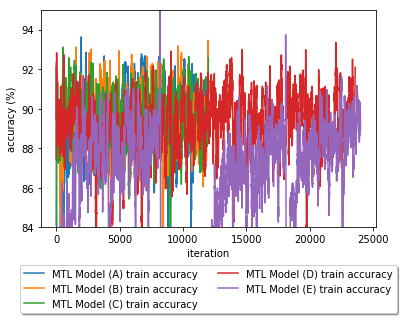

In [104]:
from scipy.signal import savgol_filter
plt.figure()
plt.ylim(84, 95)

tr_ac_1_1 = savgol_filter(train_acc_1_A, 151, 3)
tr_ac_1_2 = savgol_filter(train_acc_2_A, 151, 3)
tr_ac_1_3 = savgol_filter(train_acc_3_A, 151, 3)
tr_ac_1_4 = savgol_filter(train_acc_4_A, 151, 3)
tr_ac_1_5 = savgol_filter(train_acc_5_A, 151, 3)

plt.xlabel('iteration')
plt.ylabel('accuracy (%)')

plt.plot([i for i in range(0, len(tr_ac_1_1))], tr_ac_1_1*100, label='MTL Model (A) train accuracy')
plt.plot([i for i in range(0, len(tr_ac_1_2))], tr_ac_1_2*100, label='MTL Model (B) train accuracy')
plt.plot([i for i in range(0, len(tr_ac_1_3))], tr_ac_1_3*100, label='MTL Model (C) train accuracy')
plt.plot([i for i in range(0, len(tr_ac_1_4))], tr_ac_1_4*100, label='MTL Model (D) train accuracy')
plt.plot([i for i in range(0, len(tr_ac_1_5))], tr_ac_1_5*100, label='MTL Model (E) train accuracy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.subplots_adjust(hspace = 0.2)

plt.show()

In [99]:
"""
Test
"""
batch_size_test = 20
nb_test_points = x_test_fashion.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds_1 = []
preds_2 = []
for i in range(nb_iterations):
    input_x_test = x_test_fashion[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_1, preds_test_2 = sess.run([model.pred_1, model.pred_2], 
                             feed_dict={model.X: input_x_test})
    preds_1.append(np.argmax(preds_test_1, axis=1))
    preds_2.append(np.argmax(preds_test_2, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test_fashion[i*batch_size_test: -1]
        preds_test_1, preds_test_2 = sess.run([model.pred_1, model.pred_2], 
                             feed_dict={model.X: input_x_test})
        preds_1.append(np.argmax(preds_test_1, axis=1))
        preds_2.append(np.argmax(preds_test_2, axis=1))
all_preds_1 = np.concatenate(preds_1, axis =0)
all_preds_2 = np.concatenate(preds_2, axis =0)
y_real_1 = np.argmax(y_test_1, axis=1)
y_real_2 = np.argmax(y_test_2, axis=1)
acc_test_1 = np.mean((all_preds_1==y_real_1)*1)
acc_test_2 = np.mean((all_preds_2==y_real_2)*1)
print('Test accuracy - task 1 achieved: %.3f' %acc_test_1)
print('Test accuracy - task 2 achieved: %.3f' %acc_test_2)

Test accuracy - task 1 achieved: 0.817
Test accuracy - task 2 achieved: 0.895


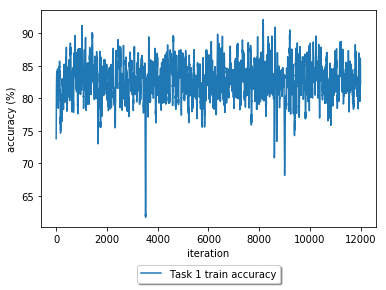

In [102]:
from scipy.signal import savgol_filter
plt.figure()
tr_ac = savgol_filter(train_accuracies_4a_1, 51, 3)
plt.xlabel('iteration')
plt.ylabel('accuracy (%)')
plt.plot([i for i in range(0, len(tr_ac))], tr_ac*100, label='Task 1 train accuracy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.subplots_adjust(hspace = 0.2)
plt.show()

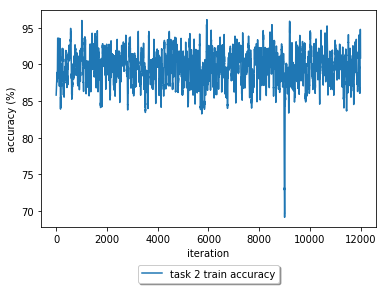

In [103]:
plt.figure()
tr_ac = savgol_filter(train_accuracies_4a_2, 51, 3)
plt.xlabel('iteration')
plt.ylabel('accuracy (%)')
plt.plot([i for i in range(0, len(tr_ac))], tr_ac*100, label='task 2 train accuracy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.subplots_adjust(hspace = 0.2)
plt.show()

In [132]:
sess.close()

#### Discuss the performance of the MTL network compared to the single task networks. What do think are the most important things to consider when using MTL?

##### Task 6.3

In this task we want you to compare the MTL's results for different values of $\lambda$. We want you to coampre $5$ different values of $\lambda$ with the stipulation that two of them must be $0$ and $1$; the other 3 are up to you. All other hyperparameters (e.g. number of dense shared layers) can be left as they were in Task 6.2. 

Plot a graph showing the Task 1 and Task 2 accuracies against values of $\lambda$. 
Comment on your results. 
Whats so special about the cases of $\lambda = 0$ and $\lambda = 1$?

####  Task 6.4

##### Similar to tasks  3.2 and 4.2

 - Plot a graph showing complexity (number of paramters) vs. accuracy for each of the to tasks in the MTL network. As above you will need to train four other additional MTL networks where you vary the number/size of the shared and  task specific layers (we advise not making the layers too large or too numerous to avoid very long training times). 
 - You should also include plots of the number of parameters vs accuracy for the individual task 1 and 2 networks - use different colours to distinguish these single task networks.
     - Note 1 : There is no need to train additional Task 1 and Task 2 networks simply use the formats from Question 6.1
     - Note 2: For all MTL formats set $\lambda$ to $0.5$ for equal weighting
     - Note 3: Due to the sub task structure, we will ignore depth in this evaluation as the two tasks can have different depth levels in the MTL architecture. 
     - Note 4: It is advised to include pooling layers (we leave the type of pooling up to you but recommned maxpooling) for the sake of training time - alternativly use larger strides. 
 
 - Discuss the effect of the number/size of the shared and task specific layers in terms of performance and training/testing times. Also compare the performance to the task specific networks from 6.1. 
 
 - Discuss the main pros and cons for multi-task learning.

### 7. Denoising Auto-Encoder (10 points)

While CNNs make very good classifiers, they can also be used for many various tasks such as regression, image generation, image reconstruction and so on. In this part of the coursework you should implement a fully convolutional de-noising auto-encoder, i.e. a network that takes a noisy image as input and outputs the corresponding cleaned output. In this exercise we will introduce a gaussian noise on each input. Our goal is to recover the original noiseless images in the output. We will be using the MNIST dataset here.

Similarly as before we will define the class DAE, and you will need to complete the method 'create_model' and 'compute_loss' accordingly. 

Using the functions tf.layers.conv2d and tf.layers.conv2d_transpose complete the method 'create_model' in the class DAE below. 

conv2d should be used for the encoding part while conv2d_transpose should be used for the decoding part. 
We will use ReLu as the non linear activation for the hidden layers and tanh as the activation for the output layer. 
The network architecture is as follows:

+ Encoding part: a series of conv2d layers with [32, 64, 128] filters of size 4\times4, a stride of 1 in the first layer and a stride of 2 for the second and third layers.  
+ Decodind part: a series of two conv2d_transpose followed by one, one strided conv2d with [64,32,1] filters of size 4\times4. 

The output dimension of the final layer should match the input dimension [batch_size, 28, 28]. If necesseray use the argument padding or the function tf.pad to make the input and ouput dimensions match. 

Complete the method compute_loss. Note that we don't have a classification problem anymore but a regression problem consisting of reconstructing the noiseless version of the input.

In [144]:
class DAE:
    def __init__(self, x_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        print(x_train.shape)
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.im_n = self.im + tf.random_normal(tf.shape(self.im), mean=0, stddev=1) #inject noise
        self.x_train = x_train[:,:,:, np.newaxis]
        
    def create_model(self):
        print(self.im_n.shape)
        with tf.variable_scope('DAE', reuse=tf.AUTO_REUSE):
            ######### Complete the function ######### 
            # ENCODING
            self.conv1 = tf.layers.conv2d(self.im_n, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=1,padding='same', name='conv2d1') 
            self.conv2 = tf.layers.conv2d(self.conv1, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same',name='conv2d2') 
            self.conv3 = tf.layers.conv2d(self.conv2, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same',name='conv2d3') 
            
            # DECODING
            self.t_conv1 = tf.layers.conv2d_transpose(self.conv3, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same', name='convt2d1') 
            self.t_conv2 = tf.layers.conv2d_transpose(self.t_conv1, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same', name='convt2d2') 
            self.out = tf.layers.conv2d(self.t_conv2, filters= 1, kernel_size=4, activation = tf.nn.tanh, strides=1, padding='same', name='convt2d3') 
            self.recon_im = self.out
            #########################################
            
            tf.summary.image('denoising', tf.concat([self.im_n, self.recon_im], axis=2))
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.reduce_mean(tf.square(self.im - self.recon_im)) 
            self.loss = tf.reduce_mean(self.loss + 0.0005 * tf.image.total_variation(self.recon_im))
            #########################################
            self.loss_summ = tf.summary.scalar("reconstruction_loss", self.loss)
                             
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [145]:
tf.reset_default_graph()
model = DAE(x_train, './DAE_logdir/', 0.0001, 3, 20)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

(60000, 28, 28)
(?, 28, 28, 1)


Similar to the previous questions, train the DAE by looping over all the mini-batches. For proper training you should input enough noisy versions per image. 
- Plot the training/validation curves and discuss why your trained model is not under/over fitting.
When the training is finished, inject noise into the test data and reconstruct them through a forward pass. For each test image, input 20 noisy versions of it and compute the average accuracies. 

- Test the robustness of the trained network to different levels of noise, demonstrate the results (figure or Table) and discuss them in your report. 
- Why this architecture is able to remove noise from data? 

Epoch 0, Iteration 0, loss 0.120


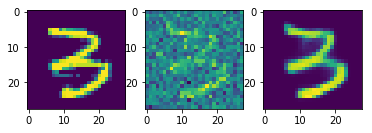

Epoch 0, Iteration 500, loss 0.114


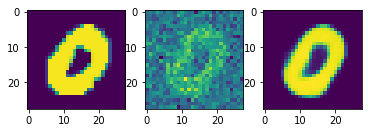

Epoch 0, Iteration 1000, loss 0.121


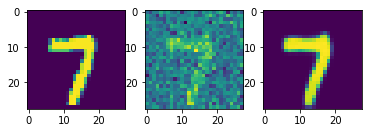

Epoch 0, Iteration 1500, loss 0.127


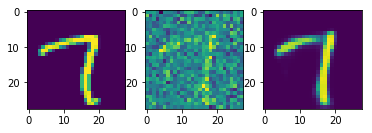

Epoch 0, Iteration 2000, loss 0.123


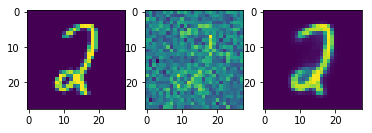

Epoch 0, Iteration 2500, loss 0.112


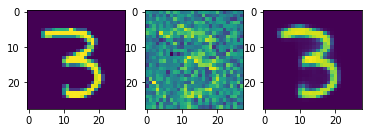

Epoch 1, Iteration 0, loss 0.122


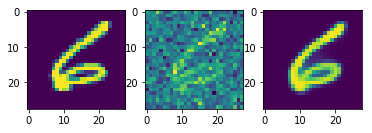

Epoch 1, Iteration 500, loss 0.111


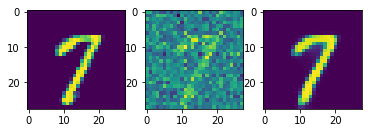

Epoch 1, Iteration 1000, loss 0.124


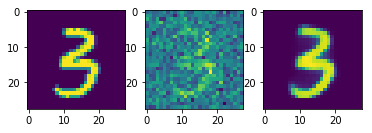

Epoch 1, Iteration 1500, loss 0.114


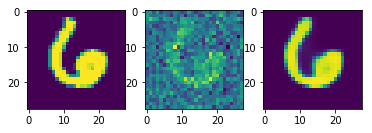

Epoch 1, Iteration 2000, loss 0.116


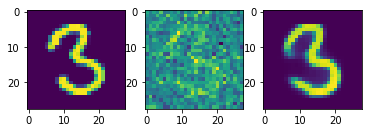

Epoch 1, Iteration 2500, loss 0.112


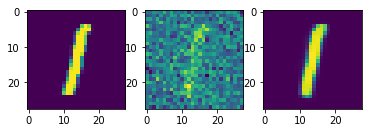

Epoch 2, Iteration 0, loss 0.115


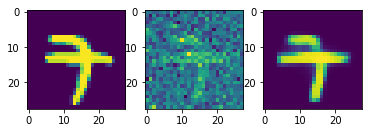

Epoch 2, Iteration 500, loss 0.124


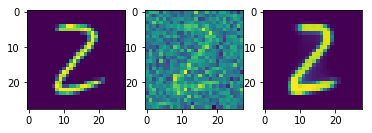

Epoch 2, Iteration 1000, loss 0.115


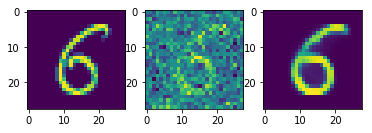

Epoch 2, Iteration 1500, loss 0.120


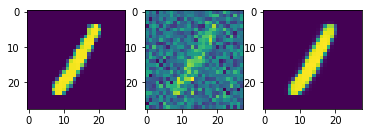

Epoch 2, Iteration 2000, loss 0.119


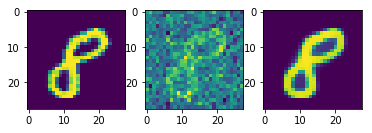

Epoch 2, Iteration 2500, loss 0.112


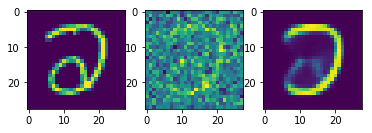

In [147]:
losses = []

for epoch in range(model.nb_epochs):
    randomize = np.arange(model.x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    for i in range(model.nb_iterations):
        for r in range(10):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , denoised, noisy, loss, loss_summ= sess.run([model.trainer, model.recon_im, model.im_n, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train})
#         print('Epoch %d, Iteration %d, loss %.3f' %(epoch, i, loss))
        losses.append(loss)
        if i % 500 == 0:
            print('Epoch %d, Iteration %d, loss %.3f' %(epoch, i, loss))
            fig, ax = plt.subplots(nrows=1, ncols=3)
            ax[0].imshow(input_x_train[0].reshape(28,28))
            ax[1].imshow(noisy[0].reshape(28,28))
            ax[2].imshow(denoised[0].reshape(28,28))
            plt.show()
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch) 
end = time.time()

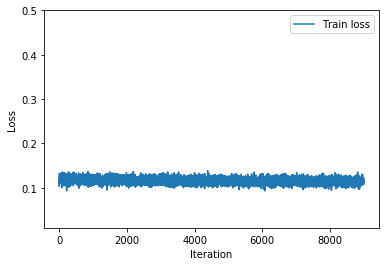

In [152]:
plt.plot(losses, label='Train loss')
plt.ylim(0.01,0.5)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

### Task 8 - Building a Variational AutoEncoder (VAE) 12 Points

<br>

#### Why use a VAE?

<br>

<p style='text-align: justify;'>
Building on the standard AutoEncoder which was a way of learning some lower dimensional manifold the data could lie on, we want to impose a form of regularisation, that is, we want some topology structure. We want inputs to the AutoEncoder that have a certain structure to be mapped to similar areas in this lower dimensional latent space. But the standard AutoEncoder merely learns how to essentially compress data. In this task, we are interested in learning a more structured latent space where we can sample in this space to then generate a new image that theoretically belongs to the same dataset.
    
In this exercise, we will assume the structure in the latent space follows a standard bi-variate Gaussian i.e. mean $\begin{bmatrix}0\\0\end{bmatrix}$ and covariance $\begin{bmatrix}1&0\\0&1\end{bmatrix}$. This assumption is for simplicity but we can infact assume other distributions (outside the scope for this exercise). We will be using the MNIST dataset for this task.
    
</p>

<br>

#### Architecture

<img src="vae-diagram.png" alt="The Variational AutoEncoder" title="VAE Architecture" />

<br>

#### Notation

<br>

Before diving into some maths, lets define a few terms:
1. $\mathbf{X}$: the dataset distribution we wish to generate from
2. $\mathbf{z}$: the compressed latent variable which quantifies a set of attributes of our dataset
3. $\boldsymbol{\theta}$ : the parameters for the ***encoder*** network
4. $\boldsymbol{\phi}$: the parameters for the ***decoder*** network
5. $p(\mathbf{z})$: the probability of the compressed latent space (given it should follow a standard normal)
6. $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{X})$: the conditional probability distribution of sampling the compressed latent variable given the dataset approximated by our encoder network with parameters $\boldsymbol{\phi}$
7. $p_{\boldsymbol{\theta}}(\mathbf{X}|\mathbf{z})$: the conditional probability distribution of generating the dataset given the compressed latent space by our decoder network with parameters $\boldsymbol{\theta}$

<br>

#### Optimisation

<br>

The quantity we are interested in maximising for the $i$-th observation is:

$
\begin{align}
    \log p (\mathbf{x}_i) && \text{which can be rewritten as...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log p (\mathbf{x}_i) \text{d}\mathbf{z} & \text{as the integral over a distribution is 1...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i)[\log p (\mathbf{z}|\mathbf{x}_i) - \log p(\mathbf{z}) + \log p_\boldsymbol{\theta}(\mathbf{x}_i|\mathbf{z})]\text{d}\mathbf{z} & \text{consider Baye's rule...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log \frac{p (\mathbf{z}|\mathbf{x}_i)}{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} - q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i)\log \frac{p (\mathbf{z})}{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} + q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log p_\boldsymbol{\theta}(\mathbf{x}_i|\mathbf{z})\text{d}\mathbf{z}\\
    &= \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}|\mathbf{x}_i)) - \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z})) + \mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})]\\
    &=  \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}|\mathbf{x}_i)) + \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i) &\text{where the last two terms have been grouped as $\mathcal{L}$}
\end{align}
$

<br>


As the first term in the line above is intractable to compute, we can say that $\log p_\boldsymbol{\theta} (\mathbf{x}_i) \ge \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i)$ as the KL-divergence is a distance measure (and hence non-negative) and $\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i)$ is known as the **variational lower bound**. Instead of maximising the log probability directly, we can instead maximise this lower bound! If you are unfamiliar with the KL-divergence, check out this [Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

<br>

The lower bound can be clearly seen as two main components:

$
\begin{align}
\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i) = \color{blue}{\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})]} - \color{green}{\text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}))}
\end{align}
$
+ <font color='blue'> How well can we reconstruct our original data from the latent space?</font>
+ <font color='green'> How similar is the latent space to a standard Gaussian?</font>

A remark on the second point - we are trying to find a Gaussian distribution manifold in latent space for our dataset. This is known as a *variational* method which should be part of the Bayesian Machine Learning module.

<br>

#### Derivations

Given that $\mathbf{\hat{x}}_i$ is a draw from $p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})\sim\mathcal{N}(\mathbf{x},\sigma^2\mathbf{I})$, the expectation of $\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})$ can be computed as:

$
\begin{align}
\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})] &= -\frac{m}{2}\log 2\pi\sigma^2 - \frac{1}{2}(\mathbf{\hat{x}}_i - \mathbf{x}_i)^\text{T}(\sigma^2\mathbf{I})^{-1}(\mathbf{\hat{x}}_i - \mathbf{x}_i)\\
\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{Z}|\mathbf{X})} [\log p_{\boldsymbol{\theta}} (\mathbf{X}|\mathbf{Z})] &\propto \sum_{i = 1}^{i = n}\sum_{j = 1}^{j = m} (\hat{x}_{ij} - x_{ij})^2 & \text{as everything else is just a constant}
\end{align}
$

<font color='red'>Given that $q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i) \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I})$, derive the KL-divergence term between this and $p_\boldsymbol{\theta} (\mathbf{z})$ i.e. $\text{D}_{\text{KL}} (\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I}), \mathcal{N}(0, \mathbf{I}))$:</font>

$
\begin{align}
\text{D}_{\text{KL}} (\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I}), \mathcal{N}(0, \mathbf{I})) &= \int_{\mathbf{z}\in\mathcal{Z}} ?\text{ d}\mathbf{z}
\end{align}
$

Further readings: There are many useful online tutorials that provide deep insight as how VAEs work or to implement them; for instace [tutorial1](https://arxiv.org/abs/1606.05908) [tutorial2](http://ruishu.io/2018/03/14/vae/). 

#### Defining the Data and Helper Functions

In [23]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

image_size       = x_train.shape[1]
original_dim     = image_size * image_size

# Flatten each image to be a vector (you can try convolutional layers as an extension)
x_train          = np.reshape(x_train, [-1, original_dim])
x_test           = np.reshape(x_test, [-1, original_dim])
x_train          = x_train.astype('float32') / 255
x_test           = x_test.astype('float32') / 255

# Visualisation parameters (for after the implementation of the VAE - start playing with these after the VAE seems to work!)
n                = 29 # Number of digits to show per row / col
dsize            = 28 # Digit size

z1               = norm.ppf(np.linspace(0.01, 0.99, n))
z2               = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid           = np.dstack(np.meshgrid(z1, z2))

Zf               = lambda x : sess.run(z_mean, feed_dict = {t_X : x})
Xf               = lambda z_grid : sess.run(t_X_hat, feed_dict = {z : z_grid.reshape(n * n, nlatent)}).reshape(n, n, dsize, dsize)

def get_batch(*args, size):
    """ Loops through each argument in batches of [size] """
    
    n = len(args[0])
    if size is None or size >= n:
        yield from args
        return None
    r = np.random.permutation(n)
    for i in range(n // size + 1):
        yield(arg[r[i * size : (i + 1) * size]] for arg in args)



def visualise(X, y, sep = 2):
    #     """ Visualise the mapped 2D manifold """
    # Feel free to modify this code for your visualisations...
    Z  = Zf(x_test)
    Xh = Xf(z_grid)

    plt.figure(figsize = (12, 10))
    plt.scatter(Z[:, 0], Z[:, 1], c = y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")

    plt.figure(figsize = (12, 10))
    plt.imshow(np.block(list(map(list, Xh))), cmap = 'gray')
    start_range    = dsize // 2
    end_range      = n * dsize + start_range
    pixel_range    = np.arange(start_range, end_range, dsize)
    sample_range_x = np.round(z1, 2)
    sample_range_y = np.round(z2, 2)
    plt.xticks(pixel_range[::sep], sample_range_x[::sep])
    plt.yticks(pixel_range[::sep], sample_range_y[::sep])

#### Task 8.1 Implementation of VAE

<br>

The simpler implementation of the VAE is to build off the MLP i.e. no convolutional layers. The code below is designed for this but feel free to swap out this assumption for convolutions should you feel more confident. Feel free to add `tf.summary` definitions in a similar way to previous tasks for tensorboard visualisations.

 #### Note: If implementing task 8.1 in TF (as guided bellow) is not straightforward for you, use an easier option: [Keras](https://keras.io/examples/variational_autoencoder/) implementation of VAE. In these case, you will be marked down 4 points but you can immediately proceed to task 8.2. 

In [24]:
import time

# Hyperparameters...
layers   = [512, 256, 128]
nlatent  = 2
batch    = 128
epochs   = 30
alpha    = 1e-3



# General dtype to use
dtype    = 'float32'

# Number of features
m        = x_train.shape[1]

startT = time.time()

# Reset the graph to ensure blank graph initially...
tf.reset_default_graph()

# Define placeholder for 'X' data
t_X      = tf.placeholder(dtype = dtype, shape = [None, m], name = 'X')

# Define how t_X maps to the layer before the latent space
with tf.name_scope('Encoder'):
    h        = t_X
    for i, layer in enumerate(layers, 1):
        with tf.name_scope(f'Layer_{i}'):
            ######### Map how we get from the previous layer to the next hidden layer #########
            h    = tf.layers.dense(inputs=h, units=layer, activation=tf.nn.relu)
    
# Define how we get the mean and variance from the previous hidden layer
with tf.name_scope('Latent'):
    
    with tf.name_scope('Mean'):
        z_mean   = tf.layers.dense(inputs=h, units=nlatent)

    with tf.name_scope('Variance'):
        z_var    = tf.layers.dense(inputs=h, units=1)
        
    # Code the "reparameterisation trick"
    with tf.name_scope('Sample'):
        epsilon  = tf.random_normal(tf.shape(z_mean), mean=0, stddev=1)
        z_sample = z_mean + tf.math.exp(z_var / 2)*epsilon
        z        = tf.placeholder_with_default(z_sample, shape = [None, nlatent], name = 'z')


# Define how "z" decodes to our reconstructed "t_X" estimate
with tf.name_scope('Decoder'):
    h        = z
    for i, layer in enumerate(layers[::-1], 1):
        with tf.name_scope(f'Layer_{i}'):
            h    = tf.layers.dense(inputs=h, units=layer, activation=tf.nn.relu)
    
    with tf.name_scope('Final'):
        t_X_hat  = tf.layers.dense(inputs=h, units=m, activation=tf.nn.sigmoid)

        
# Define the loss function as defined in the derivation section
with tf.name_scope('Loss'):
    with tf.name_scope('AutoEncoder'):
        # The normal AutoEncoder loss should measure how far our t_X_hat is from t_X
        loss_ae  = -tf.reduce_sum(t_X * tf.log(1e-10 + t_X_hat)
                           + (1-t_X) * tf.log(1e-10 + 1 - t_X_hat),
                           1)

        
    with tf.name_scope('KL_Divergence'):
        # The KL-divergence between z and a standard normal you derived earlier
        loss_kl  = -0.5 * tf.reduce_sum(1 + z_var 
                                           - tf.square(z_mean) 
                                           - tf.exp(z_var), 1)
        
    loss = tf.reduce_mean(loss_ae + loss_kl, name = 'loss')

# Define final components before training the model
optim    = tf.train.AdamOptimizer(alpha).minimize(loss)
train    = {t_X : x_train}

sess     = tf.InteractiveSession()
writer   = tf.summary.FileWriter('./VAE_MLP_logdir', sess.graph)
sess.run(tf.global_variables_initializer())

# Gradient descent loop with verbose loss check...
# Hopefully we see our loss reduce!

train_losses = []
test_losses = []


for i in range(epochs):
    losses  = []
    for xb, in get_batch(x_train, size = batch):
        nb = len(xb)
        sess.run(optim, feed_dict = {t_X : xb})
        losses.append(nb * sess.run(loss, feed_dict = {t_X : xb}))
        print(f'\rIteration {i:2d}: loss = {losses[-1] / nb:6,.2f}', end = '')
    print(f'\rIteration {i:2d}: loss = {sum(losses) / len(x_train):6,.2f}')
    train_losses.append(sess.run(loss, feed_dict = {t_X: x_train}))
    test_losses.append(sess.run(loss, feed_dict = {t_X: x_test}))
    
timeTaken = int(time.time() - startT)

print(timeTaken,'s taken')


Iteration  0: loss = 184.45
Iteration  1: loss = 160.72
Iteration  2: loss = 153.37
Iteration  3: loss = 149.42
Iteration  4: loss = 147.22
Iteration  5: loss = 145.66
Iteration  6: loss = 144.47
Iteration  7: loss = 143.19
Iteration  8: loss = 142.52
Iteration  9: loss = 142.04
Iteration 10: loss = 141.13
Iteration 11: loss = 140.86
Iteration 12: loss = 141.10
Iteration 13: loss = 139.83
Iteration 14: loss = 139.24
Iteration 15: loss = 139.18
Iteration 16: loss = 138.79
Iteration 17: loss = 138.78
Iteration 18: loss = 138.03
Iteration 19: loss = 137.96
Iteration 20: loss = 137.51
Iteration 21: loss = 137.53
Iteration 22: loss = 137.36
Iteration 23: loss = 137.33
Iteration 24: loss = 137.02
Iteration 25: loss = 136.95
Iteration 26: loss = 136.80
Iteration 27: loss = 136.26
Iteration 28: loss = 136.87
Iteration 29: loss = 136.63
108 s taken


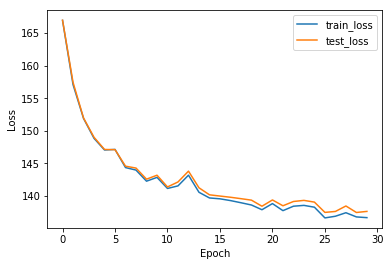

In [25]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#### Visualisation Check

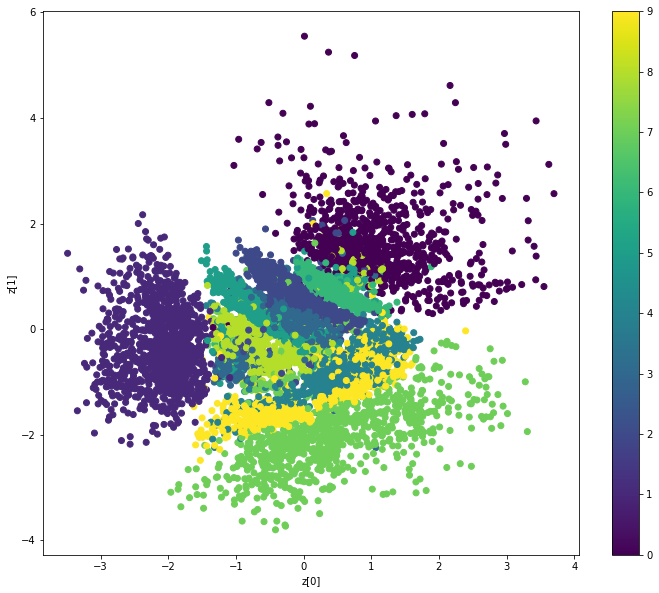

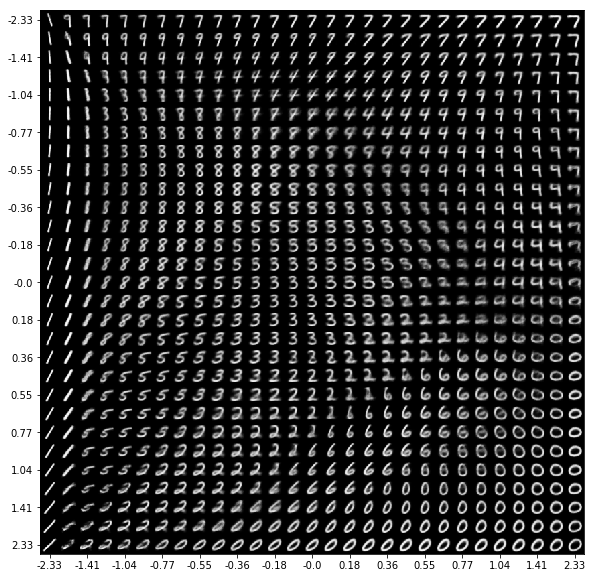

In [26]:
visualise(x_test, y_test)

####  Task 8.2

<br>

 - Plot the learning curve for your VAE
 - Generate new handwritten digits from your model by sampling `Z` = $\mathbf{z}\in\mathbb{R}^{n,2}$ and running `sess.run(t_X_hat, feed_dict = {z : Z))` in a separate code cell
     - Discuss how good / bad are these images?
         - Why are they good / bad? (consider the assumptions of your implementation of the VAE)
 - From observing your learnt manifold (by using the `visualise` function or otherwise), draw a comparison between the direct mapped points on your manifold (scatter plot) and the images that lay on the manifold (imshow)
     - Why are some points images more mixed than others?
     - Can we be smarter in where we should sample to get *better* generated handwritten digits?

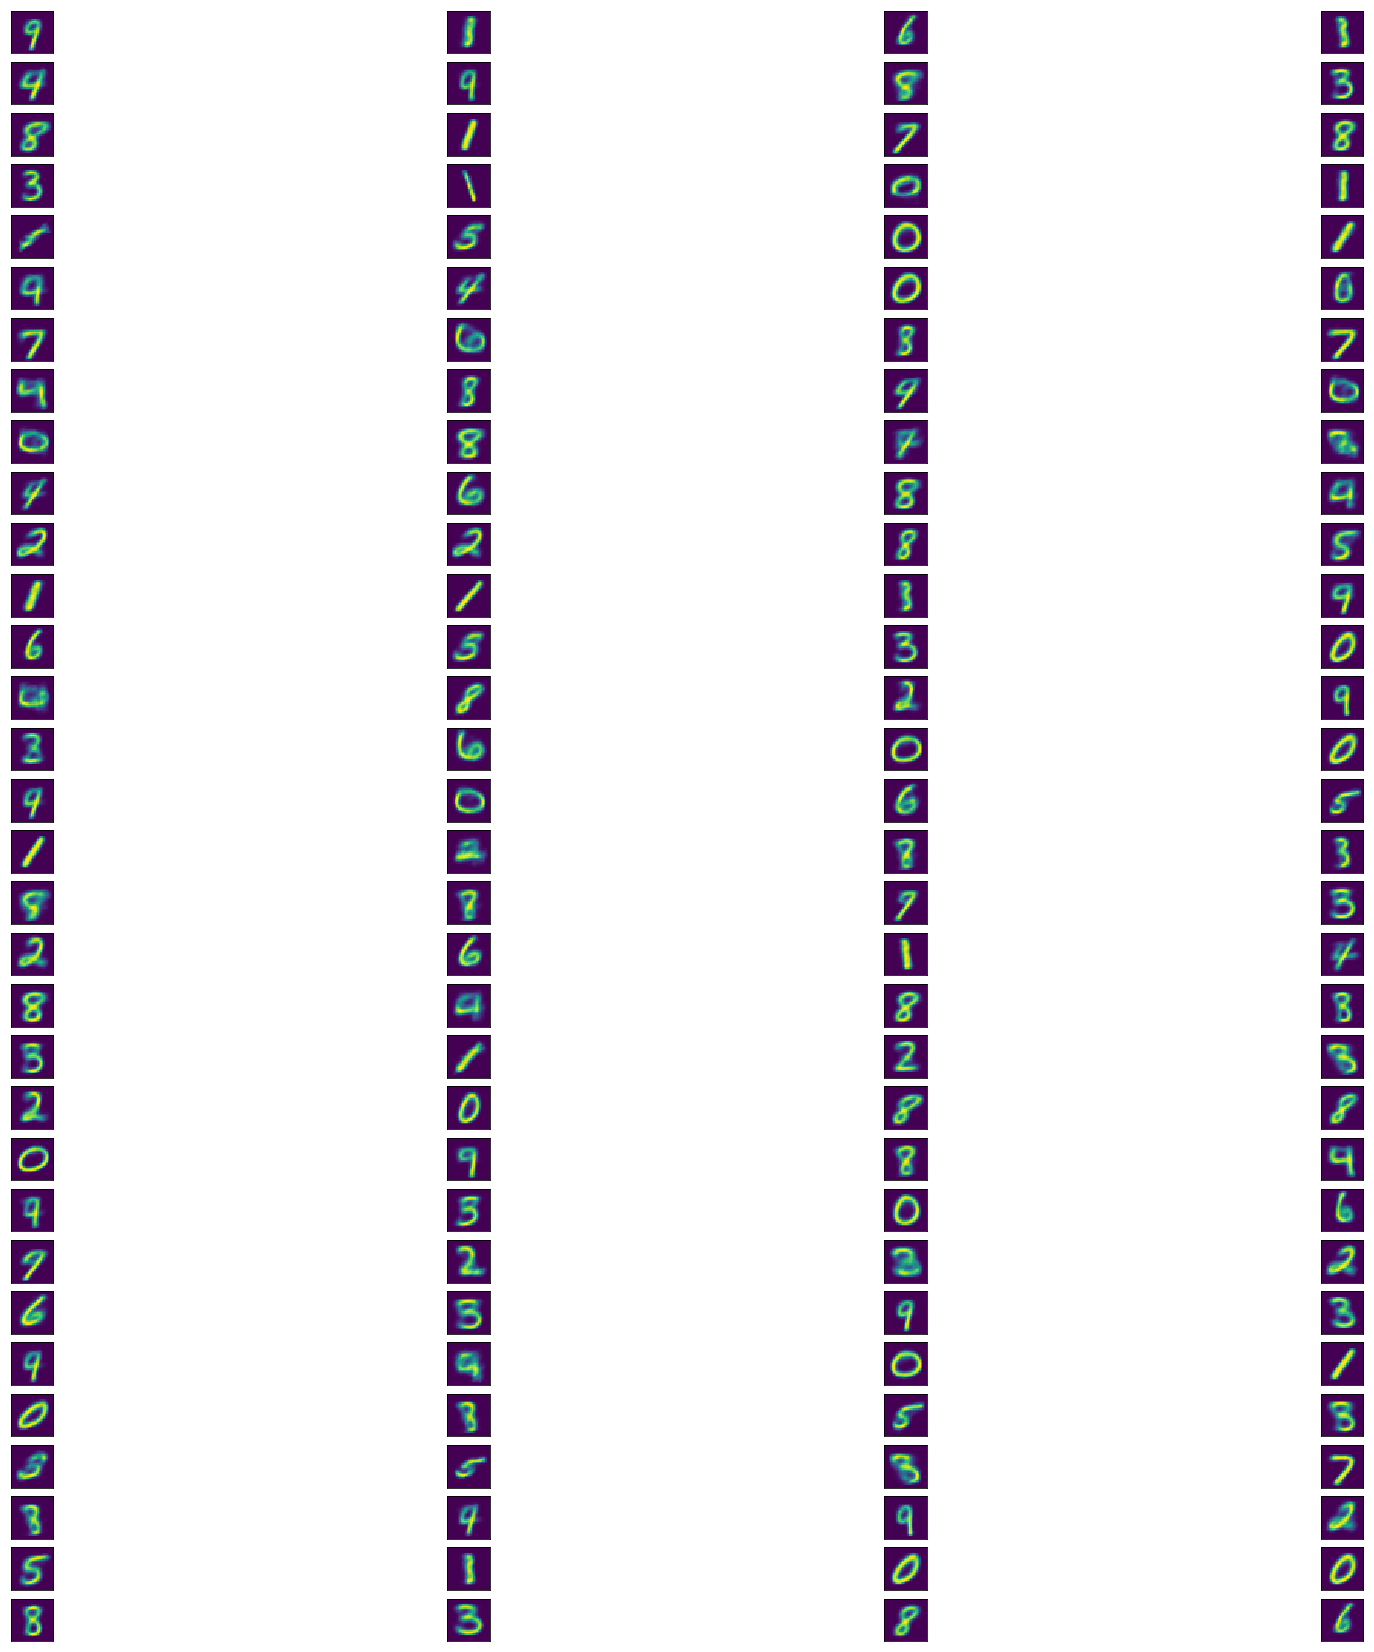

In [27]:
Z = np.random.normal(size=(batch,nlatent),loc=0, scale=1)
generated = sess.run(t_X_hat, feed_dict={z: Z})



fig, ax = plt.subplots(nrows=batch//4, ncols=4, figsize=(30,30))
counter = 0
for row in ax:
    for col in row:
        col.imshow(generated[counter].reshape(28,28))
        col.set_xticks([])
        col.set_yticks([])
        counter += 1
#             ax[0].imshow(input_x_train[0].reshape(28,28))
#             ax[1].imshow(noisy[0].reshape(28,28))
#             ax[2].imshow(denoised[0].reshape(28,28))
plt.imshow(generated[2].reshape(28,28))

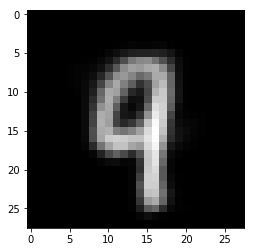

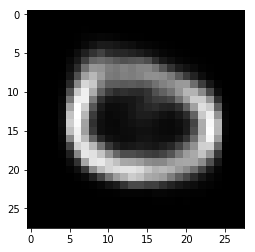

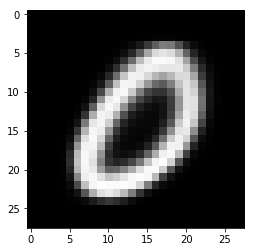

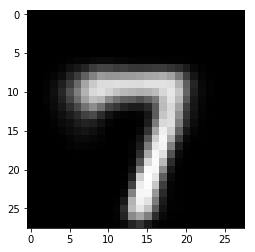

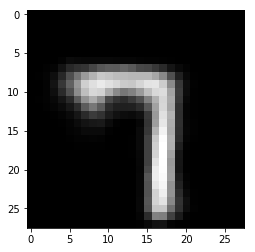

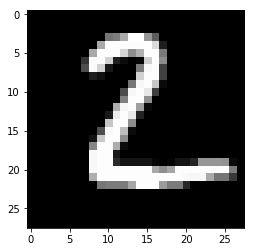

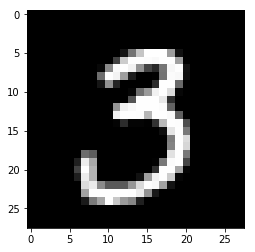

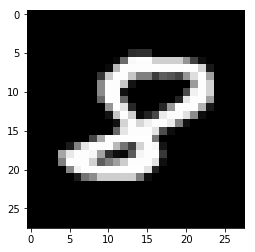

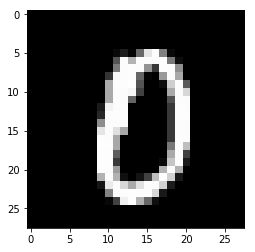

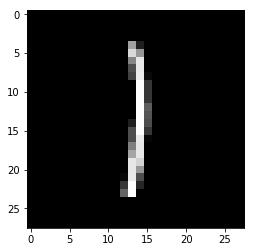

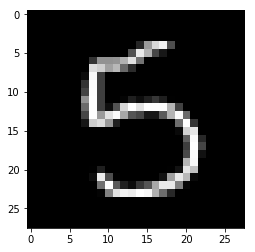

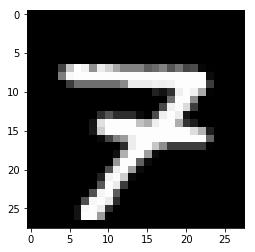

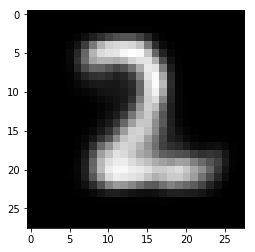

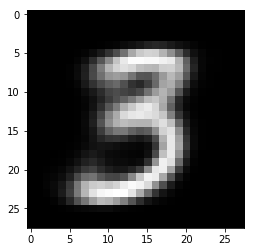

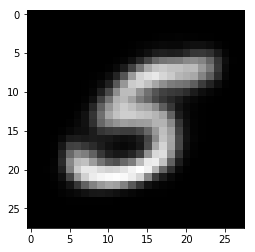

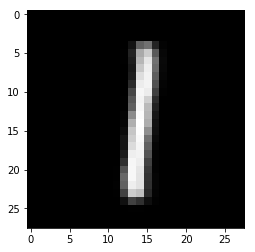

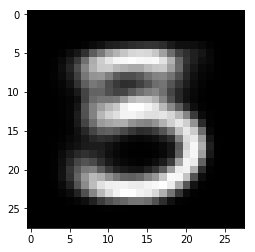

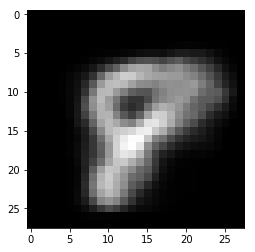

In [29]:
def gen_digit(low=-2,high=2):
    z1,z2 = np.random.uniform(low,high,2)
    Z = [[z1,z2]]
    digit = sess.run(t_X_hat, feed_dict={z: Z})
    digit = digit[0] #strip off outer bracket
    return digit

def plot_digit(digit):
    digit = np.reshape(digit,(28,28))
    plt.imshow(digit,interpolation='nearest', cmap='gray')
    plt.show()

for d in range(5):
    plot_digit(gen_digit())
    

x_test_out = sess.run(t_X_hat, feed_dict = {t_X: x_test})


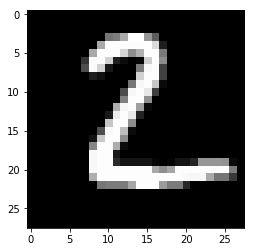

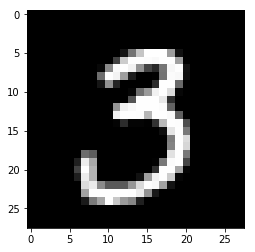

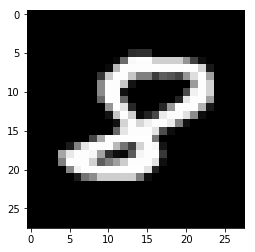

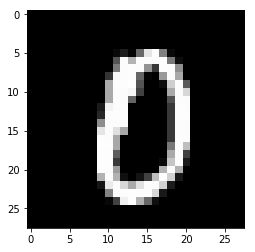

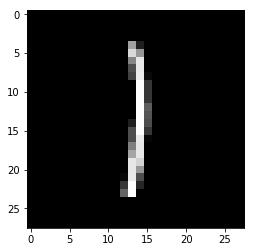

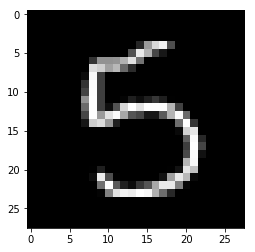

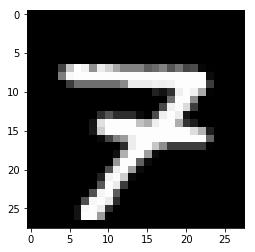

In [30]:
plot_digit(x_test[1])
plot_digit(x_test[90])
plot_digit(x_test[61])
plot_digit(x_test[55])
plot_digit(x_test[40])
plot_digit(x_test[53])
plot_digit(x_test[64])

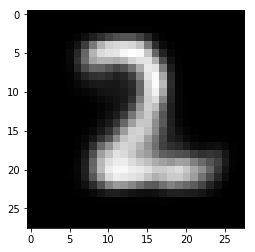

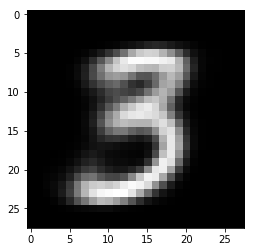

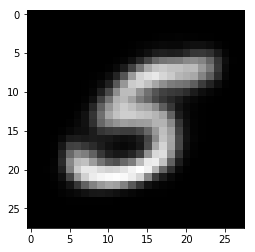

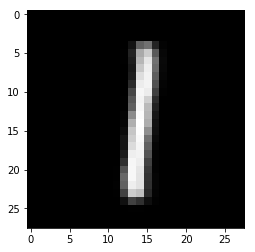

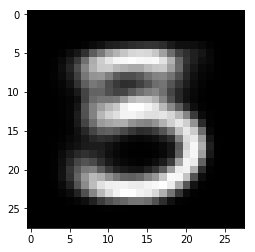

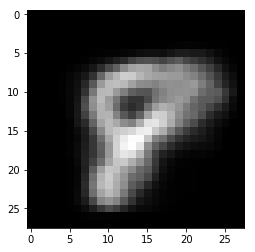

In [31]:
plot_digit(x_test_out[1])
plot_digit(x_test_out[90])
plot_digit(x_test_out[61])
plot_digit(x_test_out[40])
plot_digit(x_test_out[53])
plot_digit(x_test_out[64])